In [1]:
#%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime
import osmnx as ox, geopandas as gpd, pandas as pd, networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from IPython.display import Image
from descartes import PolygonPatch
from itertools import combinations, combinations_with_replacement
%matplotlib inline
ox.config(log_console=True, use_cache=True)
%config IPCompleter.greedy=True

import libpysal as lp

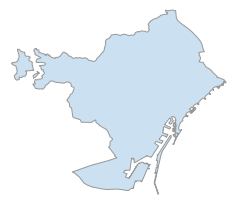

{'init': 'epsg:4326'}


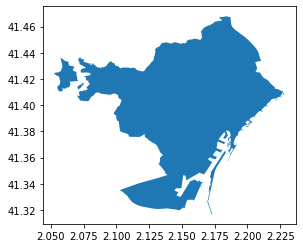

time: 620 ms


In [2]:
city = ox.gdf_from_place('Barcelona, Spain')
#city = ox.project_gdf(city)
fig, ax = ox.plot_shape(city, figsize=(4,4))
ox.save_gdf_shapefile(city)
crs = {'init': 'epsg:4326'}
city = city.to_crs(crs)
print(city.crs)
city.plot()

14012
data max index: 14011
number of NA prices: 0
average bedroom price 56.24637648827263
pointinpoly length: 14006
check contains: True
check if there are NAs: False


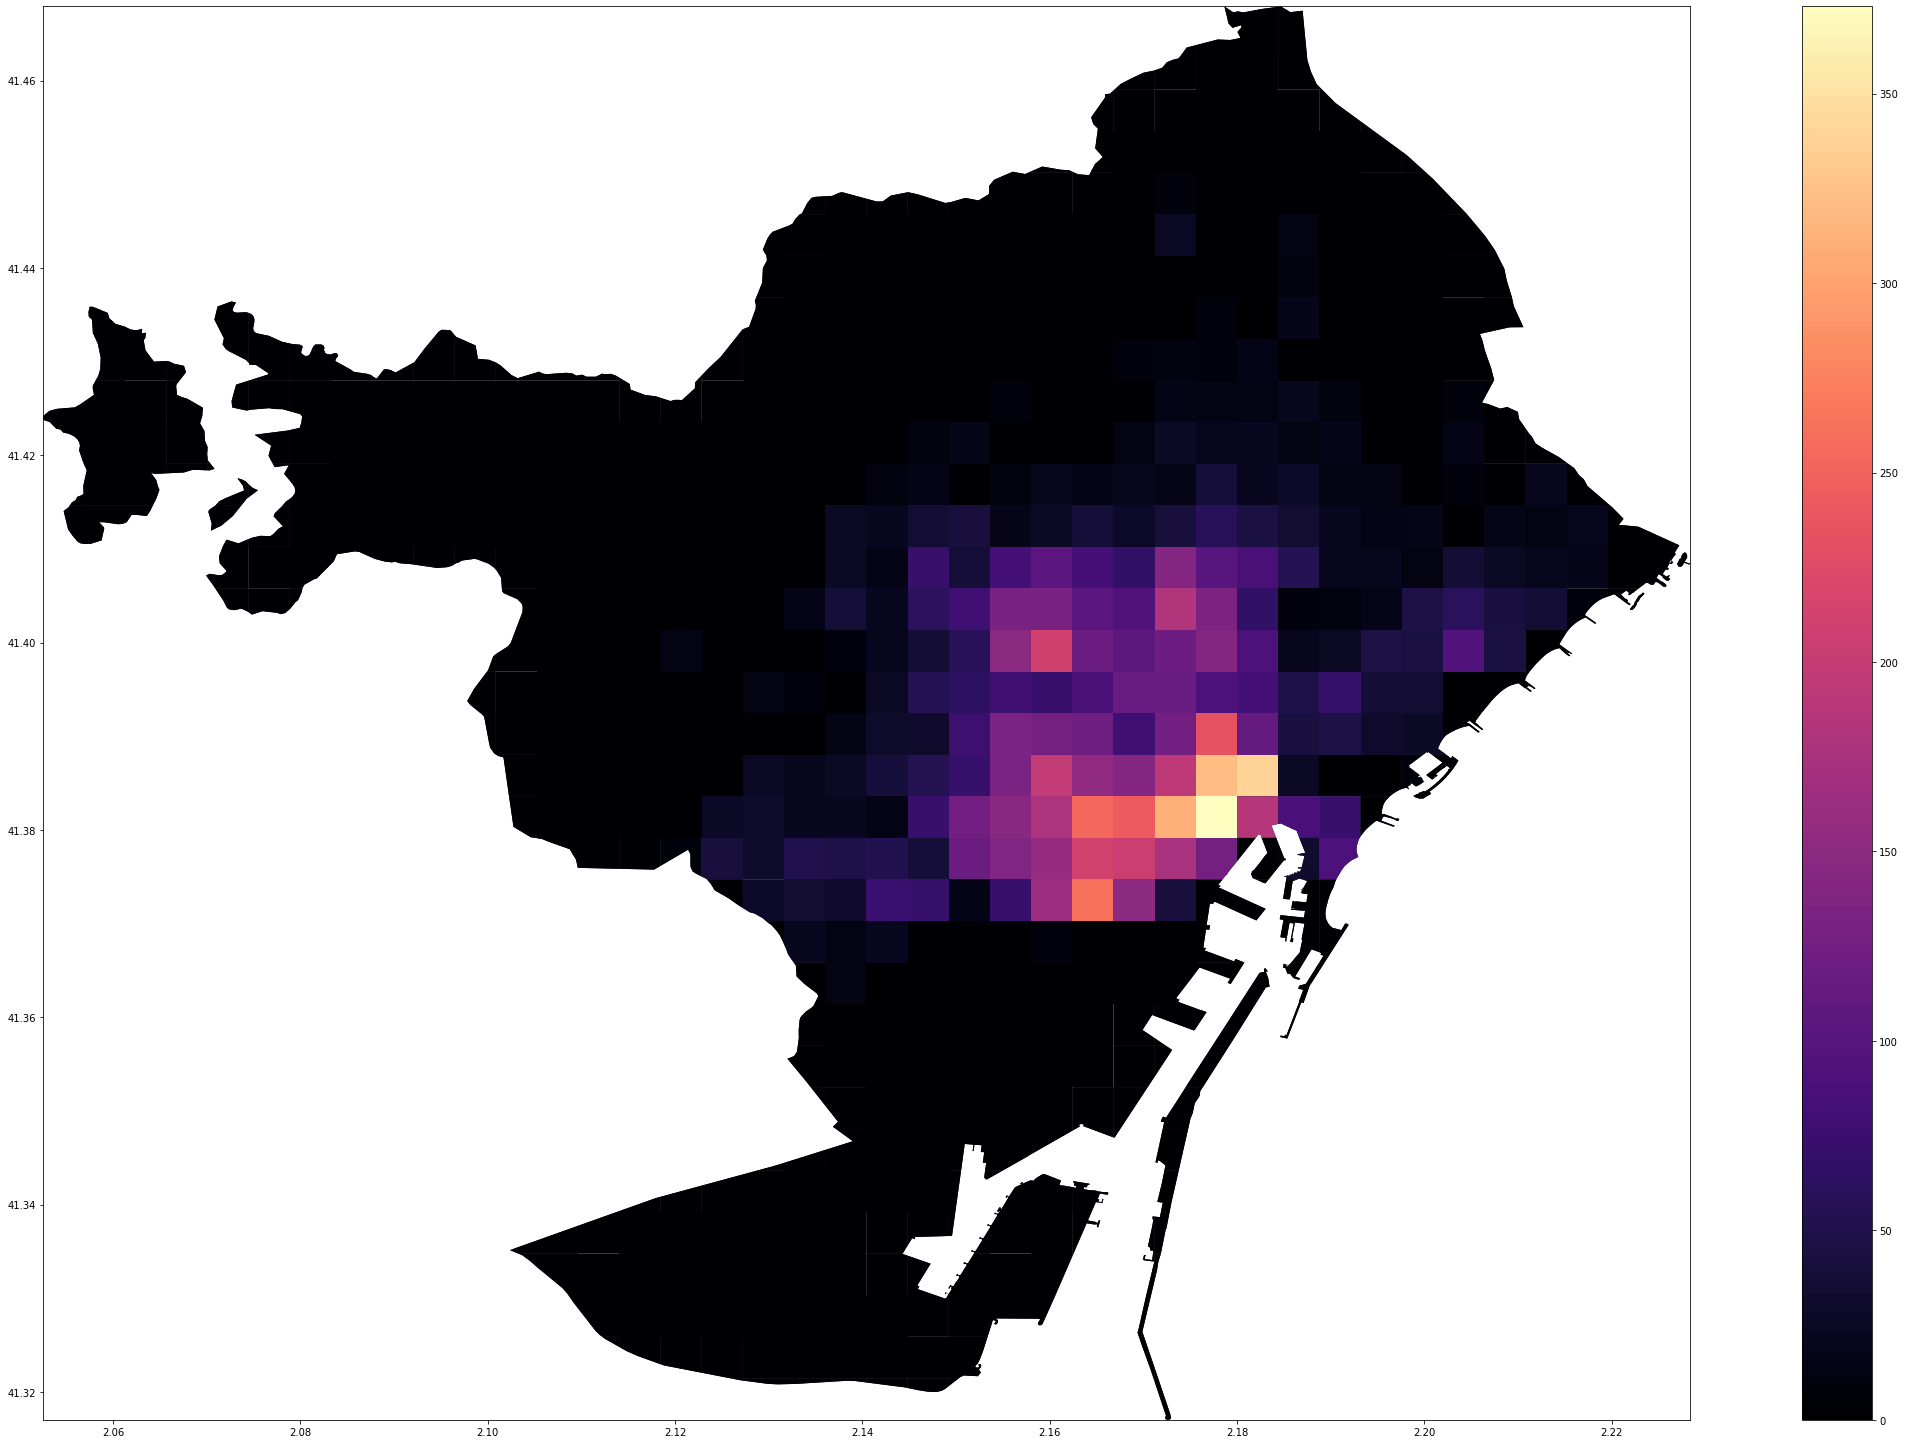

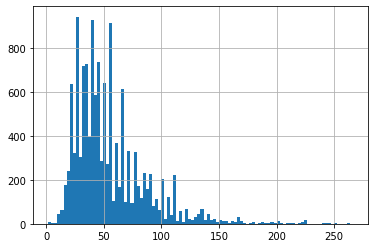

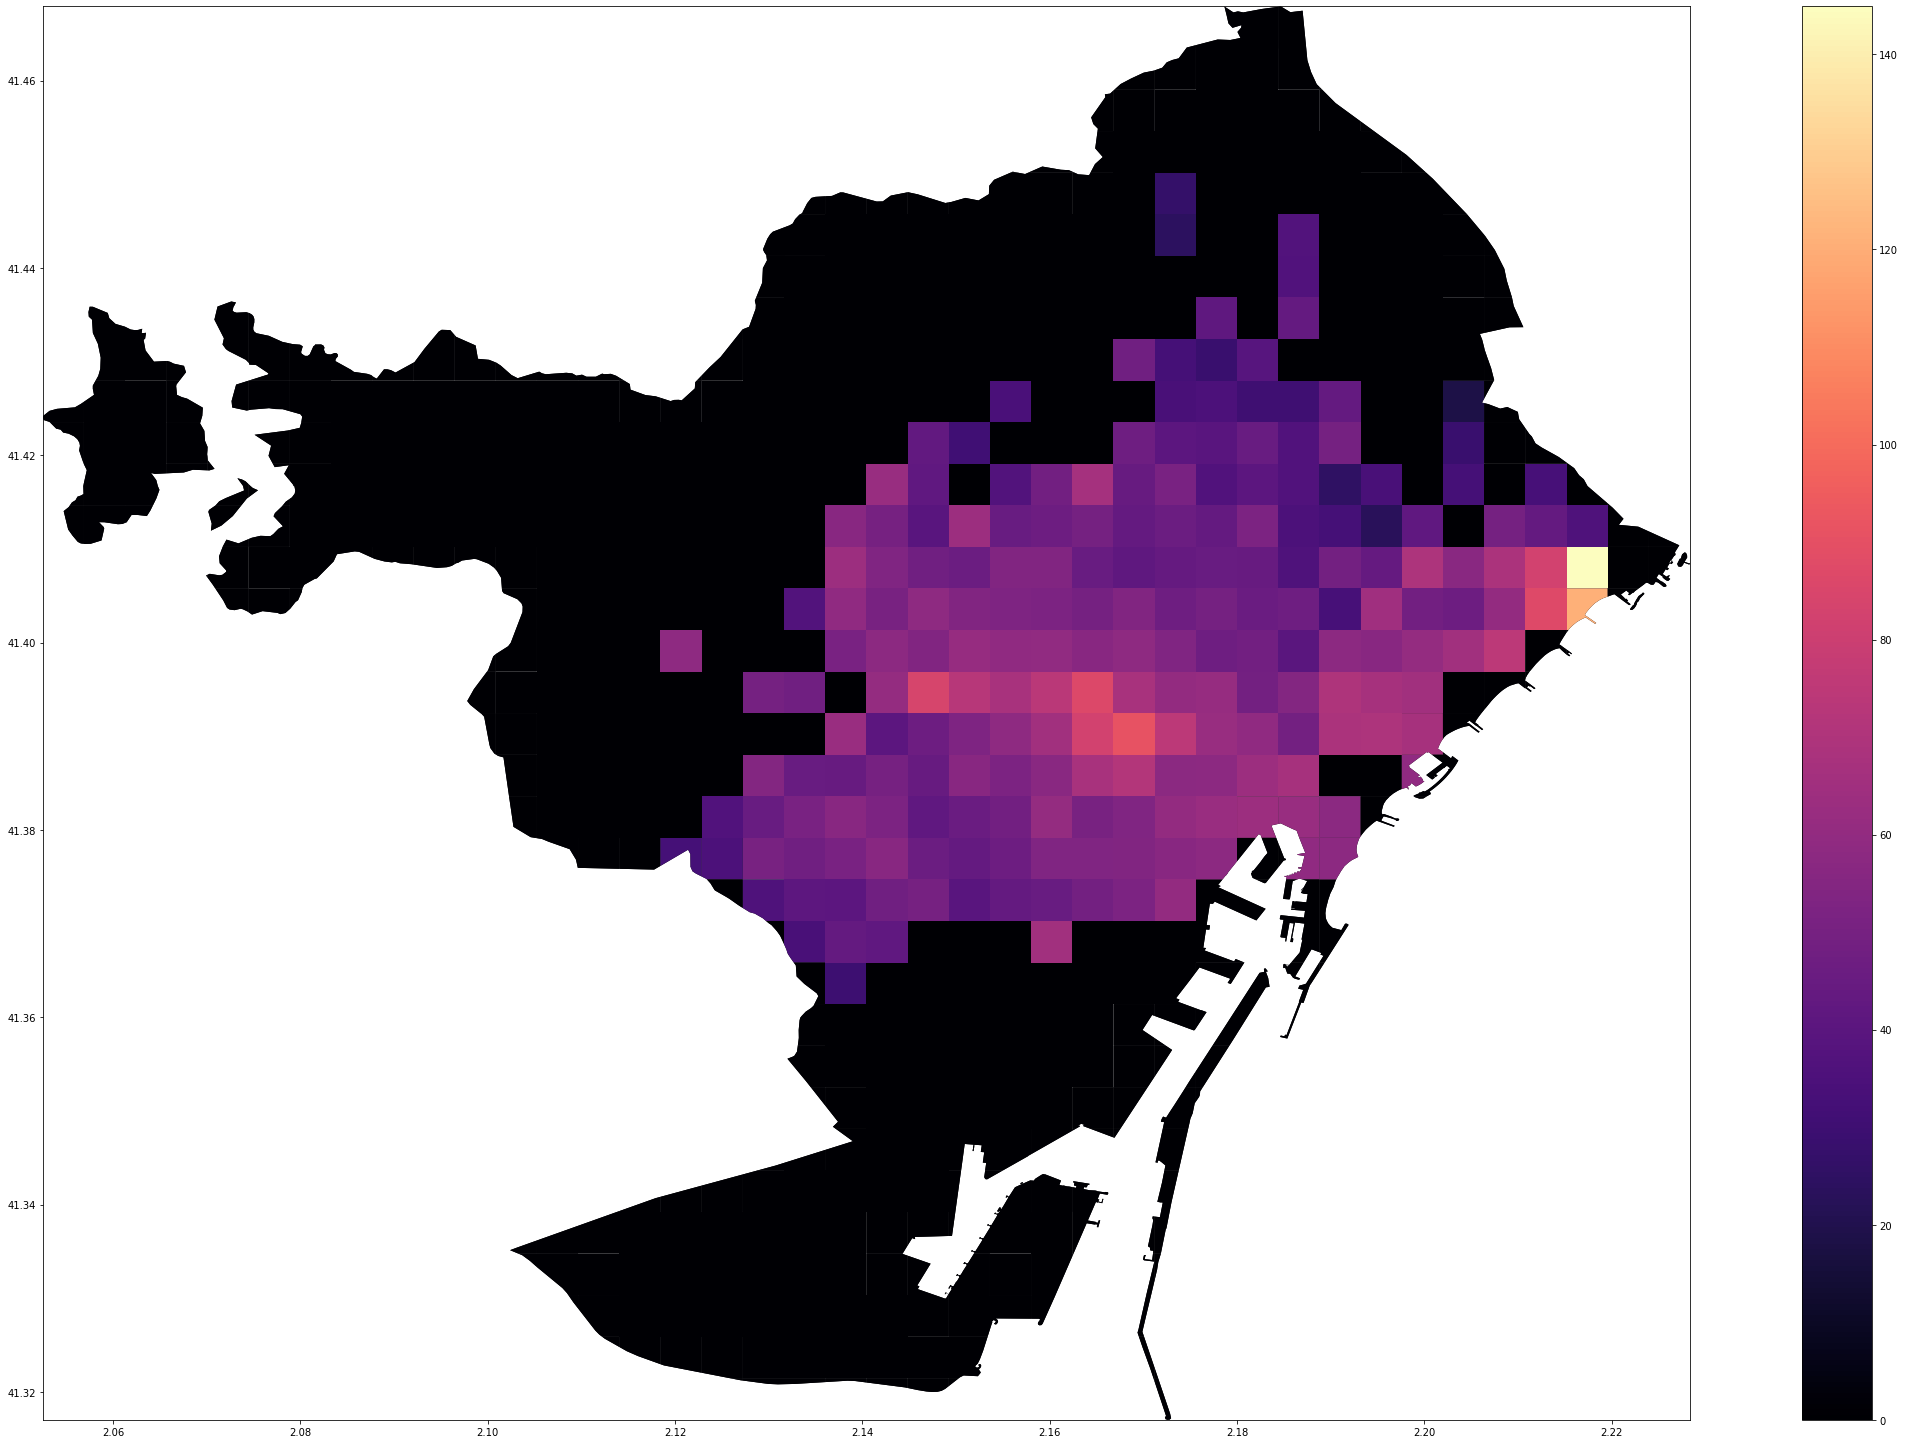

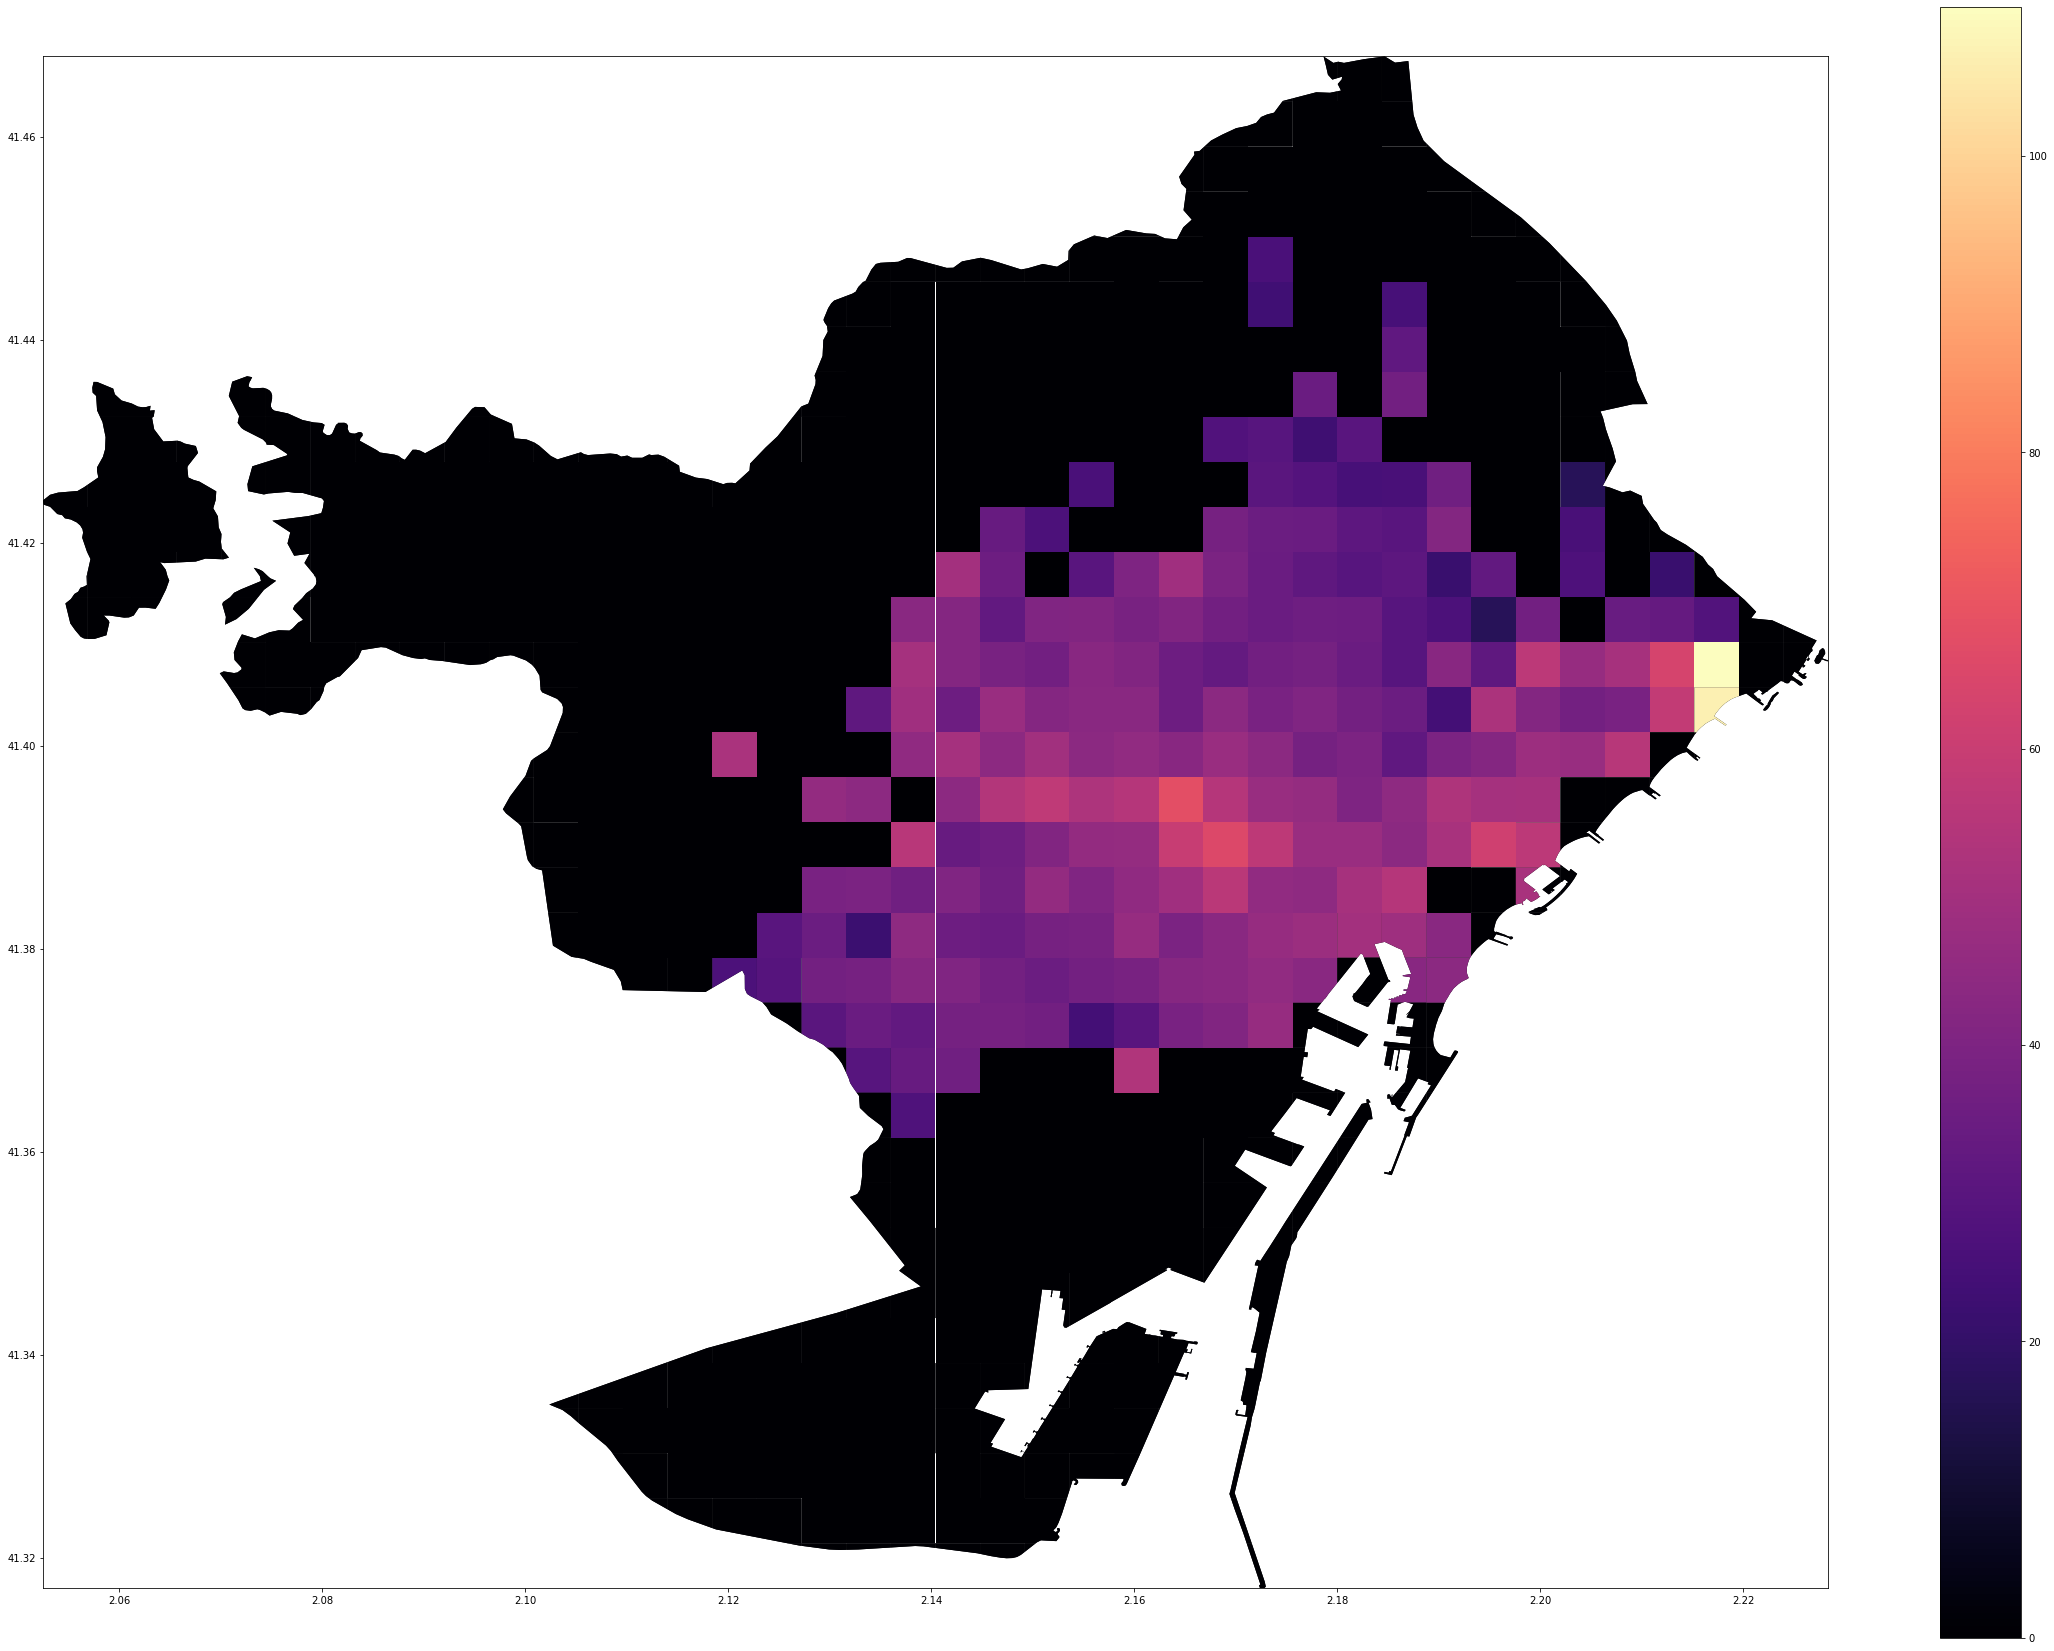

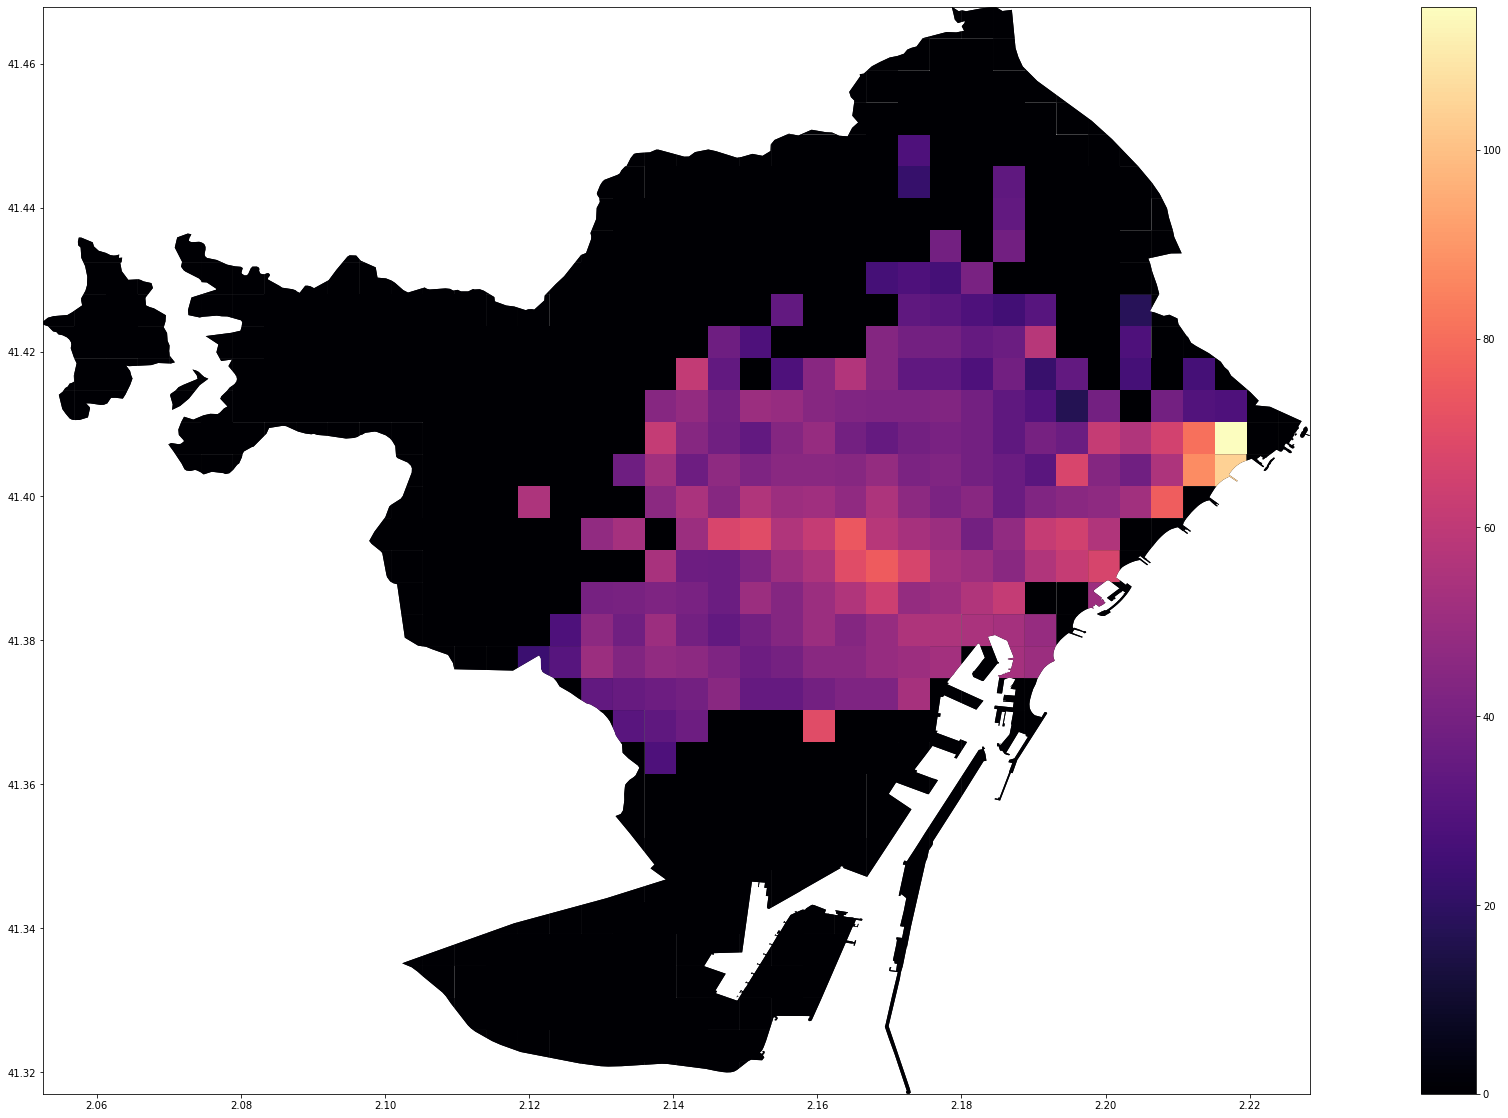

time: 7.86 s


In [3]:
data = pd.read_csv('data/Airbnb_Barcelona.csv', header=0, index_col=0)
data = data[['room_id','latitude', 'longitude', 'bedrooms', 'price']]
print(len(data))

data.reset_index(drop=True, inplace=True)
print("data max index:", data.index.max())
print("number of NA prices:", data.price.isna().sum())

data.loc[data.bedrooms == 0, 'bedrooms'] = 1

price_proom = np.divide(np.array(data[pd.notnull(data['bedrooms'])].price),np.array(data[pd.notnull(data['bedrooms'])].bedrooms))
mean_bed = np.mean(price_proom)
print("average bedroom price",mean_bed)

nan_list = data[data.bedrooms.isna()].index.tolist()
data.loc[data.bedrooms.isna(), 'bedrooms'] = np.ceil(data.loc[data.bedrooms.isna(), 'price']/mean_bed)

geometry = [Point(xy) for xy in zip(data.longitude, data.latitude)]
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)

meter_500 = 0.00899928/2


# make the geometry a multipolygon if it's not already
geometry = city['geometry'].iloc[0]
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])
    
# quadrat_width is in the units the geometry is in, so we'll do a tenth of a degree
geometry_cut = ox.quadrat_cut_geometry(geometry, quadrat_width=meter_500)

city['coords'] = city['geometry'].apply(lambda x: x.representative_point().coords[:])
city['coords'] = [coords[0] for coords in city['coords']]

polylist = [p for p in geometry_cut]

polyframe = gpd.GeoDataFrame(geometry=polylist)
polyframe.crs = city.geometry.crs
polyframe['center_lon'] = polyframe['geometry'].apply(lambda x: x.centroid.coords[0][0])
polyframe['center_lat'] = polyframe['geometry'].apply(lambda x: x.centroid.coords[0][1])


pointInPoly = gpd.sjoin(polyframe, gdf, op='contains')
print("pointinpoly length:",len(pointInPoly))

#pointInPoly.sort_values(['PlateID', 'Time'], inplace=True)
pointInPoly['index'] = pointInPoly.index
pointInPoly.reset_index(drop=True, inplace=True)


present_ind = list(pointInPoly['index_right'])
gdf_test_dropped = gdf.iloc[present_ind,:]
gdf_dropped = gdf_test_dropped.copy()
gdf_dropped.reset_index(drop=True, inplace=True)

print("check contains:",polyframe.iloc[pointInPoly.loc[len(pointInPoly)-1, 'index']].geometry.contains(gdf_dropped.loc[len(pointInPoly)-1,'geometry']))
gdf_dropped['pindex'] = pointInPoly['index']

print("check if there are NAs:", gdf_dropped.isna().values.any())

pindex = gdf_dropped.pindex.unique()
airbnb_dict = dict(gdf_dropped.pindex.value_counts())
counts = pd.DataFrame(list(airbnb_dict.items()), columns=['key', 'count'])
counts = counts[counts['count']>8]
counts = counts.copy()
airbnb_dict = dict(zip(list(counts['key']), list(counts['count'])))
polyair = polyframe.copy()
polyair['count'] = 0
polyair['count'].update(pd.Series(airbnb_dict))

# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))
polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='count',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


gdf_dropped = gdf_dropped[gdf_dropped.pindex.isin(airbnb_dict.keys())]
gdf_dropped = gdf_dropped.copy()
gdf_dropped = gdf_dropped[gdf_dropped['price'] > 0]
gdf_dropped = gdf_dropped.copy()
gdf_dropped['price_normalized'] = gdf_dropped.price.divide(gdf_dropped.bedrooms)
gdf_dropped = gdf_dropped[gdf_dropped.price_normalized<270]
gdf_dropped = gdf_dropped.copy()
gdf_dropped.reset_index(drop=True, inplace=True)
gdf_dropped.price_normalized.hist(bins=100)

prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].mean())
from scipy import stats
hmean_prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].apply(lambda x: stats.hmean(x)))
median_prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].median())

polyair['prices'] = 0
polyair['hmean_prices'] = 0
polyair['median_prices'] = 0
polyair['prices'].update(pd.Series(prices_dict))
polyair['hmean_prices'].update(pd.Series(hmean_prices_dict))
polyair['median_prices'].update(pd.Series(median_prices_dict))


# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))
polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()



# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,30))
polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='hmean_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))
polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


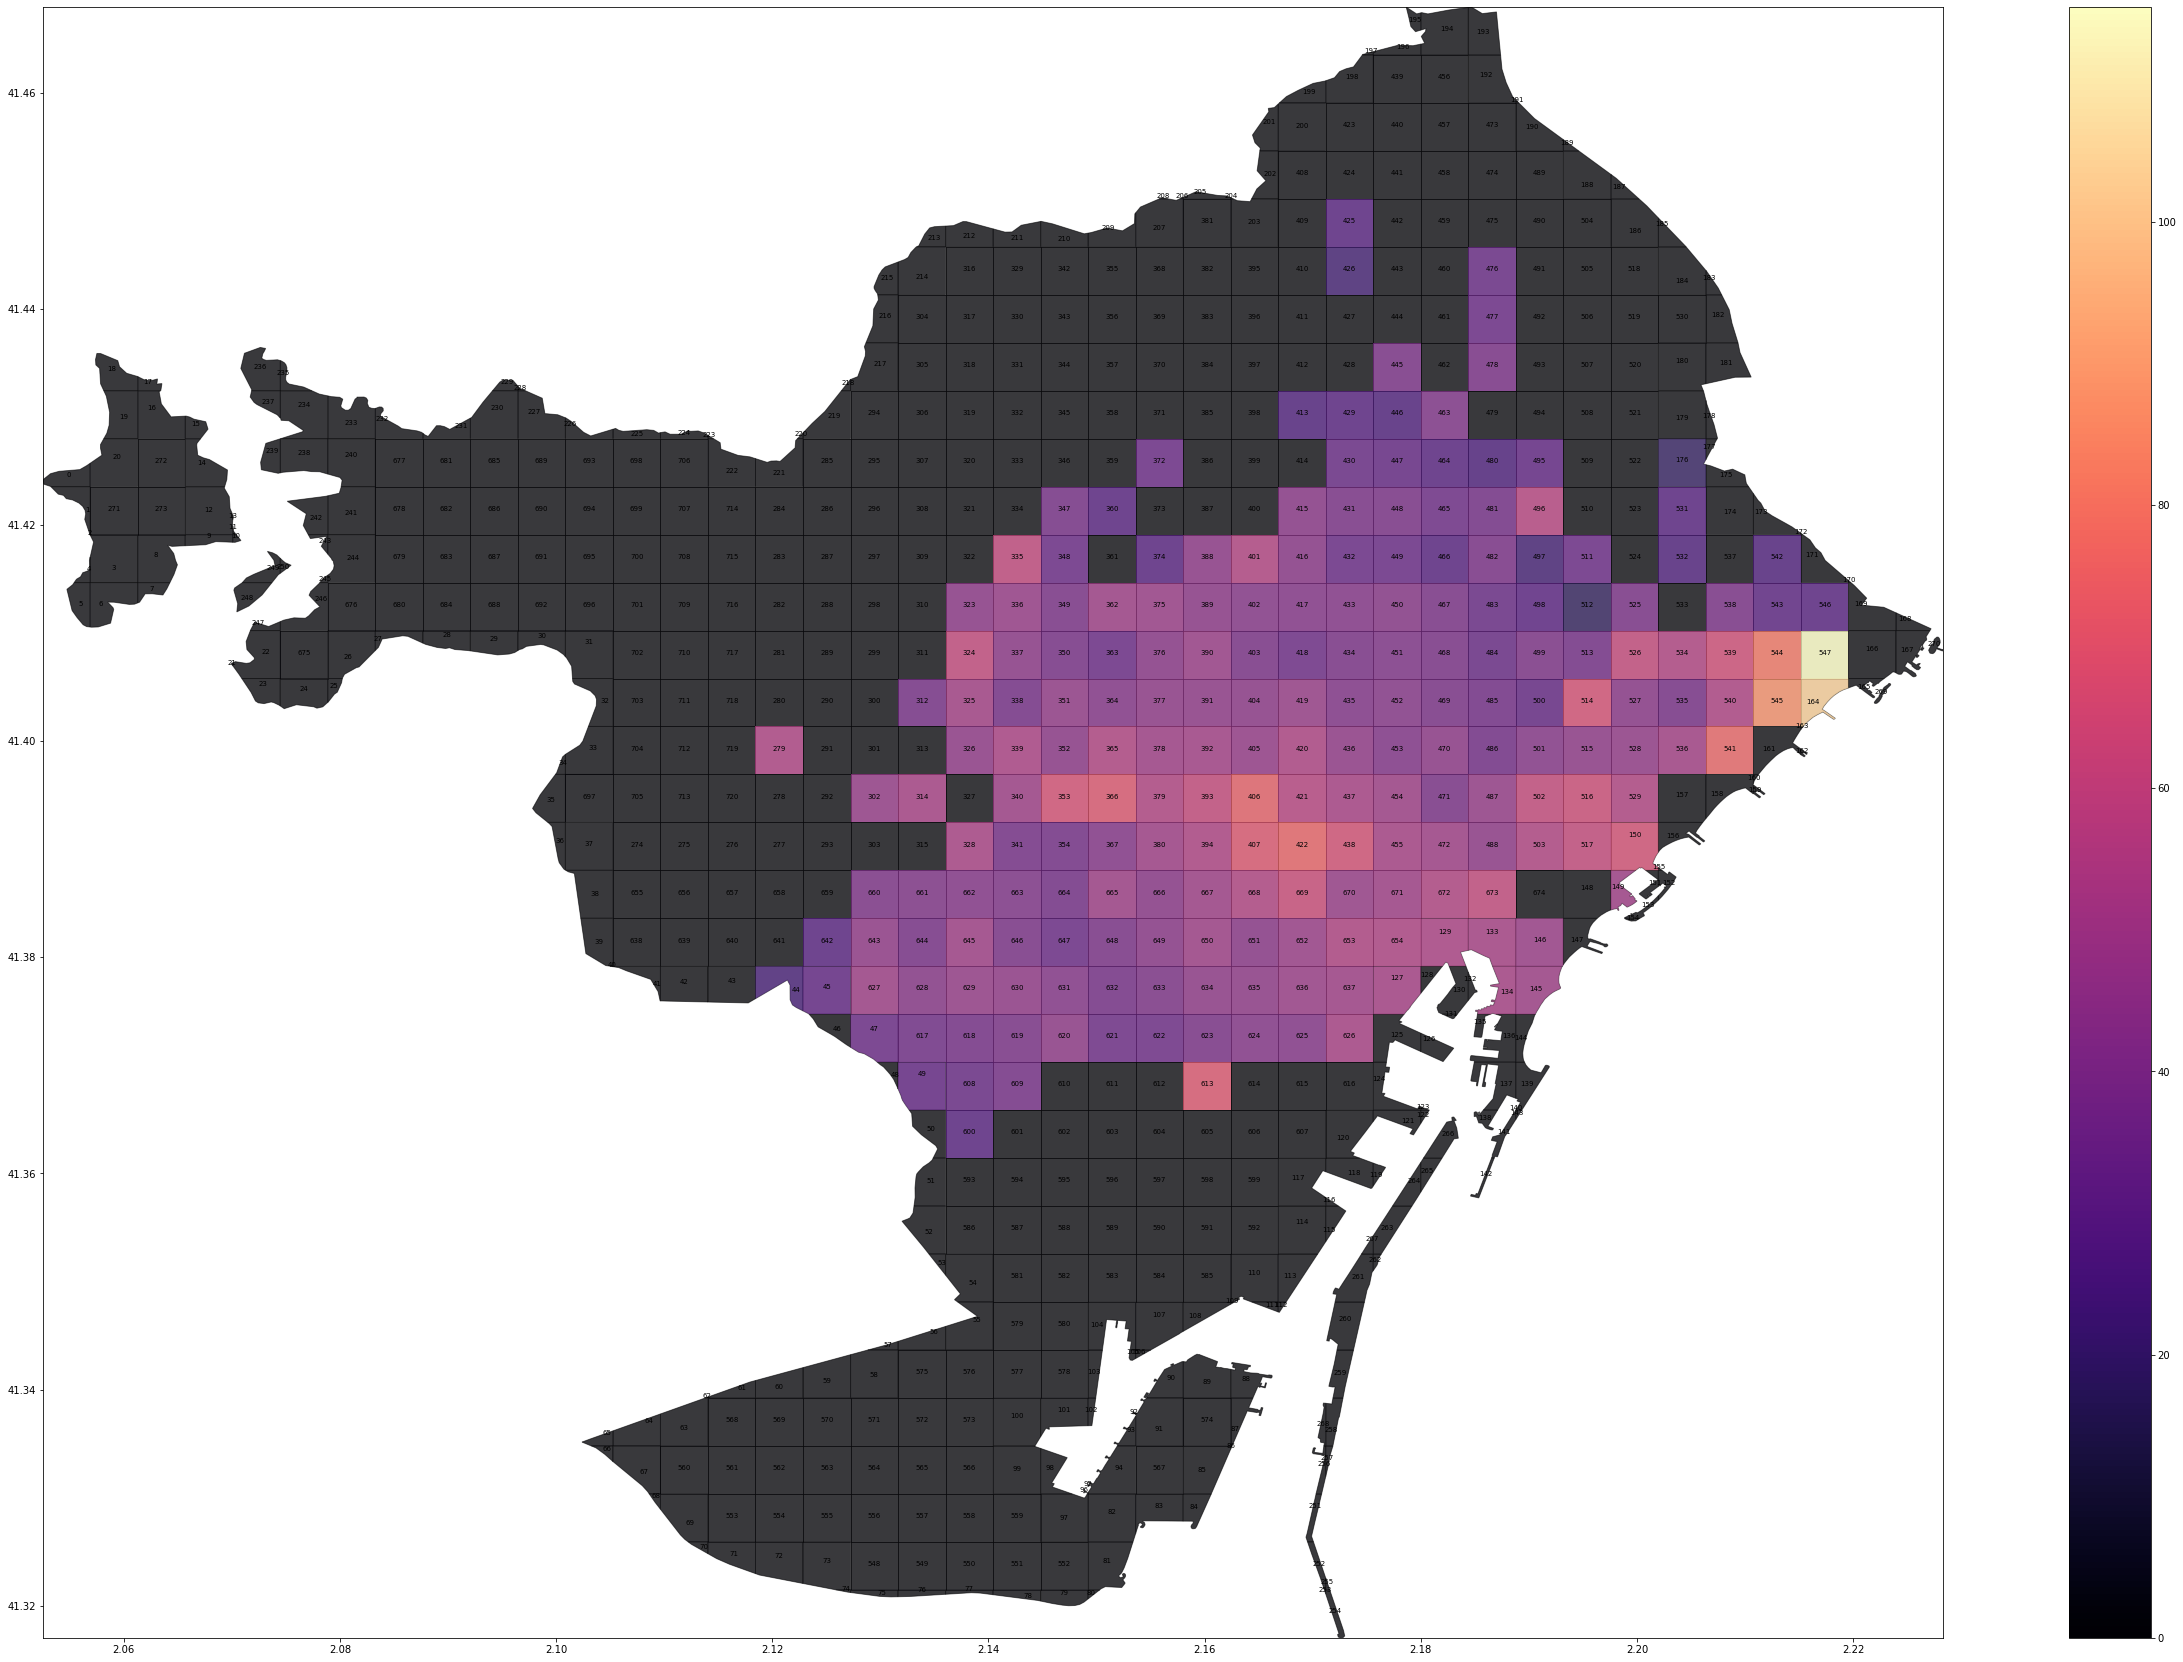

time: 7.76 s


In [4]:
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(45,30))
for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
    p = polygon.representative_point().coords[:][0]
    patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', alpha=0.5)
    ax.add_patch(patch)
    plt.annotate(s=n, xy=p,
                 horizontalalignment='center', size=7)
polyframe.plot(ax=ax, color='#000004', alpha=0.5)
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax, alpha=0.7, zorder=2)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [5]:
polyair[polyair.median_prices==polyair.median_prices.max()]

geometry  center_lon  \
547  POLYGON ((2.2151661650045 41.41022477646609, 2...    2.217364   

     center_lat  count      prices  hmean_prices  median_prices  
547   41.408006     18  144.921296    110.052323     115.166667

time: 20.7 ms


In [6]:
polyair.loc[polyair.index==613, 'median_prices'] = 30
polyair.loc[polyair.index==613, 'hmean_prices'] = 29
polyair.loc[polyair.index==613, 'prices'] = 34
polyair.loc[polyair.index==496, 'median_prices'] = 40
polyair.loc[polyair.index==496, 'hmean_prices'] = 40
polyair.loc[polyair.index==496, 'prices'] = 40

time: 17 ms


In [7]:
polyair.loc[polyair.index==335, 'median_prices'] = 30
polyair.loc[polyair.index==335, 'hmean_prices'] = 29
polyair.loc[polyair.index==335, 'prices'] = 34
polyair.loc[polyair.index==401, 'median_prices'] = 34
polyair.loc[polyair.index==401, 'hmean_prices'] = 34
polyair.loc[polyair.index==401, 'prices'] = 34

time: 19 ms


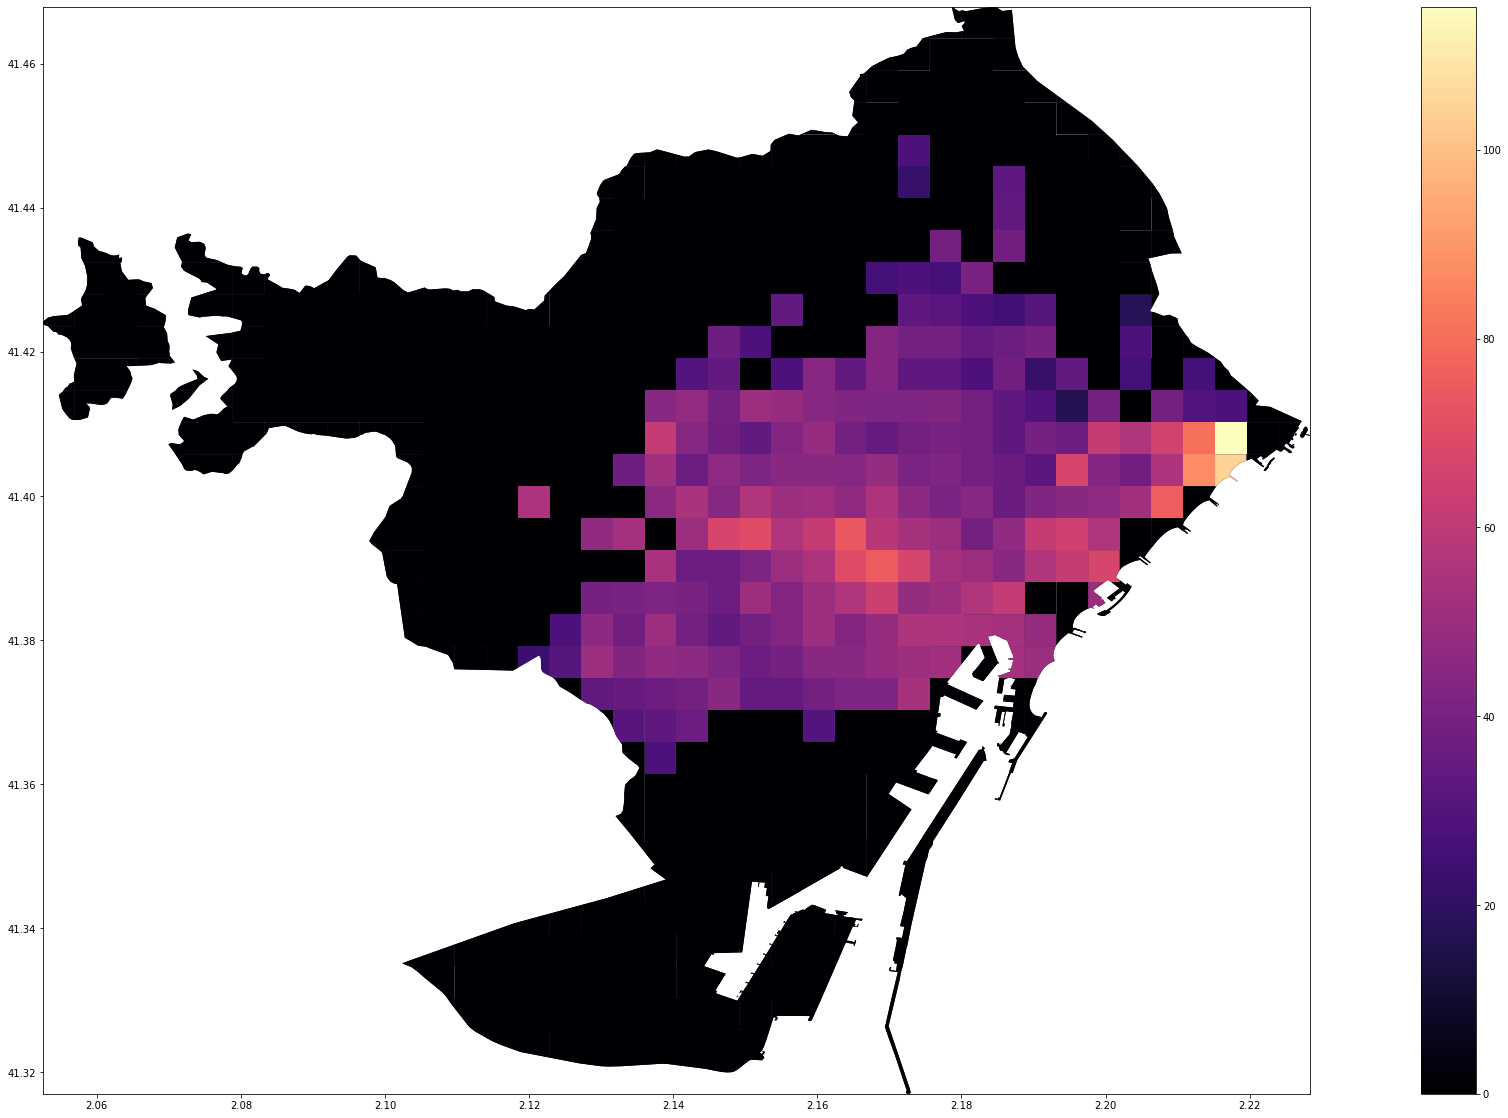

time: 1.32 s


In [8]:
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

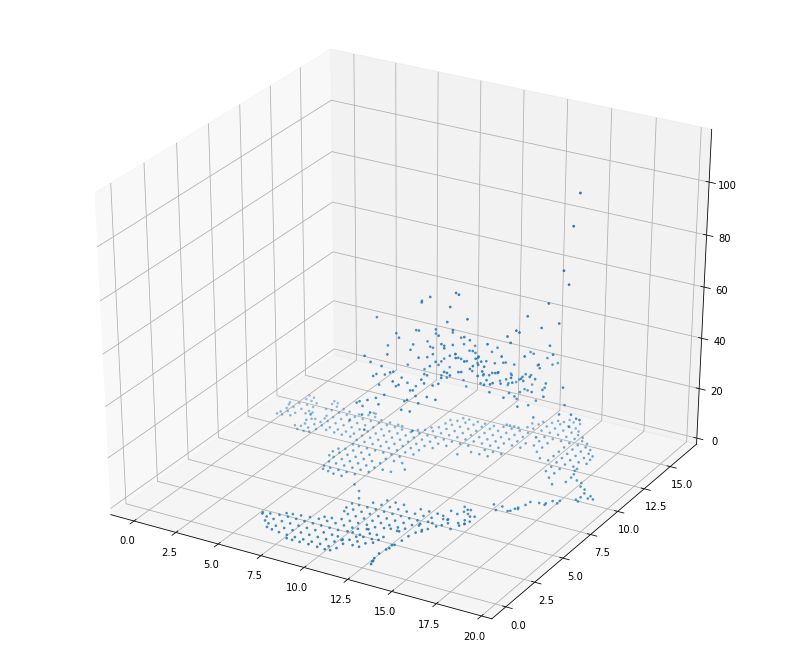

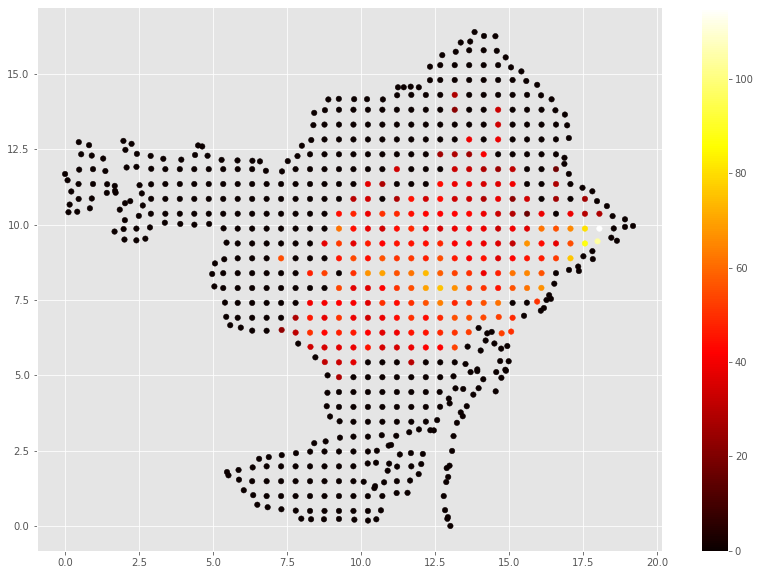

time: 2.27 s


In [9]:
import plotly.plotly as py
import plotly.graph_objs as go

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
from mpl_toolkits.mplot3d import Axes3D
#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)

x = np.array(polyair.center_lon)*500/meter_500
x = x-x.min()
x = x/1000

y = np.array(polyair.center_lat)*500/meter_500 
y = y-y.min()
y = y/1000


# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, np.array(polyair.median_prices), cmap='plasma', s=3)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(30, 300)
plt.show()


plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(14,10))
scat = ax.scatter(x, y, c=np.array(polyair.median_prices), s=30, cmap='hot')
cbar = fig.colorbar(scat)
#cbar.set_clim(0, 250)
plt.savefig('images/Barcelona_observed.jpg')
plt.show()

In [10]:
cdf = polyair[polyair.index.isin([366, 422, 547, 516, 463])]
cdf["cen_lon_km"] = cdf['center_lon'].apply(lambda x: (x*500/meter_500 - (polyair.center_lon*500/meter_500).min())/1000)
cdf["cen_lat_km"] = cdf['center_lat'].apply(lambda x: (x*500/meter_500 - (polyair.center_lat*500/meter_500).min())/1000)
cdf

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



geometry  center_lon  \
366  POLYGON ((2.1492194900045 41.39691199411315, 2...    2.151418   
422  POLYGON ((2.1668052700045 41.3924743999955, 2....    2.169003   
463  POLYGON ((2.1799946050045 41.43241274705433, 2...    2.182193   
516  POLYGON ((2.193183940004499 41.39691199411315,...    2.195382   
547  POLYGON ((2.2151661650045 41.41022477646609, 2...    2.217364   

     center_lat  count      prices  hmean_prices  median_prices  cen_lon_km  \
366   41.394693     63   72.978571     57.502322      70.000000   10.713656   
422   41.390256     79   90.853024     65.761898      75.500000   12.667788   
463   41.430194     16   38.739583     29.734002      40.750000   14.133387   
516   41.394693     37   67.336036     50.606754      65.000000   15.598986   
547   41.408006     18  144.921296    110.052323     115.166667   18.041651   

     cen_lat_km  
366    8.387698  
422    7.894592  
463   12.332541  
516    8.387698  
547    9.867014

time: 225 ms


Fitted parameters:
[ 7.85033721e+00  1.03877244e+01  7.80203183e+00  1.96945252e+00
  2.65528439e+00  5.59679527e+05  1.12108567e+01  4.33269841e+01
  1.26540287e+01  8.74513689e+00  3.44494017e+00  2.14856037e+00
  2.76135404e+00  3.08022862e+00  9.53398327e+01  1.76938707e+01
  9.76576975e+00  5.16693220e-01  3.93943316e-01 -3.53385971e+00
  3.00780932e+00]
RMS residual = 10.272881321096978


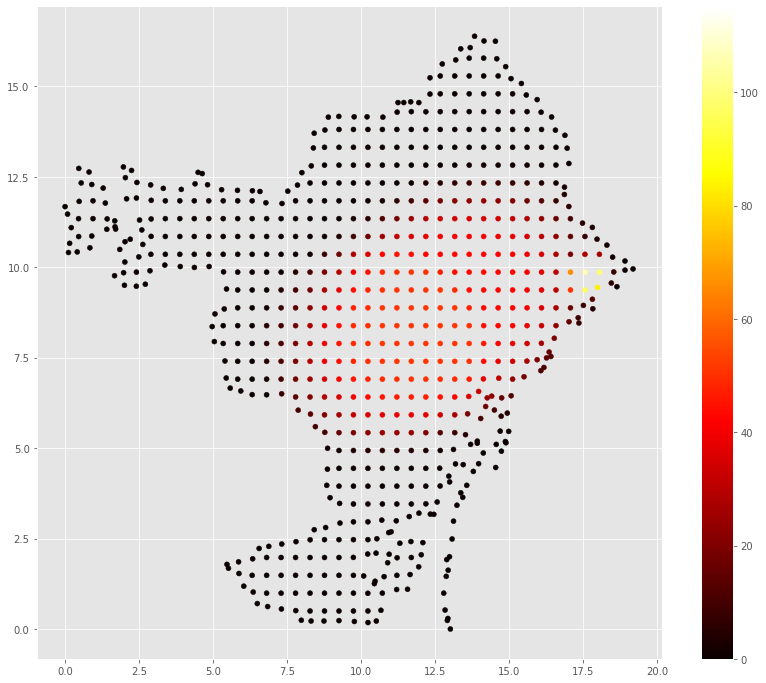

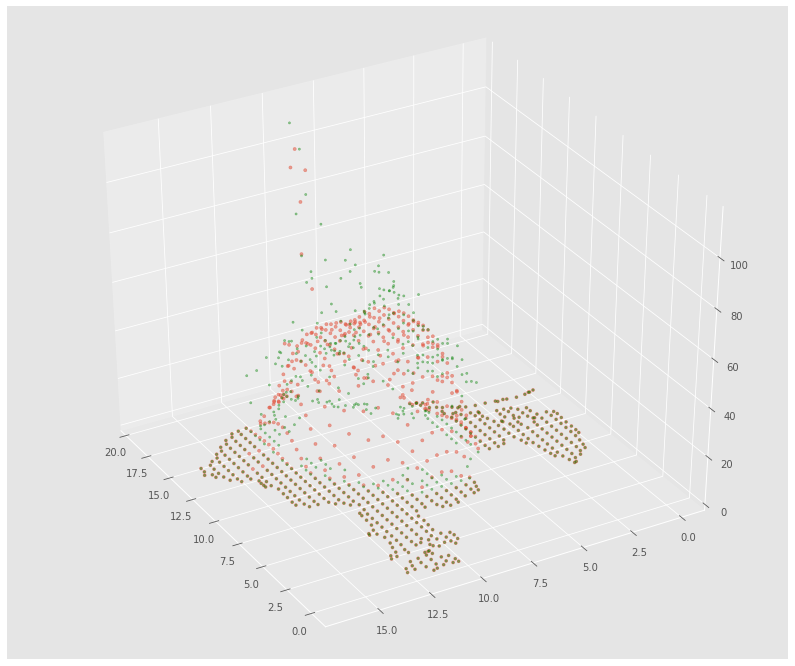

{'Barcelona': 5.7662982238911376}
time: 1.9 s


In [11]:
alphas = {}
xy = np.vstack([x, y])
zobs = np.array(polyair.median_prices)
#zobs = np.where(zobs>0, zobs, 0.1*zobs.max())
import scipy.optimize as opt
import matplotlib.pyplot as plt

def _gaussian(M, *args):
    xy = M
    arr = np.zeros(len(zobs))
    for i in range(len(args)//7):
        arr += twoD_Gaussian_alpha(xy, *args[i*7:i*7+7])
    return arr




guess_prms = [(70,10.713656,8.387698, 2, 2,0.5, 1.5),
              (75.5,12.667788,7.894592, 4, 3,1.87, 1.8),
              #(40.75,14.133387,12.332541, 1, 2,0.87),
              (65,15.598986,8.387698, 1, 1,0.87, 1.5),
              #(115.16,18.041651,9.867014, 0.5, 1,1.87, 1.1)
             ]

# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

def twoD_Gaussian_alpha(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, alpha):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2))**alpha)
    return g.ravel()
popt, pcov = opt.curve_fit(_gaussian, xy, zobs, p0)
#pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)

zpred = np.zeros(len(zobs))
for i in range(len(popt)//7):
    zpred += twoD_Gaussian_alpha(xy, *popt[i*7:i*7+7])

# for i in range(len(popt)//5):
#     fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((zobs - zpred)**2))
print('RMS residual =', rms)


fig, ax = plt.subplots(figsize=(14,12))
scat = ax.scatter(x, y, c=zpred, vmin=0, vmax=zobs.max(), s=25, cmap='hot')
fig.colorbar(scat)
plt.savefig('Barcelona_fitted.jpg')
plt.show()


#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, zpred, cmap='plasma', s=10, alpha=0.5)
ax.scatter(x, y, zobs, color='green', s=5, alpha=0.4)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(35, 150)
plt.show()

alphas['Barcelona'] = np.mean(popt[6::7])
print(alphas)

In [12]:
import pickle
pickle_in = open("alphas.pickle","rb")
alphas_dict = pickle.load(pickle_in)
#prices_params_dict = {}
alphas_dict['Barcelona'] = 1.12108567
print(alphas_dict)
pickle_out = open("alphas.pickle","wb")
pickle.dump(alphas_dict, pickle_out)
pickle_out.close()

{'Paris': 1.9119263949210794, 'Amsterdam': 1.6077156181165682, 'Stockholm': 1.4869621148124246, 'Arezzo': 1.5291330654483044, 'Berlin': 1.3281036059479567, 'Bordeaux': 1.387341915093677, 'Denver': 0.9886695315944182, 'Edinburgh': 1.7431661910906637, 'Lyon': 1.840995035260712, 'Madrid': 1.561423826026336, 'Buenos_Aires': 2.0626361633770363, 'Los_Angeles': 1.7386638625850566, 'Beijing': 1.77233254047711, 'Florence': 1.052999973906332, 'Moscow': 1.822610958759147, 'Porto': 1.4172416677632145, 'Prague': 1.3671832768992007, 'Reykjavik': 1.4194582940670377, 'Riga': 1.4587192546215861, 'Rome': 1.8608390724186512, 'Seoul': 1.3208669147673713, 'Siena': 0.6212787996336754, 'Sydney': 2.584174464016137, 'Tallin': 2.014994948135572, 'Treviso': 1.07320426583068, 'Valencia': 1.5432619, 'Venezia': 1.3156028460923, 'Verona': 1.4364606330705336, 'Vicenza': 1.20971848439062, 'Vienna': 1.3399164167136137, 'Wellington': 1.46363348, 'Zurich': 1.72383878, 'Aarhus': 1.87621535, 'Milan': 2.1468310347956194, 'B

Fitted parameters:
[ 3.97614339e+01  9.41324099e+00  8.34628423e+00  8.26937222e-01
  2.28111259e+00 -5.37343933e+05  6.01568346e+01  1.23929446e+01
  8.84399835e+00  1.28843746e+00  2.56211202e+00  6.34498869e-01
  5.82438174e+01  1.54334264e+01  8.48362705e+00  6.69853088e-01
  2.26576265e+00  8.81557204e-01  5.55825070e+02  1.77853991e+01
  9.64398506e+00  2.01841048e-01  1.36447387e-01  2.88050832e+00]
RMS residual = 9.913560232773824


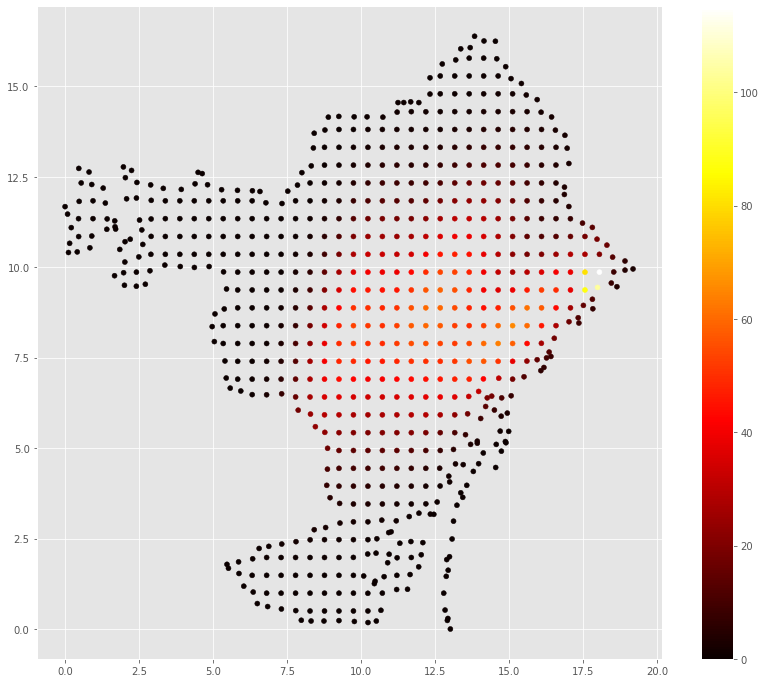

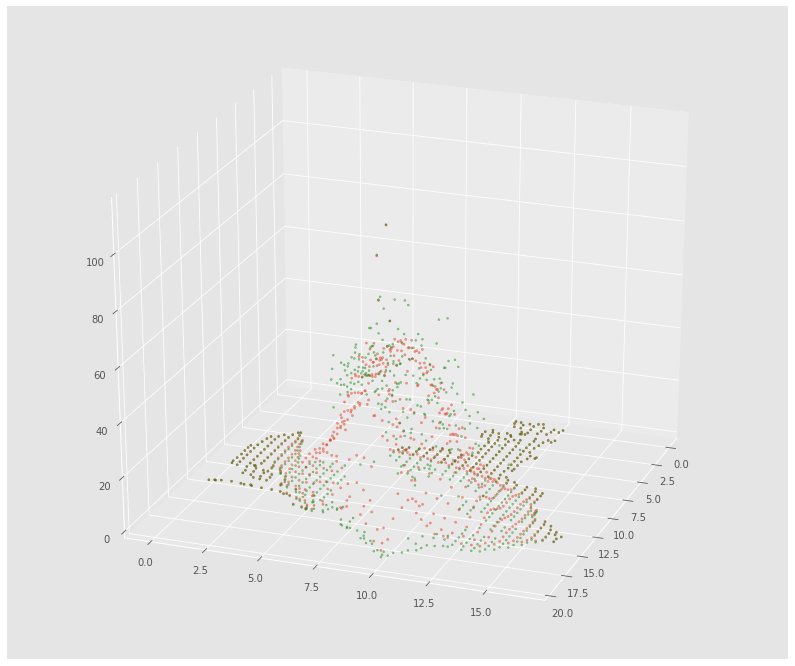

time: 1.45 s


In [13]:
xy = np.vstack([x, y])
zobs = np.array(polyair.median_prices)
#zobs = np.where(zobs>0, zobs, 0.1*zobs.max())
import scipy.optimize as opt
import matplotlib.pyplot as plt

def _gaussian(M, *args):
    xy = M
    arr = np.zeros(len(zobs))
    for i in range(len(args)//6):
        arr += twoD_Gaussian(xy, *args[i*6:i*6+6])
    return arr



guess_prms = [(70,10.713656,8.387698, 2, 2,0.5),
              (75.5,12.667788,7.894592, 2, 3,0.87),
              #(40.75,14.133387,12.332541, 1, 2,0.87),
              (65,15.598986,8.387698, 1, 1,0.87),
              (115.16,18.041651,9.867014, 1, 1,1.87)
             ]

# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()
popt, pcov = opt.curve_fit(_gaussian, xy, zobs, p0)
#pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)

zpred = np.zeros(len(zobs))
for i in range(len(popt)//6):
    zpred += twoD_Gaussian(xy, *popt[i*6:i*6+6])

# for i in range(len(popt)//5):
#     fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((zobs - zpred)**2))
print('RMS residual =', rms)


fig, ax = plt.subplots(figsize=(14,12))
scat = ax.scatter(x, y, c=zpred, vmin=0, vmax=zobs.max(), s=25, cmap='hot')
fig.colorbar(scat)
plt.savefig('Barcelona_fitted.jpg')
plt.show()


#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, zpred, cmap='plasma', s=5, alpha=0.5)
ax.scatter(x, y, zobs, color='green', s=4, alpha=0.4)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(25, 20)
plt.show()

In [14]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

sqrt_eigs_long = np.array([])
sqrt_eigs_short = np.array([])
for i in range(0, len(popt), 6):
    a = (np.cos(popt[i+5])**2)/(2*popt[i+3]**2) + (np.sin(popt[i+5])**2)/(2*popt[i+4]**2)
    b = -(np.sin(2*popt[i+5]))/(4*popt[i+3]**2) + (np.sin(2*popt[i+5]))/(4*popt[i+4]**2)
    c = (np.sin(popt[i+5])**2)/(2*popt[i+3]**2) + (np.cos(popt[i+5])**2)/(2*popt[i+4]**2)
    cov = np.array([a, b, b, c]).reshape(-1, 2)
    print("Is cov_{} positive definite?: ".format(i//6+1), is_pos_def(cov))
    eigenvalues = np.linalg.eigvals(cov)
    eigenvalues = eigenvalues[eigenvalues>0]
    if eigenvalues.size!=0:
        stds = np.sqrt(eigenvalues)/popt[i]
        #stds = stds[stds>=0]
        sqrt_eigs_long = np.append(sqrt_eigs_long,max(stds))
        sqrt_eigs_short = np.append(sqrt_eigs_short,min(stds))

print('long stds: ', sqrt_eigs_long, 'mean: ', np.mean(sqrt_eigs_long))
print('short stds: ', sqrt_eigs_short, 'mean: ', np.mean(sqrt_eigs_short))

Is cov_1 positive definite?:  True
Is cov_2 positive definite?:  True
Is cov_3 positive definite?:  True
Is cov_4 positive definite?:  True
long stds:  [0.02150554 0.00912298 0.01812406 0.00932356] mean:  0.014519036229551547
short stds:  [0.00779608 0.00458777 0.00535822 0.00630286] mean:  0.006011232672304886
time: 40 ms


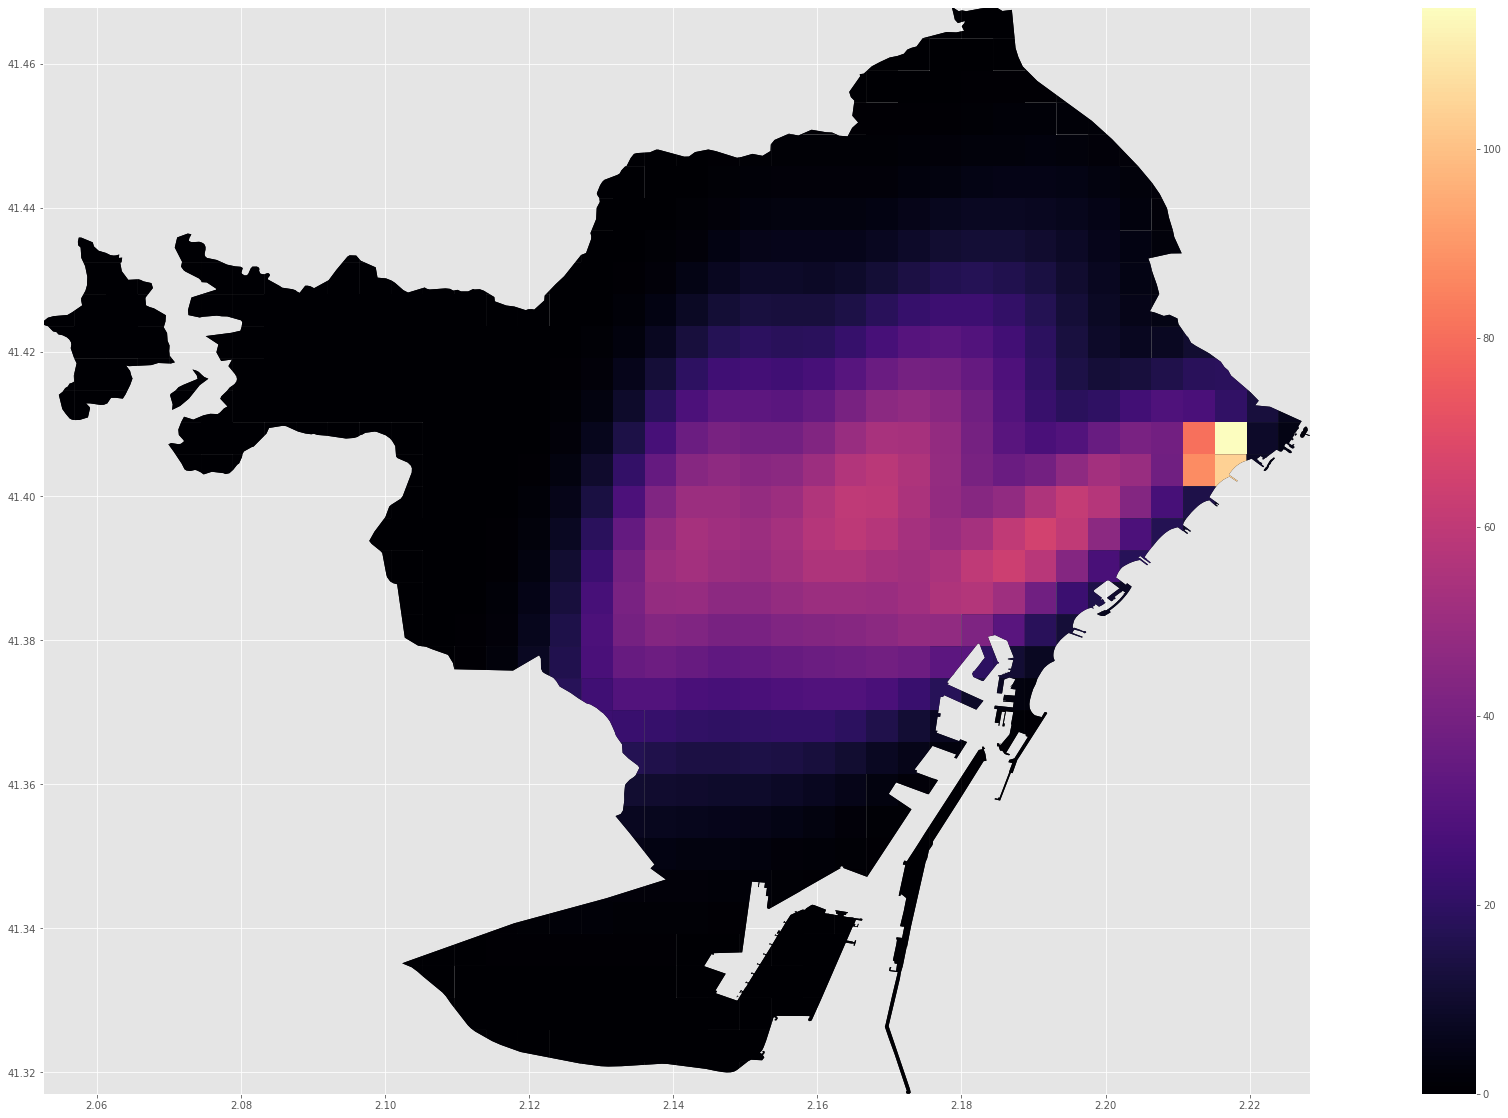

time: 1.23 s


In [15]:
polyair['zpred'] = zpred
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='zpred',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [16]:
import pickle
pickle_in = open("Prices_params.pickle","rb")
prices_params_dict = pickle.load(pickle_in)
#prices_params_dict = {}
prices_params_dict['Barcelona'] = popt
pickle_out = open("Prices_params.pickle","wb")
pickle.dump(prices_params_dict, pickle_out)
pickle_out.close()

#average_slopes = {}
pickle_in_long = open("Average_price_slopes_long.pickle","rb")
average_slopes_long = pickle.load(pickle_in_long)
average_slopes_long['Barcelona'] = np.mean(sqrt_eigs_long)
pickle_out_long = open("Average_price_slopes_long.pickle","wb")
pickle.dump(average_slopes_long, pickle_out_long)
pickle_out_long.close()

pickle_in_short = open("Average_price_slopes_short.pickle","rb")
average_slopes_short = pickle.load(pickle_in_short)
average_slopes_short['Barcelona'] = np.mean(sqrt_eigs_short)
pickle_out_short = open("Average_price_slopes_short.pickle","wb")
pickle.dump(average_slopes_short, pickle_out_short)
pickle_out_short.close()

print('long: ', average_slopes_long, '\n', '\n', ' short: ', average_slopes_short)

long:  {'Paris': 0.010453121182320417, 'Amsterdam': 0.017790862401138207, 'Stockholm': 0.01160078748441716, 'Arezzo': 0.012661960610292892, 'Berlin': 0.017168942092868542, 'Bordeaux': 0.0057209390468692745, 'Denver': 0.00873766709683174, 'Edinburgh': 0.012921100209712873, 'Lyon': 0.00594530194011358, 'Madrid': 0.01315080289968449, 'Buenos_Aires': 0.00938788752473718, 'Palermo': 0.02659431146972356, 'Los_Angeles': 0.0056655377791732745, 'Beijing': 0.03548021455387483, 'Florence': 0.011913882705309832, 'Moscow': 0.026524810524746, 'Porto': 0.03745056113103571, 'Prague': 0.01850581507565583, 'Reykjavik': 0.04000475004839031, 'Riga': 0.02150786435094239, 'Rome': 0.009635062558537275, 'Seoul': 0.013154650694260608, 'Siena': 0.013838139160990736, 'Sydney': 0.009200022664460229, 'Tallin': 0.024848430854086192, 'Treviso': 0.015264513943951563, 'Valencia': 0.01982718757582555, 'Venezia': 0.013133572970121148, 'Verona': 0.01119208328282184, 'Vicenza': 0.029546407262138693, 'Vienna': 0.0120270170

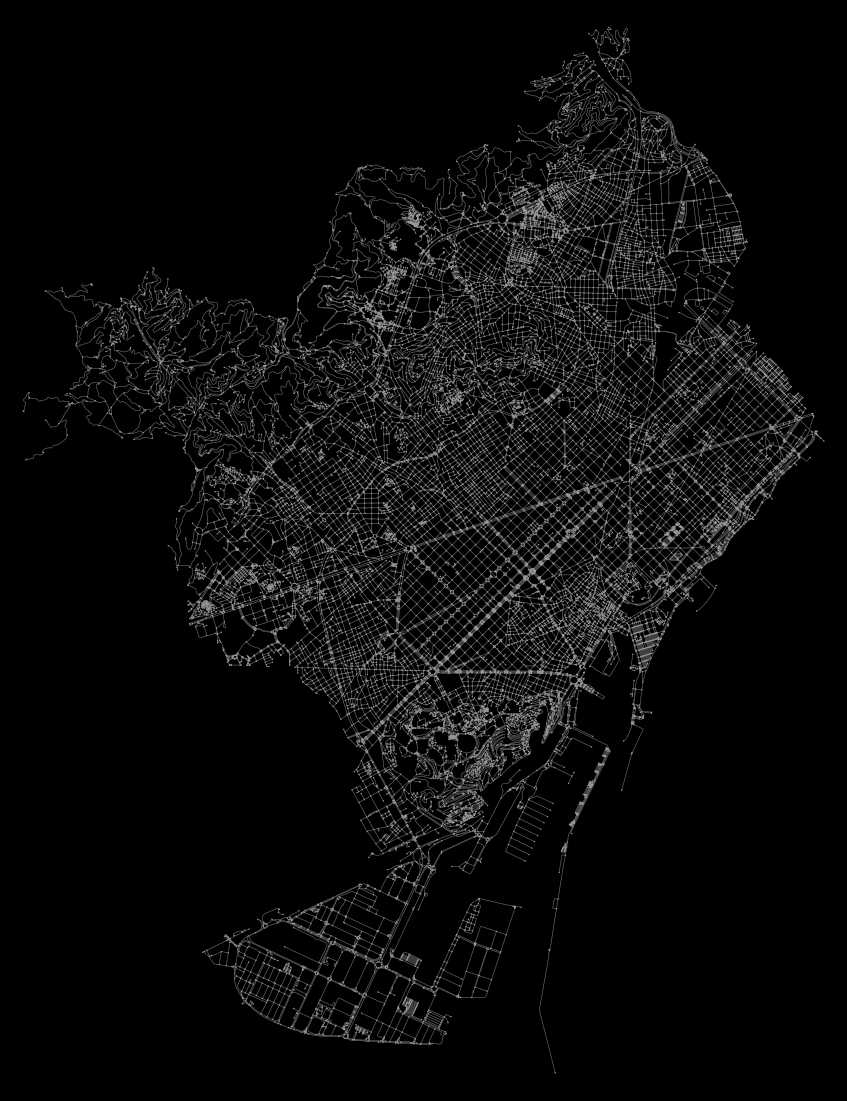

time: 1min 15s


In [17]:
# download and project a street network
G = ox.graph_from_place('Barcelona, Spain', network_type="walk")
#G = ox.project_graph(G)
fig, ax = ox.plot_graph(G, fig_height=20, bgcolor='k', node_size=2, node_color='#999999', node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=0.5, edge_alpha=1)

In [18]:
centers = {}
for i in range(0, len(popt), 6):
    lon = popt[i+1]*1000 + (np.array(polyair.center_lon)*500/meter_500).min()
    lon = lon*meter_500/500
    lat = popt[i+2]*1000 + (np.array(polyair.center_lat)*500/meter_500).min()
    lat = lat*meter_500/500
    centers['center_node_{}'.format(i//6+1)] = ox.get_nearest_node(G, (lat,lon))

centers

{'center_node_1': 6283516223,
 'center_node_2': 1124790711,
 'center_node_3': 1710758987,
 'center_node_4': 5393693743}

time: 193 ms


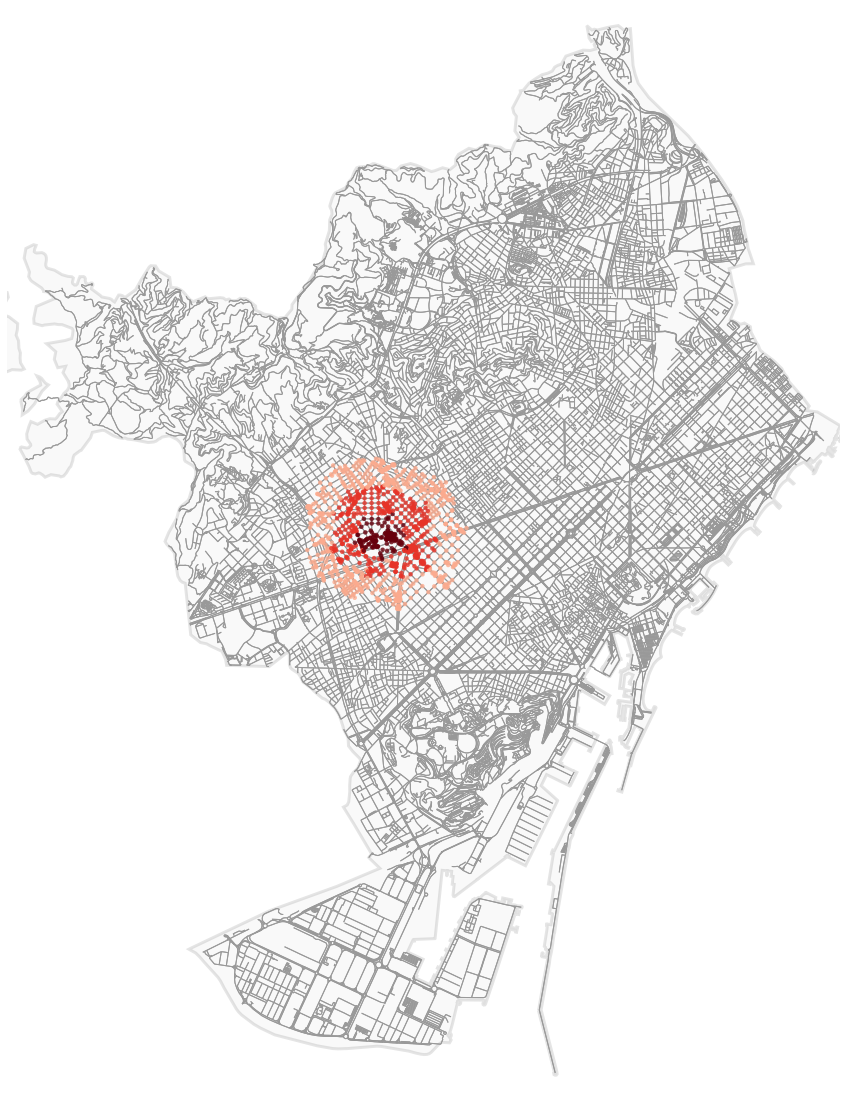

time: 13.6 s


In [19]:
import networkx as nx
#center_node = ox.get_nearest_node(G, (popt[8],popt[7]))
center_node = centers['center_node_1']
# list of distances from center
dists = np.arange(500, 2000, 500)
dists

# get one color for each isochrone
iso_colors = ox.get_colors(n=len(dists), cmap='Reds', start=0.3, return_hex=True)
# color the nodes according to isochrone then plot the street network
node_colors = {}
for dist, color in zip(sorted(dists, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=dist, distance='length')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, fig_height=20,show=False, close=False, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)
plt.close()
# to this matplotlib axis, add the place shape as descartes polygon patches
for geometry in city['geometry'].tolist():
    if isinstance(geometry, (Polygon, MultiPolygon)):
        if isinstance(geometry, Polygon):
            geometry = MultiPolygon([geometry])
        for polygon in geometry:
            patch = PolygonPatch(polygon, fc='#cccccc', ec='k', linewidth=3, alpha=0.1, zorder=-1)
            ax.add_patch(patch)
            
fig

721
721 254
Number of cells with price above 5th percentile:  254



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Yes


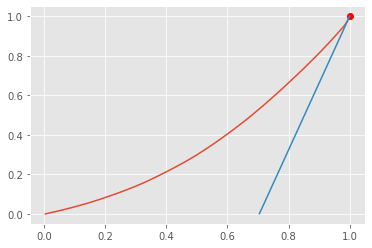

Loubar price:  45.50188738363441
Average price:  34.61534855878736
average city distance:  4218.232625020259
eta =  0.6785179485273953
time: 3.06 s


In [21]:
from tqdm import tqdm_notebook

#poly_prices = polyair[polyair.median_prices>0]
poly_prices = polyair.copy()
print(len(poly_prices))
poly_prices['zpred'] = zpred

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)

vals_cut = vals[vals>0.1*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.1*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))



mat = np.zeros(shape=(len(geometry_cut), len(geometry_cut)))
for pair in tqdm_notebook(combinations(sorted(keys), 2)):
    mat[pair[0], pair[1]] = geometry_cut[pair[0]].centroid.distance(geometry_cut[pair[1]].centroid)
    
print(mat)


def isuppertriangular(M): 
    for i in range(1, len(M)): 
        for j in range(0, i): 
            if(M[i][j] != 0):  
                    return False
    return True

  
if isuppertriangular(mat): 
    print ("Yes") 
else: 
    print ("No") 
    
    
L1= L
F1 = np.arange(1, len(L1)+1)/len(L1)

L1 = (L1 - L1.min())/(L1.max()-L1.min())

from scipy import interpolate
tck = interpolate.splrep(F1,L1)
x0_1 =1
y0_1 = interpolate.splev(x0_1,tck)
dydx = interpolate.splev(x0_1,tck,der=1)
tngnt1 = lambda x: dydx*x + (y0_1-dydx*x0_1)
plt.plot(F1, L1)
plt.plot(x0_1,y0_1, "or")
plt.plot(F1[tngnt1(F1)>0],tngnt1(F1[tngnt1(F1)>0]), label="tangent")
plt.show()

indlist = poly_prices.index.tolist()

loubar_val = vals_cut[np.where(tngnt1(F1)>0)[0][0]]

print('Loubar price: ', loubar_val)
print('Average price: ', np.mean(vals_cut))

if loubar_val > np.mean(vals_cut):
    loubar_keys = keys[vals_cut>loubar_val]
else:
    loubar_keys = keys[vals_cut>np.mean(vals_cut)]
#loubar_keys = keys[vals_cut>loubar_val]
dist_mat = mat[keys.reshape(-1,1), keys]

total_dist = dist_mat.sum()
dist_corr = dist_mat[dist_mat>0]

loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]
loubar_dist = loubar_dist_mat.sum()

loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
eta_loubar = loubar_dist_corr.mean()/dist_corr.mean()

x = np.array(polyair.center_lon)*500/meter_500
x = x-x.min()
x = x/1000

avg_dist_meters = (dist_corr.mean()/0.00899928)*1000
print('average city distance: ', avg_dist_meters)
print('eta = ', eta_loubar)

In [22]:
pickle_in = open("City_spreading_index.pickle","rb")
spreading_index_dict = pickle.load(pickle_in)
#spreading_index_dict = {}
spreading_index_dict['Barcelona'] = eta_loubar


pickle_out = open("City_spreading_index.pickle","wb")
pickle.dump(spreading_index_dict, pickle_out)
pickle_out.close()

spreading_index_dict

{'Paris': 0.7251609142253275,
 'Amsterdam': 0.6513935879350918,
 'Stockholm': 0.6839327295656318,
 'Arezzo': 0.5574311537992848,
 'Berlin': 0.7499866909236614,
 'Bordeaux': 0.5818334466519048,
 'Denver': 0.6312111392217781,
 'Edinburgh': 0.6813298654934006,
 'Lyon': 0.6138305864151811,
 'Madrid': 0.6426066210787698,
 'Buenos_Aires': 0.8337988194080271,
 'Palermo': 0.8841435007903967,
 'Los_Angeles': 0.7889452782510832,
 'Beijing': 0.6425383574699105,
 'Florence': 0.5049117106731263,
 'Moscow': 0.6925493573699144,
 'Porto': 0.7058843952576399,
 'Prague': 0.5522963433539414,
 'Reykjavik': 0.8276260142343259,
 'Riga': 0.6850021296374689,
 'Rome': 0.5803964773671335,
 'Seoul': 0.8924742030382572,
 'Siena': 0.5646389917673048,
 'Sydney': 0.7909301400958108,
 'Tallin': 0.5690189423395199,
 'Treviso': 0.5345662066021125,
 'Valencia': 0.6956994914059091,
 'Venezia': 0.656650370883064,
 'Verona': 0.5707647012625697,
 'Vicenza': 0.5117751186840898,
 'Vienna': 0.6189242538490607,
 'Wellington': 0

time: 9.99 ms


In [23]:
pickle_in = open("avg_distances_dict.pickle","rb")
avg_distances_dict = pickle.load(pickle_in)
#avg_distances_dict = {}
avg_distances_dict['Barcelona'] = avg_dist_meters


pickle_out = open("avg_distances_dict.pickle","wb")
pickle.dump(avg_distances_dict, pickle_out)
pickle_out.close()

avg_distances_dict

{'Venezia': 2398.636425932576,
 'Verona': 3141.8502884813342,
 'Vicenza': 1988.2224372858566,
 'Vienna': 5125.89366602888,
 'Wellington': 2806.4963410749997,
 'Zurich': 2068.4583585914684,
 'Aarhus': 2857.919349359045,
 'Milan': 6008.128043000454,
 'Busan': 7348.804402235624,
 'Valencia': 4090.433301180094,
 'Bologna': 2104.4589605649485,
 'Barcelona': 4218.232625020259,
 'Bremen': 3772.1380465457137,
 'Brno': 2231.9772664038364,
 'Budapest': 3463.3335339061914,
 'Dublin': 4138.1465107736385,
 'Boston': 5610.60832524716,
 'Rio': 8357.334811118957,
 'NY': 8563.096975538809,
 'Ottawa': 2220.3476963993976,
 'Nashville': 5606.900406329212,
 'New_Orleans': 5048.047130029565,
 'Shanghai': 5452.583570486633,
 'Portland': 5406.388840795854,
 'Amsterdam': 7020.480387015727,
 'Arezzo': 1662.0178383704194}

time: 8.99 ms


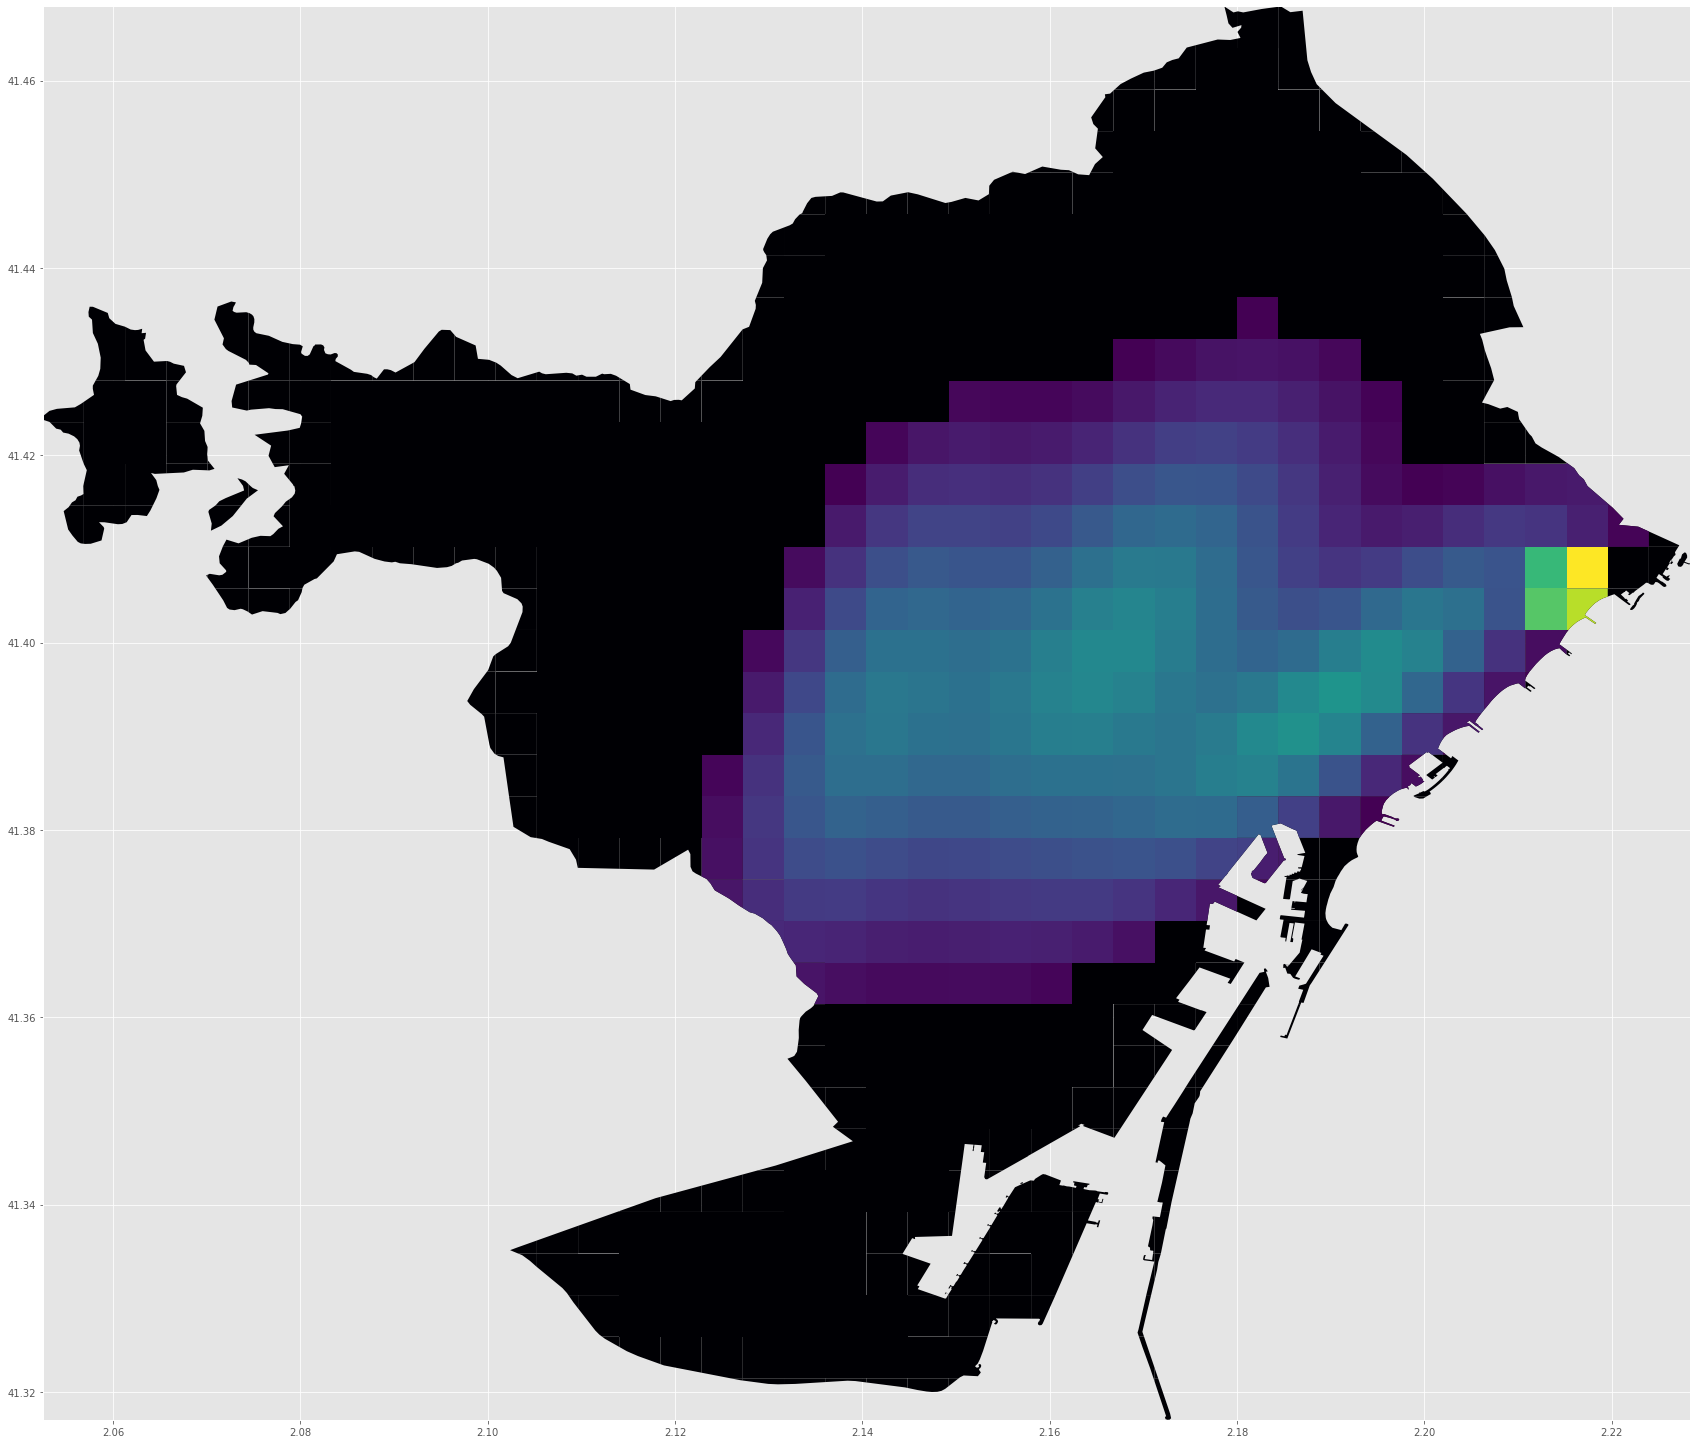

time: 1.59 s


In [24]:
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))

polyframe.plot(ax=ax, color='#000004')
#polyair.plot(column='prices',  legend=True, cmap='magma', ax=ax)    
poly_prices[poly_prices.index.isin(keys)].plot(ax=ax, column='zpred')
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [25]:
lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    
print(len(keys))
vals = np.array(vals)
keys = np.array(keys)
keys = keys[vals>=0.01*vals.max()]
print(len(keys))

indlist = poly_prices.index.tolist()
mat = np.zeros(shape=(len(geometry_cut), len(geometry_cut)))
for pair in tqdm_notebook(combinations(sorted(keys), 2)):
    mat[pair[0], pair[1]] = geometry_cut[pair[0]].centroid.distance(geometry_cut[pair[1]].centroid)

print(mat)


def isuppertriangular(M): 
    for i in range(1, len(M)): 
        for j in range(0, i): 
            if(M[i][j] != 0):  
                    return False
    return True


if isuppertriangular(mat): 
    print ("Yes") 
else: 
    print ("No")

721
421



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Yes
time: 6.69 s


721


721 421
Number of cells with price above 1.0th percentile:  421
Loubar price:  34.16009416967005
Average price:  22.82028073420596
eta =  0.6083985299915197
721 378
Number of cells with price above 2.0th percentile:  378
Loubar price:  37.12965684722239
Average price:  25.222536929356
eta =  0.6271943609170215
721 351
Number of cells with price above 3.0th percentile:  351
Loubar price:  38.93907651793287
Average price:  26.943047325678386
eta =  0.6312234729738881
721 330
Number of cells with price above 4.0th percentile:  330
Loubar price:  39.33704853071665
Average price:  28.404674107895026
eta =  0.6425209697393784
721 316
Number of cells with price above 5.0th percentile:  316
Loubar price:  40.293186596893094
Average price:  29.43470304828502
eta =  0.6521191774327909
721 302
Number of cells with price above 6.000000000000001th percentile:  302
Loubar price:  42.019790024706445
Average price:  30.508872616434523
eta =  0.6526508094004597
721 284
Number of cells with price above 

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning:

Mean of empty slice.

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning:

invalid value encountered in double_scalars



eta =  nan
721 6
Number of cells with price above 55.00000000000001th percentile:  6
Loubar price:  103.90179427506155
Average price:  86.01879852935467
eta =  nan
721 5
Number of cells with price above 56.00000000000001th percentile:  5
Loubar price:  103.90179427506155
Average price:  90.49911522451472
eta =  nan
721 4
Number of cells with price above 57.00000000000001th percentile:  4
Loubar price:  103.90179427506155
Average price:  96.81037219841625
eta =  nan
721 4
Number of cells with price above 58.00000000000001th percentile:  4
Loubar price:  103.90179427506155
Average price:  96.81037219841625
eta =  nan
721 4
Number of cells with price above 59.0th percentile:  4
Loubar price:  103.90179427506155
Average price:  96.81037219841625
eta =  nan
721 4
Number of cells with price above 60.0th percentile:  4
Loubar price:  103.90179427506155
Average price:  96.81037219841625
eta =  nan
721 4
Number of cells with price above 61.0th percentile:  4
Loubar price:  103.90179427506155
Av

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning:

invalid value encountered in true_divide



Loubar price:  115.02270545636455
Average price:  115.02270545636455
eta =  nan
721 1
Number of cells with price above 92.0th percentile:  1
Loubar price:  115.02270545636455
Average price:  115.02270545636455
eta =  nan
721 1
Number of cells with price above 93.0th percentile:  1
Loubar price:  115.02270545636455
Average price:  115.02270545636455
eta =  nan
721 1
Number of cells with price above 94.0th percentile:  1
Loubar price:  115.02270545636455
Average price:  115.02270545636455
eta =  nan
721 1
Number of cells with price above 95.0th percentile:  1
Loubar price:  115.02270545636455
Average price:  115.02270545636455
eta =  nan
721 1
Number of cells with price above 96.00000000000001th percentile:  1
Loubar price:  115.02270545636455
Average price:  115.02270545636455
eta =  nan
721 1
Number of cells with price above 97.0th percentile:  1
Loubar price:  115.02270545636455
Average price:  115.02270545636455
eta =  nan
721 1
Number of cells with price above 98.0th percentile:  1


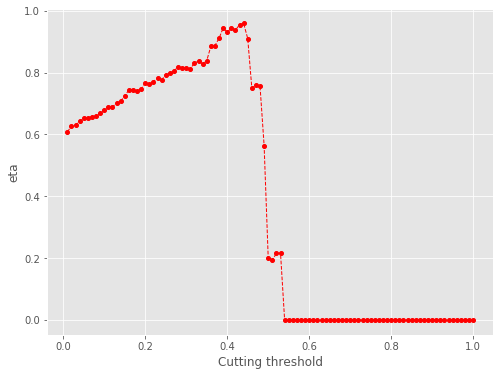

time: 2.57 s


In [27]:
from tqdm import tqdm_notebook

#poly_prices = polyair[polyair.median_prices>0]
poly_prices = polyair.copy()
print(len(poly_prices))
poly_prices['zpred'] = zpred

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys_initial = np.array(keys)


perc_vals = np.linspace(0.01, 1, 100)
etas_cut = []
for i in tqdm_notebook(perc_vals):
    keys = keys_initial
    vals_cut = vals[vals>=i*vals.max()]
    print(len(vals), len(vals_cut))

    L = np.cumsum(vals_cut)/np.sum(vals_cut)
    keys = keys[vals>=i*vals.max()]
    print('Number of cells with price above {}th percentile: '.format(i*100), len(keys))
    
    
        
    L1= L
    F1 = np.arange(1, len(L1)+1)/len(L1)

    L1 = (L1 - L1.min())/(L1.max()-L1.min())
    

    loubar_val = vals_cut[np.where(tngnt1(F1)>0)[0][0]]

    print('Loubar price: ', loubar_val)
    print('Average price: ', np.mean(vals_cut))
    
    
    loubar_keys = keys[vals_cut>loubar_val]
    dist_mat = mat[keys.reshape(-1,1), keys]

    total_dist = dist_mat.sum()
    dist_corr = dist_mat[dist_mat>0]

    loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

    loubar_dist = loubar_dist_mat.sum()

    loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
    eta = loubar_dist_corr.mean()/dist_corr.mean()
    etas_cut.append(eta)
    print('eta = ', eta)
etas_cut = np.array(etas_cut)
etas_cut = np.where(np.isnan(etas_cut), 0, etas_cut)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(perc_vals, etas_cut, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
plt.xlabel("Cutting threshold")
plt.ylabel("eta")
plt.show()

In [28]:
pickle_in = open("etas_cut_dict.pickle","rb")
etas_cut_dict = pickle.load(pickle_in)
#etas_cut_dict = {}
etas_cut_dict['Barcelona'] = etas_cut


pickle_out = open("etas_cut_dict.pickle","wb")
pickle.dump(etas_cut_dict, pickle_out)
pickle_out.close()

etas_cut_dict

{'Boston': array([0.54176111, 0.69697859, 0.70601119, 0.71142664, 0.72735905,
        0.71723297, 0.69152614, 0.68969459, 0.69338651, 0.68627389,
        0.68571239, 0.68565242, 0.66080855, 0.68568495, 0.66662135,
        0.65169235, 0.66853925, 0.64080339, 0.6392735 , 0.64870117,
        0.66369008, 0.64936606, 0.65513408, 0.65817401, 0.54708479,
        0.54484174, 0.5177247 , 0.54225619, 0.54660686, 0.55128317,
        0.55836993, 0.56571414, 0.52792612, 0.52759205, 0.55096732,
        0.46941853, 0.48021089, 0.47484233, 0.46129546, 0.46439344,
        0.4699713 , 0.50255475, 0.51573036, 0.52765377, 0.52765377,
        0.53943229, 0.54404083, 0.54813213, 0.6100999 , 0.50092562,
        0.52536404, 0.56707558, 0.56150998, 0.61316219, 0.66467806,
        0.74541769, 0.74541769, 0.77652679, 0.74895419, 0.92876367,
        0.92876367, 0.90963119, 0.90963119, 1.05344906, 1.15130075,
        1.15130075, 1.22651104, 1.26738008, 0.62257449, 0.62257449,
        0.64231201, 0.64231201, 0.6240

time: 24 ms


100
100
100
100
100
100
100
100
100
100
100
100
100


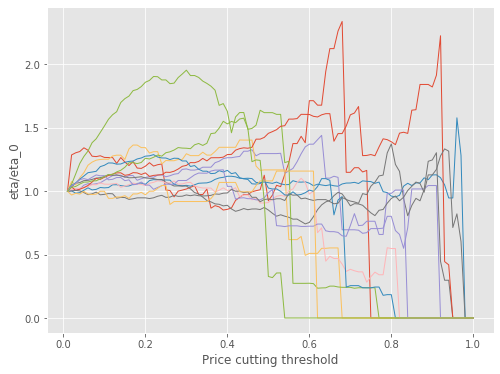

time: 285 ms


In [29]:
fig, ax = plt.subplots(figsize=(8, 6))
for key in etas_cut_dict:
    print(len(etas_cut_dict[key]))
    etas = etas_cut_dict[key]#[1:]
    vals = etas/etas[0]
    plt.plot(np.linspace(0.01, 1, 100), vals, linestyle='-', linewidth=1)
plt.xlabel("Price cutting threshold")
plt.ylabel("eta/eta_0")
plt.show()

721 254
Number of cells with price above 5th percentile:  254


eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  1.0
eta =  0.9976538913615592
eta =  0.9807088591266593
eta =  0.9663325909848871
eta =  0.9500745102600834
eta =  0.9373677110388919
eta =  0.9198697009977118
eta =  0.9010292302947054
eta =  0.8930277717511771
eta =  0.8761543575804631
eta =  0.8686424735492277
eta =  0.8600203713562893
eta =  0.851773847939748
eta =  0.8399224562078609
eta =  0.8268324136921072
eta =  0.7992647713958451
eta =  0.7903351141632663
eta =  0.776698337501827
eta =  0.7750636258078314
eta =  0.7728610528397846
eta =  0.7699816730366927
eta =  0.7625453148723553
eta =  0.7495882793396844
eta =  0.7433187076713426
eta =  0.73604841769237
eta =  0.7153855067179968
eta =  0.6995959542100969
eta =  0.6995959542100969
eta =  0.6910204347499858
eta =  0.6771349169066331
eta =  0.6771124078140384
eta =  0.6703018114700213
eta =  0.6702748069533726
eta =  0.6592836582179956
eta =  0.6500444901545307
eta =  0.6

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning:

Mean of empty slice.



eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan



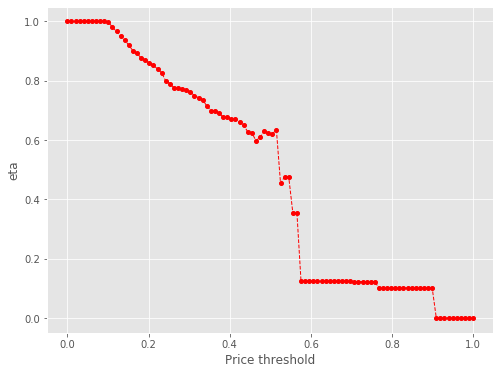

time: 871 ms


In [30]:
lval = np.linspace(0, max(vals_cut), 100)
etas = []

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)
vals_cut = vals[vals>0.1*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.1*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))

for i in tqdm_notebook(lval):
    loubar_keys = keys[vals_cut>=i]
    dist_mat = mat[keys.reshape(-1,1), keys]

    total_dist = dist_mat.sum()
    dist_corr = dist_mat[dist_mat>0]

    loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

    loubar_dist = loubar_dist_mat.sum()

    loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
    eta = loubar_dist_corr.mean()/dist_corr.mean()
    etas.append(eta)
    print('eta = ', eta)
etas = np.array(etas)
etas = np.where(np.isnan(etas), 0, etas)
lval = lval/lval.max()
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(lval, etas, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
plt.xlabel("Price threshold")
plt.ylabel("eta")
plt.show()

etas_cut_threshold = etas

In [31]:
pickle_in = open("etas_cut_threshold_dict.pickle","rb")
etas_cut_threshold_dict = pickle.load(pickle_in)
#etas_cut_threshold_dict = {}
etas_cut_threshold_dict['Barcelona'] = etas_cut_threshold


pickle_out = open("etas_cut_threshold_dict.pickle","wb")
pickle.dump(etas_cut_threshold_dict, pickle_out)
pickle_out.close()

etas_cut_threshold_dict

{'NY': array([1.        , 1.        , 1.        , 1.        , 1.        ,
        0.99991145, 0.98955316, 0.97868522, 0.96344498, 0.95205618,
        0.94615067, 0.93194961, 0.92540239, 0.92150344, 0.91822455,
        0.91569734, 0.91218202, 0.90337978, 0.898264  , 0.89376519,
        0.89441924, 0.88573077, 0.88617046, 0.87902683, 0.87195329,
        0.87101443, 0.87158631, 0.86935351, 0.86321974, 0.86053312,
        0.86079304, 0.86069179, 0.86140605, 0.85888874, 0.8617884 ,
        0.85709178, 0.8579834 , 0.85179248, 0.84947743, 0.84847717,
        0.84228408, 0.82983947, 0.82767187, 0.82334824, 0.81678545,
        0.81788964, 0.81304395, 0.807866  , 0.79902867, 0.79698224,
        0.78820712, 0.76853775, 0.76312442, 0.75071909, 0.7481045 ,
        0.73389742, 0.71700231, 0.70245218, 0.68328343, 0.67990807,
        0.66811743, 0.61552082, 0.58620924, 0.57826542, 0.57372339,
        0.55441141, 0.5326264 , 0.53706259, 0.53126932, 0.52772792,
        0.5331439 , 0.51700595, 0.49034259

time: 25 ms


721 421
Number of cells with price above 1.0th percentile:  421


eta =  1.0
eta =  0.9415281371363684
eta =  0.9116784862913478
eta =  0.8845313219798668
eta =  0.8698453871783496
eta =  0.8517830463445272
eta =  0.8295686679783606
eta =  0.8185664581519005
eta =  0.8055018890272392
eta =  0.7944386871502453
eta =  0.7800429436962479
eta =  0.7689609472959621
eta =  0.7593834656134894
eta =  0.7446811737347678
eta =  0.7317226322031232
eta =  0.7212736846669354
eta =  0.71071153340777
eta =  0.6984187728127343
eta =  0.6928362215129941
eta =  0.6862451158579785
eta =  0.676682097506166
eta =  0.6678534763265406
eta =  0.6583412787053796
eta =  0.642247831644503
eta =  0.6288139298017723
eta =  0.6170392075567297
eta =  0.61563771343092
eta =  0.6144135028309013
eta =  0.612829616682176
eta =  0.6088905430551091
eta =  0.5984414270757417
eta =  0.5943468089717494
eta =  0.5855310169721183
eta =  0.5738975804766412
eta =  0.5672237022063518
eta =  0.5557860913982926
eta =  0.5489733669767705
eta =  0.5436952365419895
eta =  0.5379242923169261
eta =  0

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning:

Mean of empty slice.



eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan


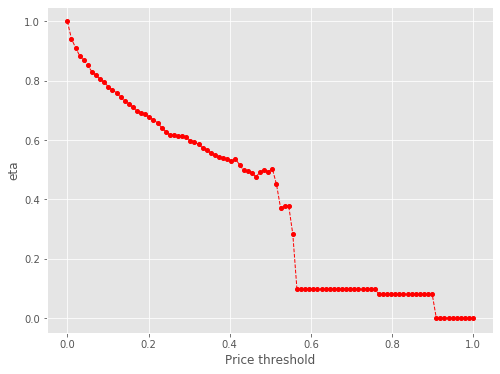

721 378
Number of cells with price above 2.0th percentile:  378


eta =  1.0
eta =  0.968296591819542
eta =  0.9412132853490285
eta =  0.9238655254891904
eta =  0.9065541196094925
eta =  0.8810874951666029
eta =  0.869402013456069
eta =  0.8555260934390668
eta =  0.8453220955580671
eta =  0.8337152303233704
eta =  0.8201981081334552
eta =  0.806543570671327
eta =  0.7955543881550233
eta =  0.7771649123823715
eta =  0.7663922621313656
eta =  0.7548489581728055
eta =  0.7476506737172399
eta =  0.7358635331071848
eta =  0.7323308685252649
eta =  0.7187061871186089
eta =  0.7093292807560678
eta =  0.7055410429023048
eta =  0.6869691626866816
eta =  0.6678652554285763
eta =  0.6553592858450702
eta =  0.6542628745372523
eta =  0.6525705165855402
eta =  0.6508882661181855
eta =  0.6461819949873691
eta =  0.6356065246184618
eta =  0.6311439689402228
eta =  0.6273611672752343
eta =  0.6104045827511315
eta =  0.6036250010455535
eta =  0.5903021582431944
eta =  0.5904410847679504
eta =  0.5841607228457828
eta =  0.571468742301317
eta =  0.5725170464639109
eta =

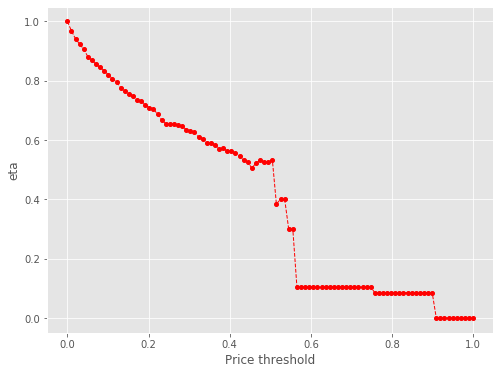

721 351
Number of cells with price above 3.0th percentile:  351


eta =  1.0
eta =  0.9720299475395024
eta =  0.9541141973381726
eta =  0.9362359913980197
eta =  0.9099355534350658
eta =  0.897867472426358
eta =  0.885055136045014
eta =  0.87397043985087
eta =  0.86101225323609
eta =  0.8470525612325119
eta =  0.8329509547851839
eta =  0.8216019707970716
eta =  0.8094160262485247
eta =  0.792043562543217
eta =  0.7795637871185279
eta =  0.7732717925471381
eta =  0.7609959281535718
eta =  0.7564786806052052
eta =  0.7422376503133987
eta =  0.7340448184794663
eta =  0.7319103208546505
eta =  0.7099923076698634
eta =  0.6946798866784247
eta =  0.6826881043552159
eta =  0.6757276521099954
eta =  0.6738163314642022
eta =  0.6721992740830479
eta =  0.6709637648085686
eta =  0.6644837055485463
eta =  0.653192915590556
eta =  0.6477295967121504
eta =  0.6413942496430403
eta =  0.6233885424622552
eta =  0.6096294908298169
eta =  0.6096294908298169
eta =  0.6021567638498967
eta =  0.5900568923143199
eta =  0.5900372778403153
eta =  0.5866040125983444
eta =  0.

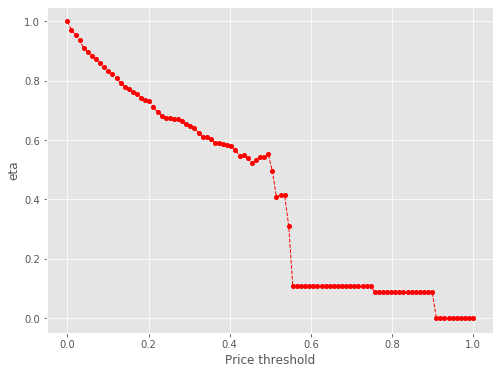

721 330
Number of cells with price above 4.0th percentile:  330


eta =  1.0
eta =  0.9814952160254238
eta =  0.9639854276136505
eta =  0.9378623994021128
eta =  0.9254239367348625
eta =  0.912218376741968
eta =  0.9007934799676437
eta =  0.8874375934495716
eta =  0.8730494643255188
eta =  0.8592148551942699
eta =  0.846817769430342
eta =  0.8342578258715514
eta =  0.8169806970310795
eta =  0.8034893912145112
eta =  0.798985848453095
eta =  0.7843516658064926
eta =  0.7796957793446315
eta =  0.7664960419596851
eta =  0.7596229840231544
eta =  0.7543733916897636
eta =  0.7426166161719907
eta =  0.7168000843981812
eta =  0.7098366953238269
eta =  0.6964664198006424
eta =  0.6961206619189656
eta =  0.6941424287760498
eta =  0.6915563239612932
eta =  0.6859398790634643
eta =  0.6735440100767489
eta =  0.6721567335153109
eta =  0.6609348480788871
eta =  0.6428414264882157
eta =  0.641291997564066
eta =  0.6283396388431602
eta =  0.6206375662853756
eta =  0.6146704170125077
eta =  0.6081461209455848
eta =  0.6072132944751228
eta =  0.5992908799658219
eta =

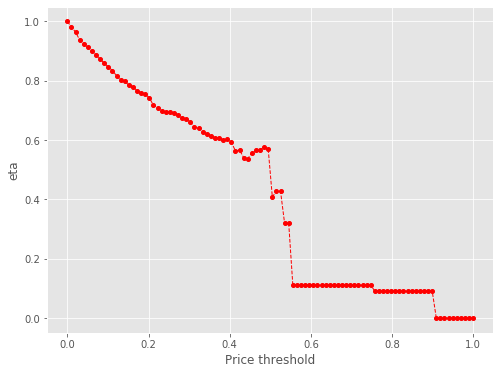

721 316
Number of cells with price above 5.0th percentile:  316


eta =  1.0
eta =  0.9812619852109629
eta =  0.9536966916262662
eta =  0.9410482256015746
eta =  0.9302592833249476
eta =  0.9160019233432528
eta =  0.9024205442474053
eta =  0.8896376065473588
eta =  0.874100417921708
eta =  0.8611149200894515
eta =  0.8483429221645241
eta =  0.8348678105631521
eta =  0.8190363777192355
eta =  0.8141520055785835
eta =  0.7975941771714851
eta =  0.7933400538317718
eta =  0.7794370899479444
eta =  0.7779337655640426
eta =  0.7671097683029602
eta =  0.7551544986145277
eta =  0.7325017871834067
eta =  0.7229031033222492
eta =  0.709366534158805
eta =  0.7077553350348367
eta =  0.706347946298788
eta =  0.7045270639074205
eta =  0.69943295551072
eta =  0.6879859753202779
eta =  0.683278681168527
eta =  0.6790611295329415
eta =  0.6607071764344923
eta =  0.6533688988188315
eta =  0.6389481390493785
eta =  0.6390985143160414
eta =  0.6323005964926198
eta =  0.6185626874633318
eta =  0.6184136862090783
eta =  0.6094089387841499
eta =  0.6137699834533114
eta =  

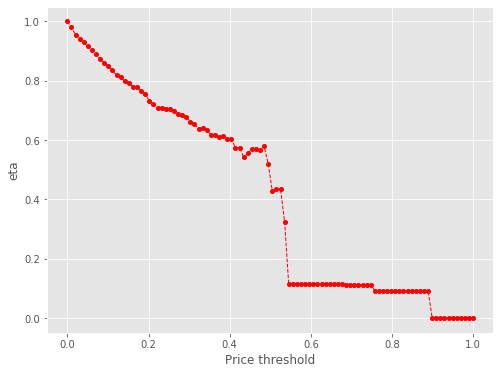

721 302
Number of cells with price above 6.000000000000001th percentile:  302


eta =  1.0
eta =  0.9739201449694252
eta =  0.9610034640450084
eta =  0.9499857386839172
eta =  0.9354260466747361
eta =  0.9215566699493568
eta =  0.9085026658332944
eta =  0.8926360059910465
eta =  0.8826079753459946
eta =  0.8663323140288681
eta =  0.8525714582352839
eta =  0.8364043146289359
eta =  0.8314163677637781
eta =  0.8145074251364092
eta =  0.8101630917061795
eta =  0.8021214529625708
eta =  0.7944301080071783
eta =  0.7840652372604383
eta =  0.771167799178217
eta =  0.7540040088855304
eta =  0.7382325023964272
eta =  0.7244088858128682
eta =  0.7231969550276581
eta =  0.7213262878002679
eta =  0.7194667929963707
eta =  0.7142646623485812
eta =  0.7029714067732713
eta =  0.6999117818088343
eta =  0.6932764637555204
eta =  0.6793121818943302
eta =  0.667223802120008
eta =  0.6524972453765997
eta =  0.6524972453765997
eta =  0.64449905328912
eta =  0.6315483464005346
eta =  0.6315273526814805
eta =  0.6278526680628215
eta =  0.6223316566132215
eta =  0.6308704686370094
eta =

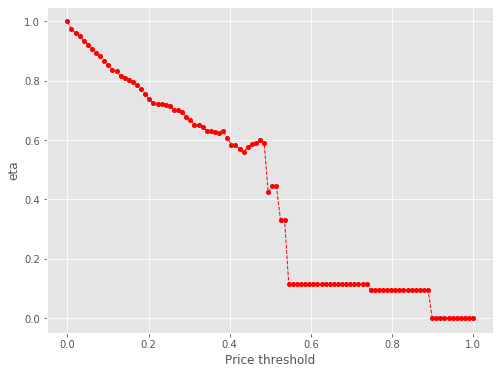

721 284
Number of cells with price above 6.999999999999999th percentile:  284


eta =  1.0
eta =  0.9867374332576081
eta =  0.972656945542872
eta =  0.9604750979908135
eta =  0.9462343239427373
eta =  0.9328307567370582
eta =  0.9165392158707935
eta =  0.9062426523415866
eta =  0.8895311576659761
eta =  0.8754018105478751
eta =  0.8597410692206956
eta =  0.8536802242548122
eta =  0.8363184901180778
eta =  0.8318578231397127
eta =  0.8236008435658265
eta =  0.8157035380268453
eta =  0.805061114415138
eta =  0.7935946765079036
eta =  0.7772126675818521
eta =  0.7580010601583798
eta =  0.7438072716276034
eta =  0.7425628874843345
eta =  0.7406421271046948
eta =  0.7387328383262441
eta =  0.7366998880605278
eta =  0.7274565616614859
eta =  0.7178452508254133
eta =  0.7118411784954759
eta =  0.7048787655584347
eta =  0.6850908727644754
eta =  0.6705884134650852
eta =  0.6699699649369958
eta =  0.6617575954436727
eta =  0.6553950957031224
eta =  0.6484385356884741
eta =  0.647443905270348
eta =  0.6389965951805614
eta =  0.6427822116725215
eta =  0.6313647852331591
eta 

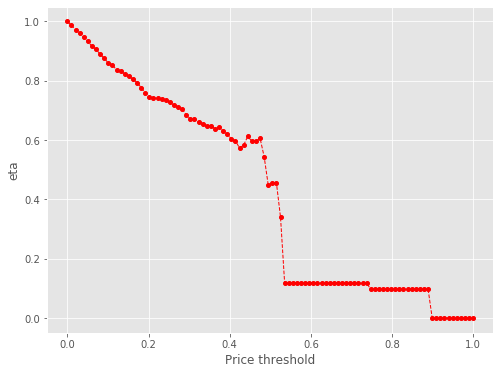

721 273
Number of cells with price above 8.0th percentile:  273


eta =  1.0
eta =  0.9840396964784539
eta =  0.9733846772387135
eta =  0.9589524954159749
eta =  0.9453687731876322
eta =  0.9288582605455002
eta =  0.9184233026912979
eta =  0.9014871917134877
eta =  0.8888146479979943
eta =  0.8712966998549476
eta =  0.8651543921228144
eta =  0.8486508372934931
eta =  0.8430386798982816
eta =  0.8356725232634074
eta =  0.8266672678403283
eta =  0.8158818012582282
eta =  0.8115245099302452
eta =  0.7876590482799134
eta =  0.768189220972311
eta =  0.7560791513690653
eta =  0.7525917497422403
eta =  0.7504630161546116
eta =  0.7486620183115955
eta =  0.7472859697159818
eta =  0.7400688029747581
eta =  0.727822118426273
eta =  0.7263230470208666
eta =  0.7141968365448143
eta =  0.701100777782106
eta =  0.6925565035162949
eta =  0.6789749150644478
eta =  0.6750044132164906
eta =  0.6719109385583456
eta =  0.6573124210163718
eta =  0.6585181971088686
eta =  0.647585237615829
eta =  0.6522194790399319
eta =  0.6398508498342621
eta =  0.6363659796137983
eta =

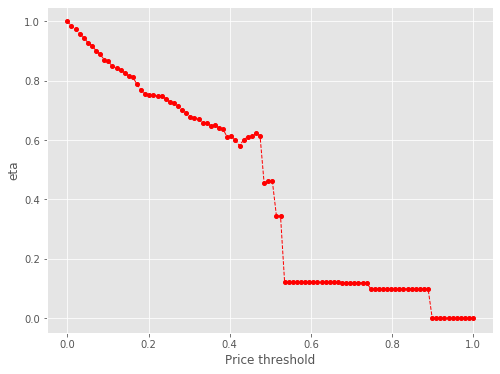

721 263
Number of cells with price above 9.0th percentile:  263


eta =  1.0
eta =  0.988072838503404
eta =  0.9745059054505041
eta =  0.9587061276370903
eta =  0.9439235671788146
eta =  0.9299007876627495
eta =  0.9161085624285343
eta =  0.9032304806185788
eta =  0.8854284059606788
eta =  0.8791864751177317
eta =  0.8641207762005034
eta =  0.8567120644779196
eta =  0.851947245818032
eta =  0.840075121764591
eta =  0.82911472390595
eta =  0.8246867609451303
eta =  0.8029786209385906
eta =  0.7862485689622194
eta =  0.7726760992941951
eta =  0.7647981605168087
eta =  0.7626349006450305
eta =  0.7608046921184219
eta =  0.7594063251617452
eta =  0.755914481827514
eta =  0.7396267864303675
eta =  0.7378589883749492
eta =  0.7269145174559829
eta =  0.7134844716394455
eta =  0.7055600123417458
eta =  0.6899873221520129
eta =  0.6901497093963311
eta =  0.682808773835942
eta =  0.669128970260286
eta =  0.667812577033864
eta =  0.6610955211312575
eta =  0.6597730422964266
eta =  0.6671179508633772
eta =  0.6420054396735535
eta =  0.6185655562398862
eta =  0.6

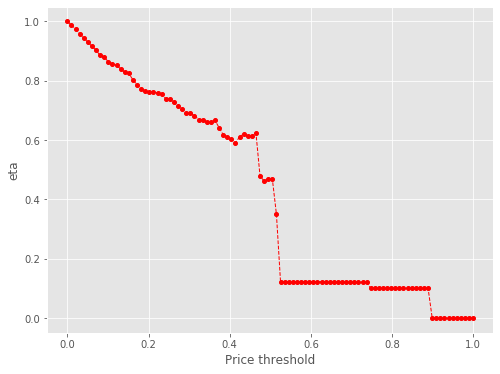

721 254
Number of cells with price above 10.0th percentile:  254


eta =  1.0
eta =  0.9880766891204119
eta =  0.9720568866098268
eta =  0.9570684670295647
eta =  0.942850408956234
eta =  0.928866115819779
eta =  0.9141119707136127
eta =  0.8977587133351929
eta =  0.8914298585519408
eta =  0.8744250768840027
eta =  0.8686424735492277
eta =  0.8638113009320189
eta =  0.851773847939748
eta =  0.8406608176676512
eta =  0.8400231795712559
eta =  0.814505886817576
eta =  0.7971977168129226
eta =  0.7849858781631114
eta =  0.7754485940641755
eta =  0.7750636258078314
eta =  0.7728610528397846
eta =  0.7699816730366927
eta =  0.76644120295712
eta =  0.7532883742387076
eta =  0.7481342721409358
eta =  0.7435163980434893
eta =  0.7234203205268684
eta =  0.7153855067179968
eta =  0.6995959542100969
eta =  0.6995959542100969
eta =  0.6910204347499858
eta =  0.6771349169066331
eta =  0.6771124078140384
eta =  0.6757969215365527
eta =  0.6672529458606217
eta =  0.6712059618472643
eta =  0.6592836582179956
eta =  0.6481114840952696
eta =  0.6305856639253592
eta =  

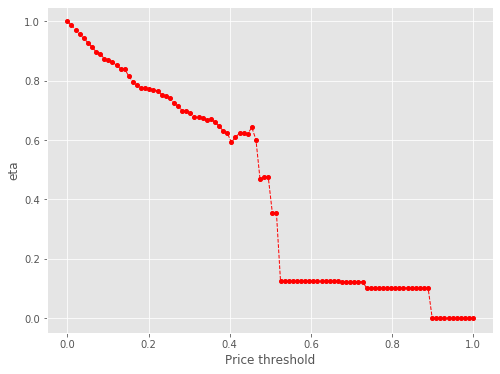

721 243
Number of cells with price above 11.0th percentile:  243


eta =  1.0
eta =  0.985793094483012
eta =  0.9735149477990747
eta =  0.9602507748111118
eta =  0.9460084006318054
eta =  0.9309819668144241
eta =  0.9133279402726918
eta =  0.9078812547919203
eta =  0.8894172063981773
eta =  0.8846733271112206
eta =  0.8769433825030054
eta =  0.8674933899147852
eta =  0.8561752679434603
eta =  0.8555258621943654
eta =  0.8295376461369224
eta =  0.8119100527248031
eta =  0.7994728437954132
eta =  0.7897595484957534
eta =  0.7893674756251042
eta =  0.7875853773356727
eta =  0.7856357417686154
eta =  0.7799551741454285
eta =  0.7671903603665919
eta =  0.7619411389781003
eta =  0.7570367029518184
eta =  0.7417881340879354
eta =  0.728587992951153
eta =  0.7125070432208385
eta =  0.7125070432208385
eta =  0.7037732619892053
eta =  0.6970068006328979
eta =  0.6896085615081163
eta =  0.6885507809874879
eta =  0.6795671425406368
eta =  0.6786211100457652
eta =  0.6714507811742607
eta =  0.6620411036609701
eta =  0.6394151649125169
eta =  0.6442753118463871
eta

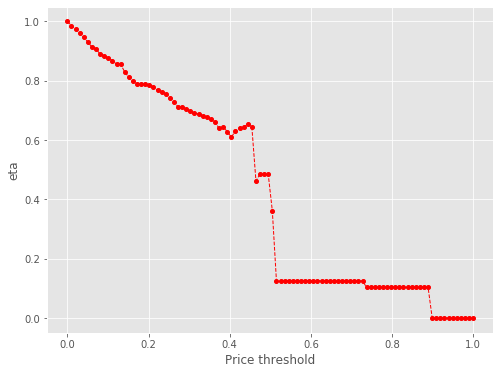

721 233
Number of cells with price above 12.0th percentile:  233


eta =  1.0
eta =  0.9875449049575902
eta =  0.9740895733447031
eta =  0.9596419430468103
eta =  0.944398953517388
eta =  0.9264905033156845
eta =  0.9209653221075242
eta =  0.9033971263869766
eta =  0.8974229298848736
eta =  0.8924316875533767
eta =  0.8799954014384046
eta =  0.8685141666492113
eta =  0.867751341292708
eta =  0.8417653908317809
eta =  0.8236110166206837
eta =  0.8165210375279894
eta =  0.8024324378585641
eta =  0.8006098561907459
eta =  0.7990178239759455
eta =  0.7969580494785603
eta =  0.7911956155002964
eta =  0.7782468396869185
eta =  0.77529683630617
eta =  0.7679468513104545
eta =  0.7604356771131079
eta =  0.7390881484448343
eta =  0.7376744688727724
eta =  0.7227754456877229
eta =  0.7185488075909549
eta =  0.7152557735256946
eta =  0.6997155086518757
eta =  0.7009990691094388
eta =  0.6925107093816015
eta =  0.6924828101328437
eta =  0.6890529535839955
eta =  0.6725134693007655
eta =  0.6486301927767621
eta =  0.645320805881939
eta =  0.6324715903498797
eta = 

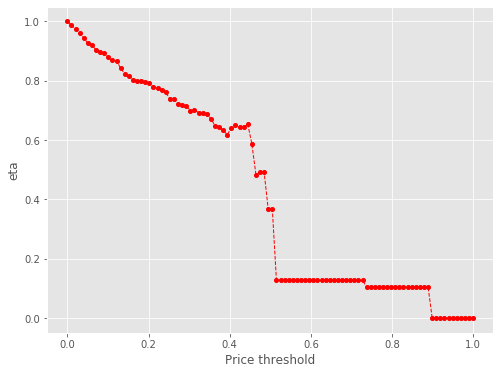

721 224
Number of cells with price above 13.0th percentile:  224


eta =  1.0
eta =  0.9826717850619431
eta =  0.9655619702551688
eta =  0.9516206879657625
eta =  0.9381755691964938
eta =  0.9325807034031277
eta =  0.9136143296093956
eta =  0.9087413902696538
eta =  0.9008011479285464
eta =  0.8910940626808214
eta =  0.8794680244808811
eta =  0.8786955782329446
eta =  0.8523818882625194
eta =  0.8339985477987489
eta =  0.8268191486067711
eta =  0.812552860968914
eta =  0.8107072925712963
eta =  0.8090951813581166
eta =  0.8070094286120443
eta =  0.8011743177737057
eta =  0.7885069315680903
eta =  0.7850750202994211
eta =  0.7776323359629239
eta =  0.7698581828371529
eta =  0.748782930552319
eta =  0.746952926803725
eta =  0.7318912203984914
eta =  0.7320634696480148
eta =  0.7242767087704342
eta =  0.7126840034152919
eta =  0.7083697718942943
eta =  0.7012447797615251
eta =  0.6998419849313873
eta =  0.7076329601017927
eta =  0.6809953308701912
eta =  0.6569560877006402
eta =  0.6596952260211674
eta =  0.6532752022736364
eta =  0.62594758857561
eta = 

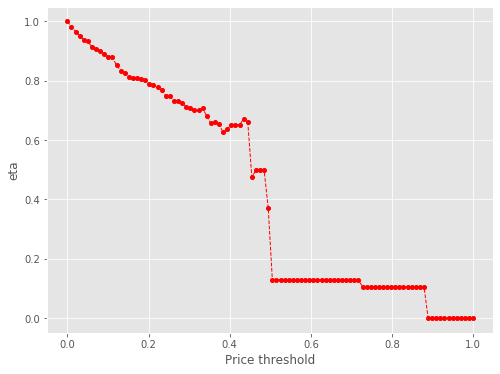

721 216
Number of cells with price above 14.000000000000002th percentile:  216


eta =  1.0
eta =  0.9813328218636985
eta =  0.9685670997288172
eta =  0.9543836456122137
eta =  0.9452825865374476
eta =  0.9316518804596927
eta =  0.9261216246235691
eta =  0.9104429938609063
eta =  0.908686994344749
eta =  0.8968314224691399
eta =  0.8864054316344472
eta =  0.8658084830427387
eta =  0.8444069112800429
eta =  0.835783258043461
eta =  0.8272619004603218
eta =  0.8268512097017107
eta =  0.8249844870764126
eta =  0.8229422715343772
eta =  0.8169919576994868
eta =  0.803620996720521
eta =  0.8005748106825286
eta =  0.7929851849148043
eta =  0.7852291144919017
eta =  0.7631855655931753
eta =  0.7617257940543654
eta =  0.7463409993445681
eta =  0.7468905175321623
eta =  0.7385761538871914
eta =  0.7267545729490389
eta =  0.7223551652569613
eta =  0.7150895039120994
eta =  0.7118369216292932
eta =  0.7198798052216947
eta =  0.7033351484737045
eta =  0.6699264171430197
eta =  0.6727196344607137
eta =  0.6661728597406409
eta =  0.6322439685226181
eta =  0.6495236709714732
eta 

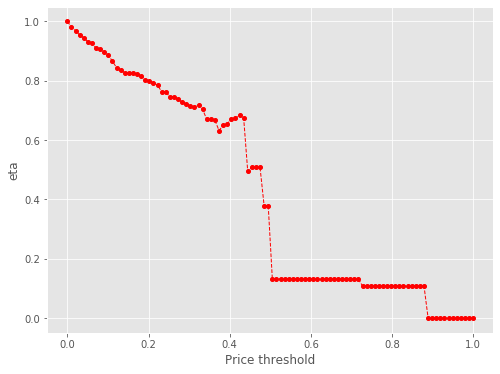

721 210
Number of cells with price above 15.000000000000002th percentile:  210


eta =  1.0
eta =  0.9857200705891421
eta =  0.9712854326617021
eta =  0.9634460194275825
eta =  0.948151096220755
eta =  0.9425229015663154
eta =  0.9337328444873003
eta =  0.924779510329977
eta =  0.9127139805908686
eta =  0.9078395481590822
eta =  0.88394258636922
eta =  0.865525650938487
eta =  0.8580748536015074
eta =  0.8432692667970425
eta =  0.8413539315810331
eta =  0.8396808787791364
eta =  0.8375162796824044
eta =  0.8352114830698972
eta =  0.8183143448106662
eta =  0.813835601543238
eta =  0.8125260281807495
eta =  0.7989606295948122
eta =  0.7843102771725251
eta =  0.7767013042253317
eta =  0.7595584268384481
eta =  0.7597371875140042
eta =  0.7502478983380382
eta =  0.7351722507081967
eta =  0.735147812357949
eta =  0.7337195755572049
eta =  0.7244432944633792
eta =  0.7287351240344515
eta =  0.7157909579991257
eta =  0.7057598994754883
eta =  0.6816398257091557
eta =  0.6868209191375192
eta =  0.6702696387323213
eta =  0.6500866527256841
eta =  0.6723084878733293
eta =  0

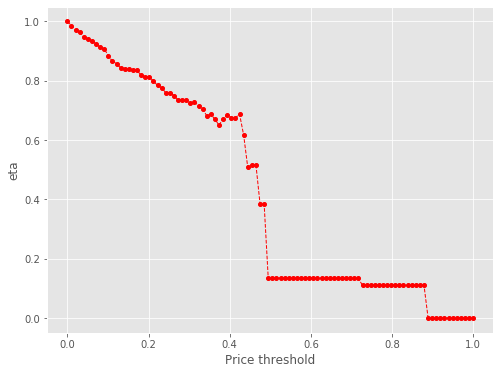

721 201
Number of cells with price above 16.0th percentile:  201


eta =  1.0
eta =  0.9853562503614106
eta =  0.9759598346899365
eta =  0.9618867714178397
eta =  0.9561770422336954
eta =  0.9420819825877821
eta =  0.938176606039134
eta =  0.92593628538512
eta =  0.9209912380261137
eta =  0.8967480857328064
eta =  0.8780643478438886
eta =  0.8705056122968622
eta =  0.8554855399190968
eta =  0.8535424576250895
eta =  0.8518451676420452
eta =  0.8496492104313552
eta =  0.847311024691534
eta =  0.8398968542981077
eta =  0.825625475046711
eta =  0.8242969301569779
eta =  0.8118014415602873
eta =  0.7978564483717987
eta =  0.7879532205944789
eta =  0.770561997773341
eta =  0.770561997773341
eta =  0.7611165895096691
eta =  0.7537987980152819
eta =  0.7457977516056542
eta =  0.7446537833053597
eta =  0.7349381595024195
eta =  0.7401975148198127
eta =  0.7261604783712216
eta =  0.7169769331895287
eta =  0.6915146054617264
eta =  0.6879864172916739
eta =  0.6635469445446855
eta =  0.6590206452970063
eta =  0.6706026574238678
eta =  0.6956792784815831
eta =  0

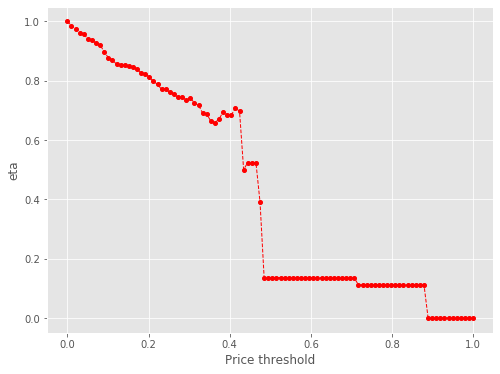

721 193
Number of cells with price above 17.0th percentile:  193


eta =  1.0
eta =  0.9904639406630569
eta =  0.9761817323075155
eta =  0.9703871486916403
eta =  0.9539591316832337
eta =  0.9521192012483078
eta =  0.9396969725878367
eta =  0.934678435021152
eta =  0.9100749961284516
eta =  0.8911135921874254
eta =  0.8834425234300555
eta =  0.8681992321105391
eta =  0.866227272940143
eta =  0.8645047588926381
eta =  0.8622761667363651
eta =  0.8599032323393248
eta =  0.8523788771726458
eta =  0.8382736815711481
eta =  0.8365471166947395
eta =  0.8238659279448761
eta =  0.8086446647931826
eta =  0.79966328960259
eta =  0.7820136092816309
eta =  0.7820136092816309
eta =  0.7724278292551607
eta =  0.765001285310569
eta =  0.7569845900233076
eta =  0.7609270465789996
eta =  0.7492683966240714
eta =  0.7492382107726463
eta =  0.7569010123287738
eta =  0.7276321969100563
eta =  0.7019466649737888
eta =  0.7048733887609532
eta =  0.6980137000496349
eta =  0.6624631210199009
eta =  0.6805687355998433
eta =  0.6921842594003917
eta =  0.7036844278033584
eta = 

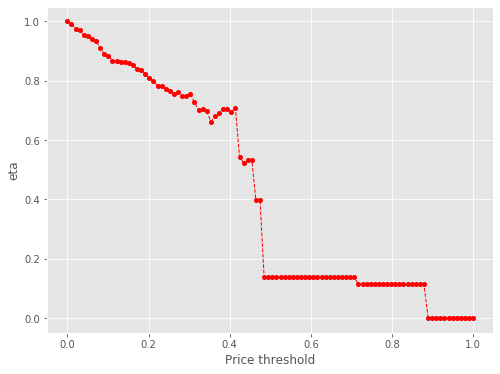

721 185
Number of cells with price above 18.000000000000004th percentile:  185


eta =  1.0
eta =  0.9920068710678297
eta =  0.9872445375905271
eta =  0.9688773037714488
eta =  0.9688773037714488
eta =  0.9553965606200786
eta =  0.942616814341987
eta =  0.9231585725927521
eta =  0.9003393870261487
eta =  0.8929071994555271
eta =  0.882058711766653
eta =  0.881620817357067
eta =  0.8797207731923935
eta =  0.8774529559309151
eta =  0.8750382558832565
eta =  0.8673814657072443
eta =  0.8526430727850739
eta =  0.8512710528664167
eta =  0.8383666644784126
eta =  0.8228774942326353
eta =  0.8137380392490446
eta =  0.795777709639707
eta =  0.795777709639707
eta =  0.7860232117843796
eta =  0.7784659543906179
eta =  0.7703081584918529
eta =  0.7718018604584583
eta =  0.7624561535682788
eta =  0.7622388161214287
eta =  0.769401955592213
eta =  0.7410104210086859
eta =  0.7143015194520778
eta =  0.7172797560511022
eta =  0.7155789540537792
eta =  0.6704133852147542
eta =  0.6810858115638011
eta =  0.7043672872909414
eta =  0.7160698683759312
eta =  0.7083276018596942
eta =  

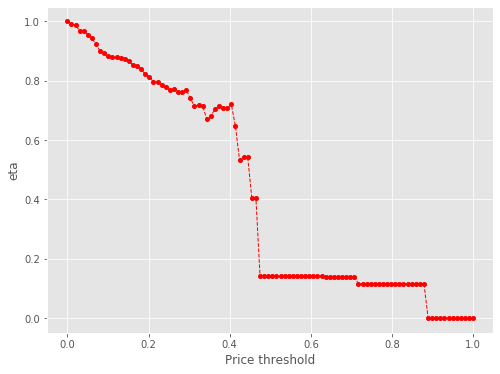

721 180
Number of cells with price above 19.0th percentile:  180


eta =  1.0
eta =  0.9951992938595513
eta =  0.9766840654324465
eta =  0.9699387402283793
eta =  0.963094700736959
eta =  0.9480850406354033
eta =  0.9305969540302005
eta =  0.9075939021037153
eta =  0.8983249406743091
eta =  0.889165929684716
eta =  0.8887245069261068
eta =  0.8868091530912808
eta =  0.8845230628154773
eta =  0.8820889062404736
eta =  0.8743704212185199
eta =  0.8599013087736405
eta =  0.8581301981810667
eta =  0.8451218322469545
eta =  0.8295078574877834
eta =  0.8202947610363923
eta =  0.8021897154634674
eta =  0.8021897154634674
eta =  0.7923566204115882
eta =  0.7866163722002273
eta =  0.7765960896149988
eta =  0.7764090207960316
eta =  0.7685996698264249
eta =  0.7651036967279925
eta =  0.76963641129054
eta =  0.7559657356691656
eta =  0.743588989998919
eta =  0.7198978228840005
eta =  0.7253697124927936
eta =  0.7078894681170365
eta =  0.6865736835377534
eta =  0.7100427505433876
eta =  0.7218396255714735
eta =  0.7140349754807912
eta =  0.7129735406045964
eta = 

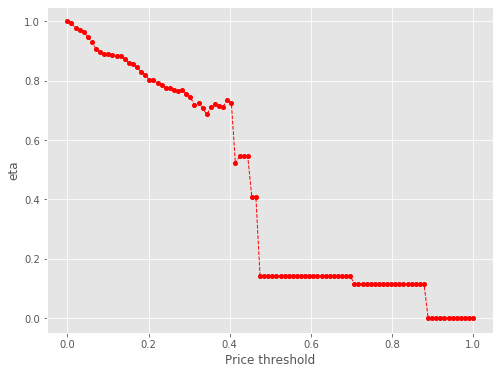

721 175
Number of cells with price above 20.0th percentile:  175


eta =  1.0
eta =  0.9860647192514349
eta =  0.9751805200750799
eta =  0.9723448342266617
eta =  0.9571910124352242
eta =  0.9358869255361215
eta =  0.9163109729613116
eta =  0.9018658475184759
eta =  0.8977060073507913
eta =  0.8972603449058467
eta =  0.8952346646299204
eta =  0.8930185476307329
eta =  0.88656154474902
eta =  0.8725440990655514
eta =  0.8677685491390397
eta =  0.8663721902495994
eta =  0.853238884243362
eta =  0.8374749435974339
eta =  0.8281733590960476
eta =  0.8098944219128184
eta =  0.8098944219128184
eta =  0.7999668839761664
eta =  0.794171503011839
eta =  0.7840549796815967
eta =  0.7838661141425914
eta =  0.7793050120137648
eta =  0.7724522070279489
eta =  0.7770284564731431
eta =  0.7632264795640601
eta =  0.7525306620244003
eta =  0.7268121491237024
eta =  0.7323365940100642
eta =  0.7087058865915172
eta =  0.6931679449519025
eta =  0.704832775476763
eta =  0.7400459293035344
eta =  0.7208929914520762
eta =  0.7198213619249421
eta =  0.7437331395539986
eta = 

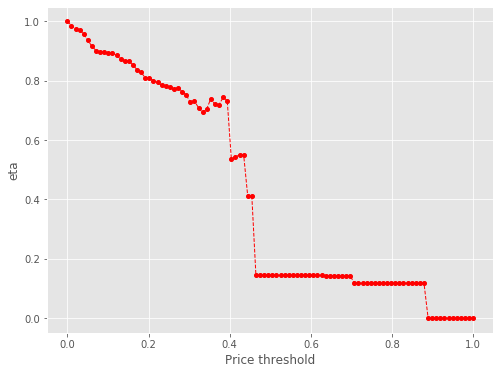

721 170
Number of cells with price above 21.000000000000004th percentile:  170


eta =  1.0
eta =  0.9860862225806146
eta =  0.9737113974746054
eta =  0.9558414481456389
eta =  0.9359265006094835
eta =  0.9278696640838547
eta =  0.9118598080705203
eta =  0.9103342732588422
eta =  0.9079795447452379
eta =  0.9056388796758315
eta =  0.9039743059723043
eta =  0.8998177213481857
eta =  0.8843760301642803
eta =  0.8781668785551506
eta =  0.8726714367543282
eta =  0.8641359669267938
eta =  0.8402961728862104
eta =  0.8377693546831746
eta =  0.8213400257618433
eta =  0.8213400257618433
eta =  0.8112721897031835
eta =  0.803472174815494
eta =  0.7950523306649394
eta =  0.7991930480777623
eta =  0.7869481002396737
eta =  0.7867237813852593
eta =  0.7941170183234155
eta =  0.7740125619172936
eta =  0.7630910666999675
eta =  0.7370836162513322
eta =  0.7426861337925295
eta =  0.7247885914915629
eta =  0.702963944879923
eta =  0.7269932782501186
eta =  0.7505044190865441
eta =  0.7310808077580726
eta =  0.7299940337297436
eta =  0.7542437377929909
eta =  0.7435991207990533
eta

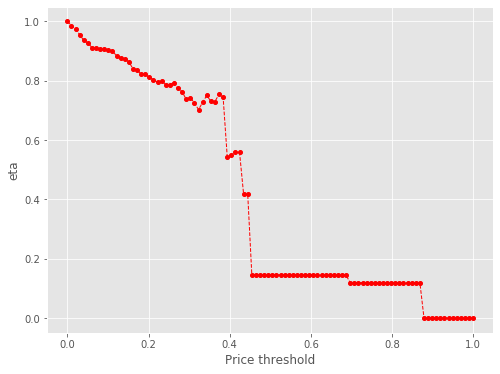

721 165
Number of cells with price above 22.0th percentile:  165


eta =  1.0
eta =  0.9883746370014688
eta =  0.9684770970605461
eta =  0.9482988858986985
eta =  0.9401355428411547
eta =  0.9239140461627757
eta =  0.9223683446986416
eta =  0.9199824880906806
eta =  0.9176108808371894
eta =  0.9159243024707011
eta =  0.9117127702984328
eta =  0.8960669492467228
eta =  0.8926703398487092
eta =  0.8842076281533177
eta =  0.8753680195383714
eta =  0.8593166028472381
eta =  0.8509799572945232
eta =  0.8321976467882399
eta =  0.8321976467882399
eta =  0.8219967199936459
eta =  0.8171580856996395
eta =  0.8056466267573128
eta =  0.8054525601569424
eta =  0.8007658524137213
eta =  0.7937243319033992
eta =  0.7984266040963746
eta =  0.7842445423436379
eta =  0.7878377024259025
eta =  0.7468274182322472
eta =  0.743017017640175
eta =  0.7166226823789499
eta =  0.7117343338833548
eta =  0.7242427670333142
eta =  0.729574126504136
eta =  0.7488418589510595
eta =  0.7508675682180261
eta =  0.7396441156947815
eta =  0.753429053830393
eta =  0.6763886060435655
eta 

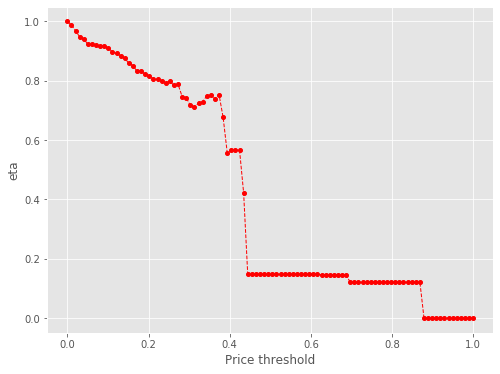

721 158
Number of cells with price above 23.0th percentile:  158


eta =  1.0
eta =  0.9793572091509761
eta =  0.9620006036830273
eta =  0.9537193106580055
eta =  0.937263433898798
eta =  0.9356953990062951
eta =  0.9332750697922789
eta =  0.9308691958178564
eta =  0.9291582485301954
eta =  0.9248858650523711
eta =  0.9090139817034862
eta =  0.9055682956018224
eta =  0.8969833084413168
eta =  0.8880159786781471
eta =  0.8717326393465773
eta =  0.8632755398248346
eta =  0.8442218487214403
eta =  0.8442218487214403
eta =  0.833873531455175
eta =  0.8278325128984672
eta =  0.8172872000806314
eta =  0.8170903294636909
eta =  0.8123359047297718
eta =  0.8051926431668768
eta =  0.8099628572371351
eta =  0.7955758826550938
eta =  0.7912428748888275
eta =  0.7576181284928836
eta =  0.747552089626784
eta =  0.7535398480214629
eta =  0.7151612633071001
eta =  0.7225479125780787
eta =  0.7472466823994006
eta =  0.7596616753285889
eta =  0.7514480869452311
eta =  0.7503310363321342
eta =  0.7643151493637803
eta =  0.7259067270621549
eta =  0.5651718541325269
eta 

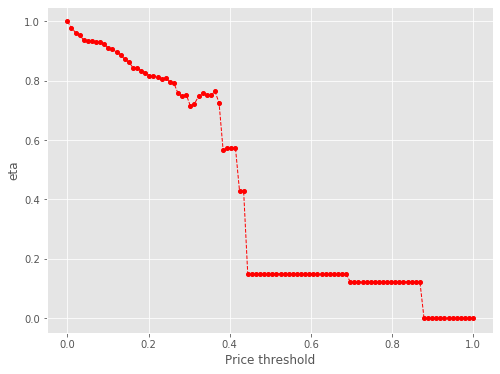

721 150
Number of cells with price above 24.000000000000004th percentile:  150


eta =  1.0
eta =  0.9790829938524935
eta =  0.9636483029206154
eta =  0.9592034922771697
eta =  0.9587272996594672
eta =  0.956661077792461
eta =  0.9541949174246327
eta =  0.9524410972174516
eta =  0.9432425755157461
eta =  0.927633764242241
eta =  0.9254166066234882
eta =  0.9194599174349624
eta =  0.9104668164208143
eta =  0.8853488463154261
eta =  0.8849074995054874
eta =  0.8653763609838565
eta =  0.8653763609838565
eta =  0.8547687355691037
eta =  0.8465505210813006
eta =  0.8377667838798494
eta =  0.837564980078715
eta =  0.832691418963184
eta =  0.8253691615420856
eta =  0.8302589076431679
eta =  0.8155114242319892
eta =  0.811069839951074
eta =  0.7766025246130552
eta =  0.7800129829973804
eta =  0.7724220505838951
eta =  0.733081775240246
eta =  0.7406535191789565
eta =  0.7659711908089002
eta =  0.7786972786482191
eta =  0.7702778741556985
eta =  0.7691328324867809
eta =  0.7946826900353929
eta =  0.7834673594422731
eta =  0.5620150466746011
eta =  0.5888530062165127
eta =  

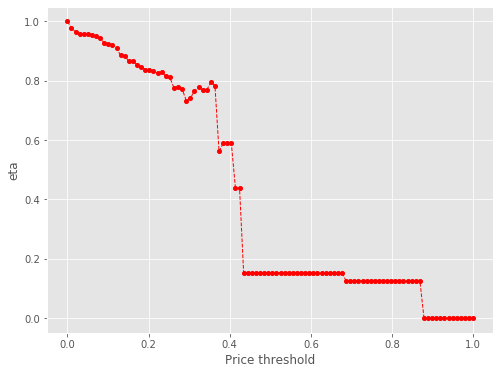

721 144
Number of cells with price above 25.0th percentile:  144


eta =  1.0
eta =  0.9812747115052708
eta =  0.9796330460661632
eta =  0.9769246894726497
eta =  0.9764267155486676
eta =  0.9745802178322684
eta =  0.9675334803465814
eta =  0.9633938914660108
eta =  0.9474516155082928
eta =  0.9451870908125583
eta =  0.939352904161259
eta =  0.9201873118416871
eta =  0.9038125522163911
eta =  0.9020533345773109
eta =  0.8838641529037039
eta =  0.8838641529037039
eta =  0.8730299075114782
eta =  0.8646361201212325
eta =  0.8555753192540055
eta =  0.8554586131488877
eta =  0.8468541580599923
eta =  0.8430022446763424
eta =  0.8479964546991743
eta =  0.8329339079040855
eta =  0.8283974341742758
eta =  0.7931937634390741
eta =  0.7966770824281066
eta =  0.7889239782876533
eta =  0.7487432422411071
eta =  0.75647674796662
eta =  0.7823353031543919
eta =  0.795333269536429
eta =  0.7867339939434663
eta =  0.7855644897481048
eta =  0.8116601912453584
eta =  0.8002052577376382
eta =  0.5851881590933584
eta =  0.5917107486076072
eta =  0.601433187905241
eta = 

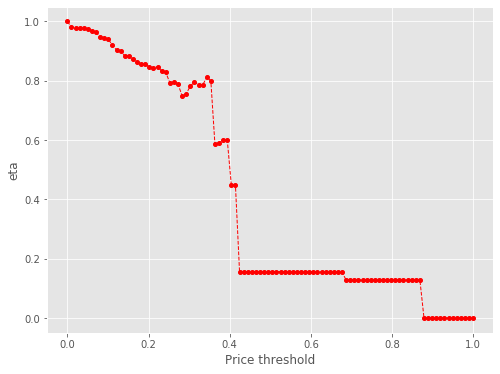

721 137
Number of cells with price above 26.0th percentile:  137


eta =  1.0
eta =  0.9977286789742922
eta =  0.9957446711753938
eta =  0.9931777578750267
eta =  0.9913522868006416
eta =  0.9867939275141259
eta =  0.9698596454597609
eta =  0.9661833192775576
eta =  0.963542797269176
eta =  0.9489364853987587
eta =  0.9314044920627459
eta =  0.9210596600720985
eta =  0.9015620565226523
eta =  0.9007305931158263
eta =  0.9009425784004734
eta =  0.8913594961770038
eta =  0.8718119818365649
eta =  0.8717830013540431
eta =  0.876442892870606
eta =  0.8630143507529324
eta =  0.8612879463581894
eta =  0.86417844540022
eta =  0.8488284658088955
eta =  0.8369330263346952
eta =  0.8083299754278989
eta =  0.8042057816158256
eta =  0.7756378262190582
eta =  0.7630312220036105
eta =  0.7709123032490955
eta =  0.7972643073154237
eta =  0.8105103088985056
eta =  0.8017469366316595
eta =  0.8005551152368459
eta =  0.8271487909846117
eta =  0.8154752673796384
eta =  0.5963550800118782
eta =  0.6030021375970503
eta =  0.6129101064702314
eta =  0.6129101064702314
eta =

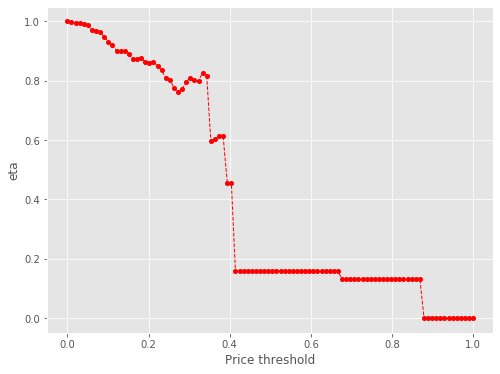

721 134
Number of cells with price above 27.0th percentile:  134


eta =  1.0
eta =  0.9980114756238759
eta =  0.9954387187667653
eta =  0.9936090920226871
eta =  0.989040355669231
eta =  0.9720675228628469
eta =  0.968382827554717
eta =  0.959202344777892
eta =  0.9510967314022748
eta =  0.9335248266294898
eta =  0.9231564447149974
eta =  0.9036144550335035
eta =  0.9027810988071586
eta =  0.9029935666745402
eta =  0.8917149729462929
eta =  0.873796654550238
eta =  0.8737676080938892
eta =  0.8784381078146684
eta =  0.8649789957327358
eta =  0.8610446415838802
eta =  0.8661457404317899
eta =  0.850760816739805
eta =  0.8461272509083897
eta =  0.8101701318828449
eta =  0.8137280027774656
eta =  0.8058089624452037
eta =  0.7647682562237654
eta =  0.7726672786850494
eta =  0.7990792728690986
eta =  0.8123554288644333
eta =  0.8035721068536285
eta =  0.8023775722873385
eta =  0.8290317883163949
eta =  0.8173316900321859
eta =  0.6262862753392316
eta =  0.60437486693974
eta =  0.6143053912215185
eta =  0.6143053912215185
eta =  0.6143053912215185
eta =  0

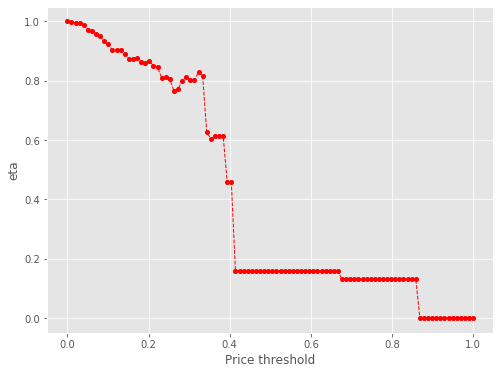

721 130
Number of cells with price above 28.000000000000004th percentile:  130


eta =  1.0
eta =  0.9974221169596248
eta =  0.9946772686836247
eta =  0.9875032127894193
eta =  0.9740043542637514
eta =  0.9671659275116686
eta =  0.9611135424853471
eta =  0.9515050893578404
eta =  0.9366214409366314
eta =  0.924995821453771
eta =  0.9045798779446028
eta =  0.9045798779446028
eta =  0.9047927691513384
eta =  0.8951687334915165
eta =  0.8755376825742521
eta =  0.8755085782432316
eta =  0.8801883838715783
eta =  0.8667024546907349
eta =  0.8627602613944142
eta =  0.8678715241128323
eta =  0.8524559461683326
eta =  0.8478131480196253
eta =  0.811784384920416
eta =  0.8153493448247063
eta =  0.8074145259116157
eta =  0.7620752011822004
eta =  0.7742068077945099
eta =  0.8006714275199882
eta =  0.8253715495181784
eta =  0.8051732134155074
eta =  0.8354688159325202
eta =  0.830683622949477
eta =  0.8189602123775743
eta =  0.7352190012304837
eta =  0.6055790756934271
eta =  0.6155293864106166
eta =  0.6155293864106166
eta =  0.6155293864106166
eta =  0.4587271906033259
eta 

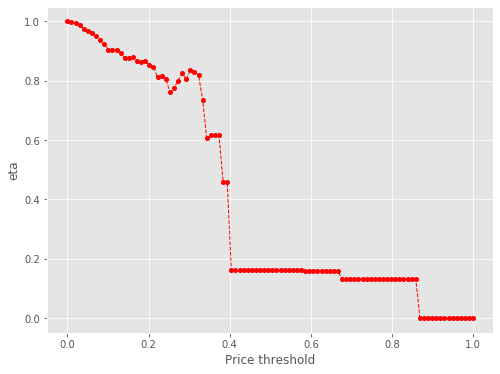

721 127
Number of cells with price above 29.000000000000004th percentile:  127


eta =  1.0
eta =  0.992769463860696
eta =  0.9847356499132933
eta =  0.9721638077321978
eta =  0.9698402178887967
eta =  0.9635975843558044
eta =  0.954172779371074
eta =  0.9278490486042184
eta =  0.9273865154237546
eta =  0.9069178059756418
eta =  0.9069178059756418
eta =  0.90161434226192
eta =  0.8974823379896564
eta =  0.8778005497242183
eta =  0.8777713701717241
eta =  0.8764249694615843
eta =  0.8649901047154526
eta =  0.8686947955092904
eta =  0.8747634313151489
eta =  0.8546591575157939
eta =  0.8585749350608317
eta =  0.8138824787592681
eta =  0.8174566524653386
eta =  0.8095013256501705
eta =  0.7682725634494365
eta =  0.7762077806681015
eta =  0.8027407994126112
eta =  0.8275047600048245
eta =  0.807254220379495
eta =  0.837628123265628
eta =  0.8328305627326517
eta =  0.8210768524704025
eta =  0.7371192083363889
eta =  0.6071442224876398
eta =  0.6171202502375762
eta =  0.6171202502375762
eta =  0.6171202502375762
eta =  0.45991279198984814
eta =  0.45991279198984814
eta =

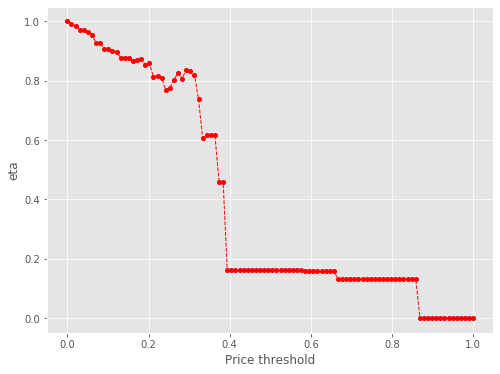

721 123
Number of cells with price above 30.0th percentile:  123


eta =  1.0
eta =  0.9828390897205611
eta =  0.9791135639753182
eta =  0.9698313514506199
eta =  0.9616359190507634
eta =  0.9438692984350706
eta =  0.9333860235564873
eta =  0.9316007036902084
eta =  0.9127848966246628
eta =  0.9129997188674194
eta =  0.9015961460368489
eta =  0.8929277071934766
eta =  0.8836627641988593
eta =  0.8834499048349318
eta =  0.8783093519153022
eta =  0.8705859539990733
eta =  0.8768160303765372
eta =  0.8701971445745939
eta =  0.8493096178306153
eta =  0.8461050874670695
eta =  0.8191476993217793
eta =  0.8253739798320175
eta =  0.7860180373961158
eta =  0.7806563175048885
eta =  0.781229273665205
eta =  0.8079339415108135
eta =  0.8213572117739883
eta =  0.812476560989156
eta =  0.8112687896788725
eta =  0.8382183634513409
eta =  0.826388615335257
eta =  0.7418878270424598
eta =  0.6110719987060504
eta =  0.6211125640124672
eta =  0.6211125640124672
eta =  0.6211125640124672
eta =  0.46288808922568303
eta =  0.46288808922568303
eta =  0.16161609695995433
e

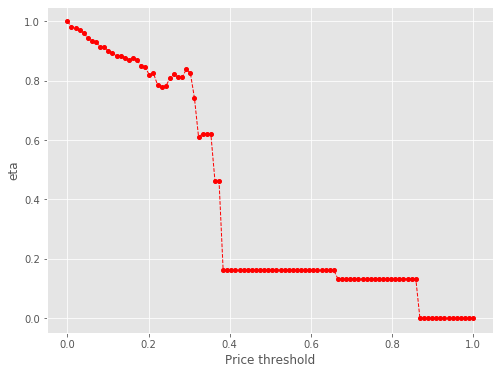

721 118
Number of cells with price above 31.0th percentile:  118


eta =  1.0
eta =  0.9929790593623661
eta =  0.9867651394760463
eta =  0.9769002419676879
eta =  0.960349774756547
eta =  0.9496834561411936
eta =  0.9295799250367489
eta =  0.928722622219049
eta =  0.9289411953761441
eta =  0.9173385099011364
eta =  0.9085187153548725
eta =  0.8990920013672843
eta =  0.8988754253619609
eta =  0.8971291004185883
eta =  0.8857868628796567
eta =  0.8921257198122144
eta =  0.8988987973955758
eta =  0.875207531092305
eta =  0.8608785469731697
eta =  0.8334504680259286
eta =  0.8291981065307577
eta =  0.7997423440083106
eta =  0.7867439640113043
eta =  0.7948699658326803
eta =  0.8220409118450139
eta =  0.8474002666467293
eta =  0.8266628479542443
eta =  0.8379592270970845
eta =  0.825433988293578
eta =  0.8408178144096956
eta =  0.7548415959456719
eta =  0.6217416514027635
eta =  0.631957530493685
eta =  0.631957530493685
eta =  0.631957530493685
eta =  0.47097036948061405
eta =  0.47097036948061405
eta =  0.1644380027720557
eta =  0.1644380027720557
eta = 

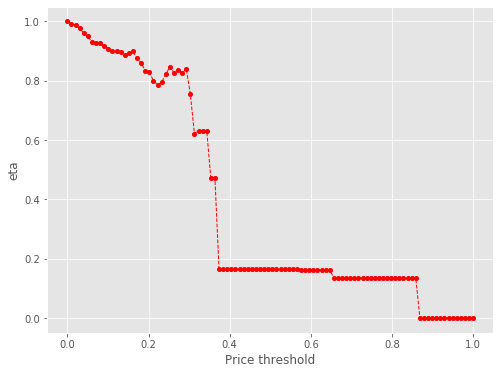

721 113
Number of cells with price above 32.0th percentile:  113


eta =  1.0
eta =  0.9938274795455748
eta =  0.9735504439133005
eta =  0.9567030027111195
eta =  0.9562260858211699
eta =  0.9351208469678355
eta =  0.9351208469678355
eta =  0.929652457829193
eta =  0.9253919578044999
eta =  0.9050981115580712
eta =  0.90506802458915
eta =  0.9069467524668808
eta =  0.8959645834053541
eta =  0.8918892914117462
eta =  0.8906476830427056
eta =  0.8812370757074444
eta =  0.8700923208748838
eta =  0.8507162318328247
eta =  0.8391923367861293
eta =  0.8455709750893301
eta =  0.8182864716555486
eta =  0.7997590664738421
eta =  0.8003460429366341
eta =  0.8277041770448156
eta =  0.8414559162596021
eta =  0.8323579549389813
eta =  0.8311206293272275
eta =  0.8587296622381824
eta =  0.8466104388388525
eta =  0.7600419066359114
eta =  0.6260250000864119
eta =  0.6363112591690192
eta =  0.6363112591690192
eta =  0.6363112591690192
eta =  0.47421501346996353
eta =  0.47421501346996353
eta =  0.16557086125294776
eta =  0.16557086125294776
eta =  0.16557086125294776

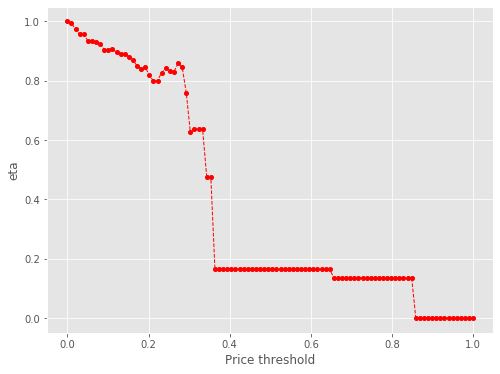

721 109
Number of cells with price above 33.0th percentile:  109


eta =  1.0
eta =  0.9815245871501657
eta =  0.9706230862069277
eta =  0.9687665417175734
eta =  0.949200085543475
eta =  0.949200085543475
eta =  0.9375649642193273
eta =  0.9393247176099881
eta =  0.9205057186119604
eta =  0.9186947859715874
eta =  0.9172856134304598
eta =  0.9094542828019513
eta =  0.9076349783265651
eta =  0.9106810189062104
eta =  0.8945050368172995
eta =  0.883192485851583
eta =  0.8509467638708185
eta =  0.8555680783149407
eta =  0.8583019451340267
eta =  0.8306066444920472
eta =  0.8118002895269127
eta =  0.8260673399827493
eta =  0.8401661434488948
eta =  0.8541249297184688
eta =  0.8448899889171742
eta =  0.8436340340528053
eta =  0.8716587503082781
eta =  0.8593570591154605
eta =  0.7714851456201655
eta =  0.6354504720552071
eta =  0.6458916017046983
eta =  0.6458916017046983
eta =  0.6458916017046983
eta =  0.4813548246852121
eta =  0.4813548246852121
eta =  0.4813548246852121
eta =  0.16806370660476844
eta =  0.16806370660476844
eta =  0.16806370660476844
e

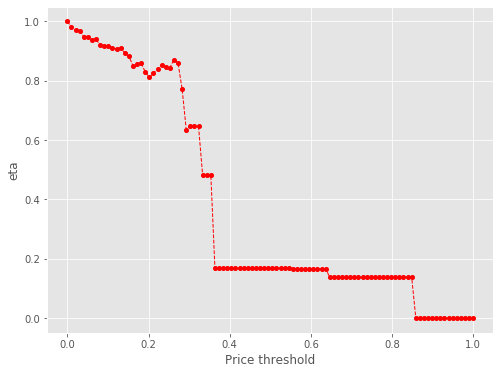

721 100
Number of cells with price above 34.0th percentile:  100


eta =  1.0
eta =  0.9902985168387386
eta =  0.9684412520727018
eta =  0.9684412520727018
eta =  0.968669172936114
eta =  0.9565702760426863
eta =  0.9473732858229378
eta =  0.9375434200711397
eta =  0.9373175817715801
eta =  0.9354965718443701
eta =  0.9236692614497298
eta =  0.9278523830396161
eta =  0.9363426295997481
eta =  0.9126374839554383
eta =  0.9168188998274918
eta =  0.8690945988448587
eta =  0.8729112371732998
eta =  0.87084140435961
eta =  0.8545975467115825
eta =  0.8288641264134349
eta =  0.8428124915003695
eta =  0.8571970907955363
eta =  0.8714388346156302
eta =  0.8620166929948756
eta =  0.8607352787599625
eta =  0.8893280820190276
eta =  0.8767770241305709
eta =  0.787123865409369
eta =  0.6483316427800174
eta =  0.6589844238161855
eta =  0.6589844238161855
eta =  0.6589844238161855
eta =  0.49111233364720513
eta =  0.49111233364720513
eta =  0.49111233364720513
eta =  0.17147051388971504
eta =  0.17147051388971504
eta =  0.17147051388971504
eta =  0.1714705138897150

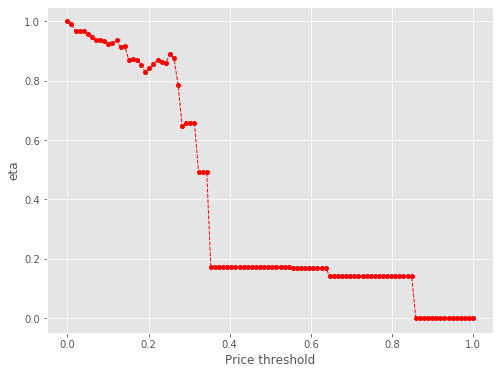

721 95
Number of cells with price above 35.0th percentile:  95


eta =  1.0
eta =  0.9798358024116942
eta =  0.9798358024116942
eta =  0.9678251540642743
eta =  0.9696417040223346
eta =  0.9483774608120954
eta =  0.9483459351655112
eta =  0.9503144987405385
eta =  0.9388071919902784
eta =  0.9345370305308622
eta =  0.93323605180014
eta =  0.9341196601341467
eta =  0.9096550083302625
eta =  0.9082578604976806
eta =  0.8793202497397266
eta =  0.8676372243780762
eta =  0.8745868432018287
eta =  0.8254755433484711
eta =  0.8386164309465073
eta =  0.8527289106328454
eta =  0.8590060935895607
eta =  0.8816920674752682
eta =  0.8721590661954799
eta =  0.8708625750119409
eta =  0.8997917973727025
eta =  0.8870930654145887
eta =  0.7963850596100844
eta =  0.6559598262389599
eta =  0.6667379464730474
eta =  0.6667379464730474
eta =  0.6667379464730474
eta =  0.49689069572736877
eta =  0.49689069572736877
eta =  0.49689069572736877
eta =  0.17348801303897948
eta =  0.17348801303897948
eta =  0.17348801303897948
eta =  0.17348801303897948
eta =  0.1734880130389

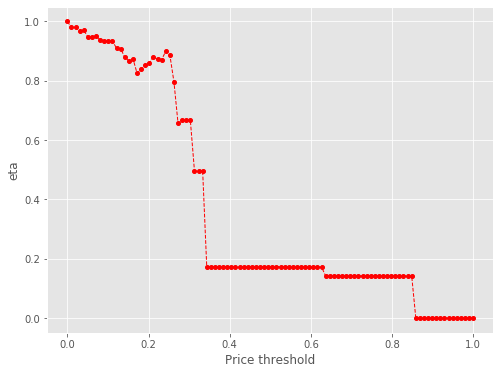

721 90
Number of cells with price above 36.00000000000001th percentile:  90


eta =  1.0
eta =  0.9877421826005359
eta =  0.9805864585857442
eta =  0.9697699490670765
eta =  0.9678620977426257
eta =  0.9663775081786448
eta =  0.95812705524698
eta =  0.9537690174523762
eta =  0.9524412656724146
eta =  0.953343057923557
eta =  0.9304597621753283
eta =  0.926949044178793
eta =  0.8974159217038546
eta =  0.8928372010035764
eta =  0.8925851056362569
eta =  0.8824464518446877
eta =  0.8558744525178604
eta =  0.870277355179309
eta =  0.8766837172873941
eta =  0.8998365494556716
eta =  0.8901073670188547
eta =  0.888784195136027
eta =  0.9183087565876065
eta =  0.9053486953948451
eta =  0.8127739950407222
eta =  0.649445804176624
eta =  0.6804588532405008
eta =  0.6804588532405008
eta =  0.6804588532405008
eta =  0.6804588532405008
eta =  0.5071162887744655
eta =  0.5071162887744655
eta =  0.17705825058848546
eta =  0.17705825058848546
eta =  0.17705825058848546
eta =  0.17705825058848546
eta =  0.17705825058848546
eta =  0.17705825058848546
eta =  0.17705825058848546
e

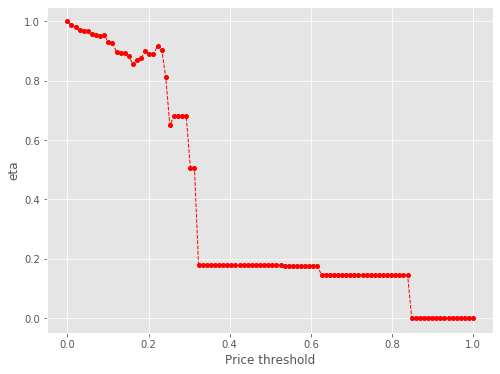

721 86
Number of cells with price above 37.0th percentile:  86


eta =  1.0
eta =  0.9903854526425426
eta =  0.9801092962555136
eta =  0.9798732045587344
eta =  0.9779695180520371
eta =  0.965605230042201
eta =  0.9697408482264065
eta =  0.9713257786509738
eta =  0.9540725933184991
eta =  0.9420067083959157
eta =  0.9087537222094447
eta =  0.9085527959746849
eta =  0.9154586379501715
eta =  0.8718072286036488
eta =  0.8576375629276628
eta =  0.8664957998093257
eta =  0.8961151232314525
eta =  0.9024625640156614
eta =  0.9110034635622976
eta =  0.901153542592838
eta =  0.8998139502314546
eta =  0.9297049096049289
eta =  0.9165840148805182
eta =  0.8228604684077013
eta =  0.6777668708901907
eta =  0.6889033041486424
eta =  0.6889033041486424
eta =  0.6889033041486424
eta =  0.6889033041486424
eta =  0.513409569528888
eta =  0.513409569528888
eta =  0.17925553216966497
eta =  0.17925553216966497
eta =  0.17925553216966497
eta =  0.17925553216966497
eta =  0.17925553216966497
eta =  0.17925553216966497
eta =  0.17925553216966497
eta =  0.179255532169664

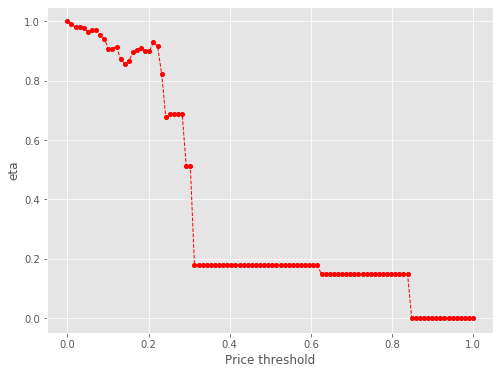

721 82
Number of cells with price above 38.0th percentile:  82


eta =  1.0
eta =  0.9895206773619907
eta =  0.9893857002283712
eta =  0.9874635329533796
eta =  0.9749792138664567
eta =  0.979394708426505
eta =  0.9807552968990872
eta =  0.9633346196401071
eta =  0.9511516005030739
eta =  0.9175757981750556
eta =  0.9173729213716617
eta =  0.9243458044618369
eta =  0.8802706322851331
eta =  0.8659634091346128
eta =  0.8749076407547637
eta =  0.9048145051408435
eta =  0.8961796680851671
eta =  0.9198473797566005
eta =  0.9099018368942956
eta =  0.9085492399252983
eta =  0.938730377273105
eta =  0.9254821064211841
eta =  0.8308487026057867
eta =  0.6638883713127225
eta =  0.6843465532351831
eta =  0.6955910976988942
eta =  0.6955910976988942
eta =  0.6955910976988942
eta =  0.5183936902132504
eta =  0.5183936902132504
eta =  0.18099572413081802
eta =  0.18099572413081802
eta =  0.18099572413081802
eta =  0.18099572413081802
eta =  0.18099572413081802
eta =  0.18099572413081802
eta =  0.18099572413081802
eta =  0.18099572413081802
eta =  0.180995724130

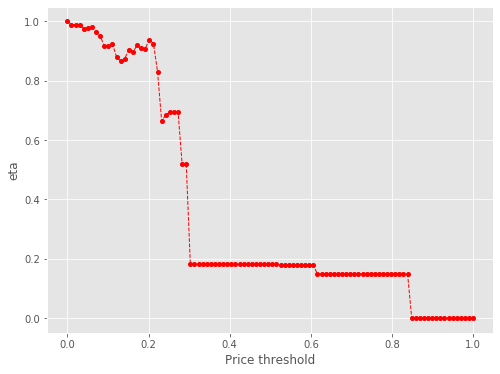

721 76
Number of cells with price above 39.0th percentile:  76


eta =  1.0
eta =  0.9941812740128259
eta =  0.9854389583773151
eta =  0.9899018231215996
eta =  0.9965732091991257
eta =  0.9736694389435274
eta =  0.9683664661753754
eta =  0.9274197089802891
eta =  0.9272146556796936
eta =  0.9342623450576234
eta =  0.8897143268615546
eta =  0.8752536133630495
eta =  0.8842938002366686
eta =  0.8991749518956095
eta =  0.9057940375308738
eta =  0.9297156604793058
eta =  0.9196634201244984
eta =  0.9182963122628374
eta =  0.9182963122628374
eta =  0.9354108374596107
eta =  0.8884045017869864
eta =  0.6840636707593822
eta =  0.691688340631183
eta =  0.703053518499749
eta =  0.703053518499749
eta =  0.703053518499749
eta =  0.5239551067835265
eta =  0.5239551067835265
eta =  0.5239551067835265
eta =  0.1829374773549288
eta =  0.1829374773549288
eta =  0.1829374773549288
eta =  0.1829374773549288
eta =  0.1829374773549288
eta =  0.1829374773549288
eta =  0.1829374773549288
eta =  0.1829374773549288
eta =  0.1829374773549288
eta =  0.1829374773549288
eta =

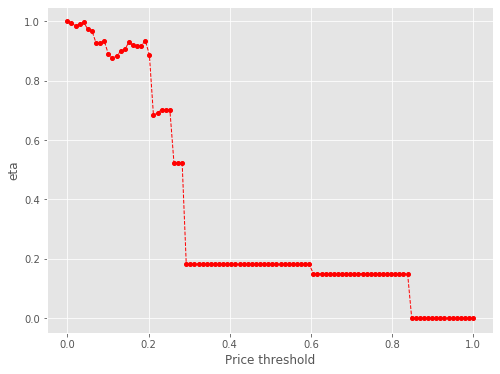

721 71
Number of cells with price above 40.0th percentile:  71


eta =  1.0
eta =  0.9873571846753835
eta =  0.9918287367000361
eta =  0.9932065986941018
eta =  0.975564755043555
eta =  0.9632270648601055
eta =  0.9417769578672243
eta =  0.9290195442741206
eta =  0.9242795782054835
eta =  0.9240186049849325
eta =  0.9135229058367453
eta =  0.8860151403647532
eta =  0.9009252592328906
eta =  0.9163016910960314
eta =  0.9315254174556222
eta =  0.9214536097073815
eta =  0.9340453082015776
eta =  0.9200838406740364
eta =  0.937231680498806
eta =  0.937231680498806
eta =  0.7181605038297383
eta =  0.693034760674542
eta =  0.7044220616618301
eta =  0.7044220616618301
eta =  0.7044220616618301
eta =  0.7044220616618301
eta =  0.5249750222803671
eta =  0.5249750222803671
eta =  0.18329357803166918
eta =  0.18329357803166918
eta =  0.18329357803166918
eta =  0.18329357803166918
eta =  0.18329357803166918
eta =  0.18329357803166918
eta =  0.18329357803166918
eta =  0.18329357803166918
eta =  0.18329357803166918
eta =  0.18329357803166918
eta =  0.183293578031

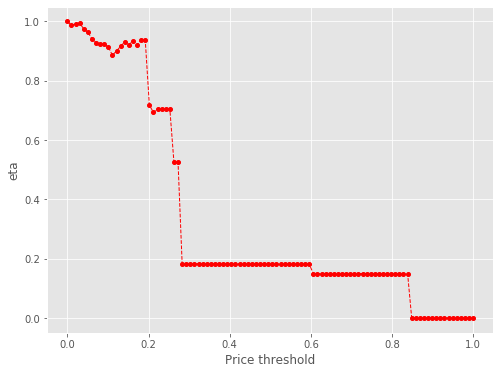

721 68
Number of cells with price above 41.0th percentile:  68


eta =  1.0
eta =  1.0059243140268852
eta =  0.9880565718112382
eta =  0.9755609011715336
eta =  0.9665035186249091
eta =  0.9409153634503173
eta =  0.945047403443129
eta =  0.9428065225346953
eta =  0.931959031155645
eta =  0.8967021738851985
eta =  0.8973603009290414
eta =  0.9280346619418046
eta =  0.9580475304108464
eta =  0.9434533235932068
eta =  0.9332525493399138
eta =  0.9318652408211676
eta =  0.9628209134330153
eta =  0.9492326536388578
eta =  0.901531743021291
eta =  0.6809256667944262
eta =  0.7019088648272642
eta =  0.7134419768195895
eta =  0.7134419768195895
eta =  0.7134419768195895
eta =  0.531697171427344
eta =  0.531697171427344
eta =  0.531697171427344
eta =  0.1856405978267441
eta =  0.1856405978267441
eta =  0.1856405978267441
eta =  0.1856405978267441
eta =  0.1856405978267441
eta =  0.1856405978267441
eta =  0.1856405978267441
eta =  0.1856405978267441
eta =  0.1856405978267441
eta =  0.1856405978267441
eta =  0.1856405978267441
eta =  0.1856405978267441
eta =  

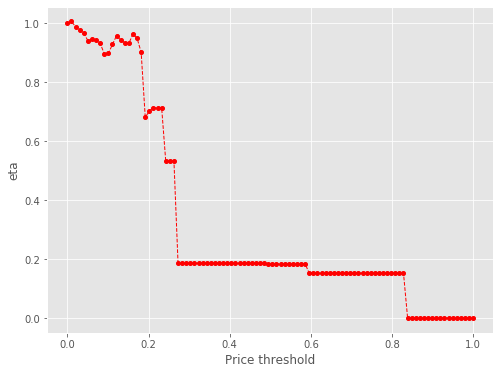

721 60
Number of cells with price above 42.00000000000001th percentile:  60


eta =  1.0
eta =  0.9770174734337838
eta =  0.9646614111337425
eta =  0.9306087103481235
eta =  0.9304029519565646
eta =  0.9256559275805816
eta =  0.9253945657434934
eta =  0.9148832373968425
eta =  0.8873345099727414
eta =  0.9022668315739811
eta =  0.9176661605592538
eta =  0.9459754836353024
eta =  0.922825750918556
eta =  0.9354361997743986
eta =  0.9214539421552442
eta =  0.952063761376657
eta =  0.9386273169146633
eta =  0.8426497747261553
eta =  0.6733179997458704
eta =  0.6940667622271757
eta =  0.7054710201017169
eta =  0.7054710201017169
eta =  0.7054710201017169
eta =  0.5257567652301145
eta =  0.5257567652301145
eta =  0.5257567652301145
eta =  0.1835665214218858
eta =  0.1835665214218858
eta =  0.1835665214218858
eta =  0.1835665214218858
eta =  0.1835665214218858
eta =  0.1835665214218858
eta =  0.1835665214218858
eta =  0.1835665214218858
eta =  0.1835665214218858
eta =  0.1835665214218858
eta =  0.1835665214218858
eta =  0.1835665214218858
eta =  0.1835665214218858
eta

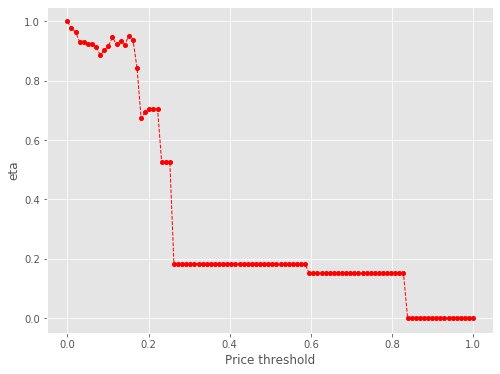

721 53
Number of cells with price above 43.0th percentile:  53


eta =  1.0
eta =  0.9646998414235337
eta =  0.9644865454533785
eta =  0.9595656226081245
eta =  0.9592946862629245
eta =  0.9483982948189076
eta =  0.9198403706538643
eta =  0.9353197102738561
eta =  0.9512831652307349
eta =  0.9820478959953647
eta =  0.9670880848753066
eta =  0.9566317676520116
eta =  0.9552097052086727
eta =  0.9869408586145477
eta =  0.9730121948296014
eta =  0.9241163129217844
eta =  0.7115614519673765
eta =  0.7194926159754398
eta =  0.7313146477711744
eta =  0.7313146477711744
eta =  0.7313146477711744
eta =  0.7313146477711744
eta =  0.5450168931420256
eta =  0.5450168931420256
eta =  0.19029114184856286
eta =  0.19029114184856286
eta =  0.19029114184856286
eta =  0.19029114184856286
eta =  0.19029114184856286
eta =  0.19029114184856286
eta =  0.19029114184856286
eta =  0.19029114184856286
eta =  0.19029114184856286
eta =  0.19029114184856286
eta =  0.19029114184856286
eta =  0.19029114184856286
eta =  0.19029114184856286
eta =  0.19029114184856286
eta =  0.1902

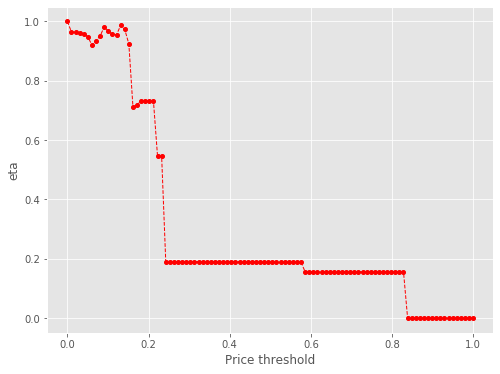

721 43
Number of cells with price above 44.0th percentile:  43


eta =  1.0
eta =  1.0054307914905285
eta =  1.00864352692259
eta =  0.960548823728785
eta =  0.9449368223010174
eta =  0.9546967425423538
eta =  0.9707626552630665
eta =  0.9873310283561286
eta =  1.0037348586099482
eta =  0.9928823103738088
eta =  1.0064500847693294
eta =  0.9914063603876362
eta =  1.0243399320813493
eta =  1.0098834564061152
eta =  0.9066197538736794
eta =  0.7244331126851619
eta =  0.7467570229242617
eta =  0.7590270380330756
eta =  0.7590270380330756
eta =  0.7590270380330756
eta =  0.5656697282631493
eta =  0.5656697282631493
eta =  0.5656697282631493
eta =  0.19750202214798251
eta =  0.19750202214798251
eta =  0.19750202214798251
eta =  0.19750202214798251
eta =  0.19750202214798251
eta =  0.19750202214798251
eta =  0.19750202214798251
eta =  0.19750202214798251
eta =  0.19750202214798251
eta =  0.19750202214798251
eta =  0.19750202214798251
eta =  0.19750202214798251
eta =  0.19750202214798251
eta =  0.19750202214798251
eta =  0.19750202214798251
eta =  0.197502

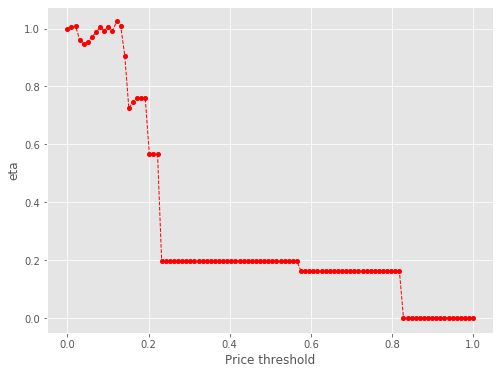

721 39
Number of cells with price above 45.0th percentile:  39


eta =  1.0
eta =  0.9997176468822803
eta =  0.9883621010110138
eta =  0.958600797049934
eta =  0.974732408328294
eta =  0.9913685346971083
eta =  1.0234296361369561
eta =  1.0078394453593866
eta =  0.9969425176486225
eta =  0.9954605320398907
eta =  1.0285287794408646
eta =  1.0140131867010083
eta =  1.0140131867010083
eta =  0.7769948841930149
eta =  0.7498107466791485
eta =  0.7621309377293467
eta =  0.7621309377293467
eta =  0.7621309377293467
eta =  0.7621309377293467
eta =  0.5679829292556932
eta =  0.5679829292556932
eta =  0.5679829292556932
eta =  0.198309669880989
eta =  0.198309669880989
eta =  0.198309669880989
eta =  0.198309669880989
eta =  0.198309669880989
eta =  0.198309669880989
eta =  0.198309669880989
eta =  0.198309669880989
eta =  0.198309669880989
eta =  0.198309669880989
eta =  0.198309669880989
eta =  0.198309669880989
eta =  0.198309669880989
eta =  0.198309669880989
eta =  0.198309669880989
eta =  0.198309669880989
eta =  0.198309669880989
eta =  0.19830966988

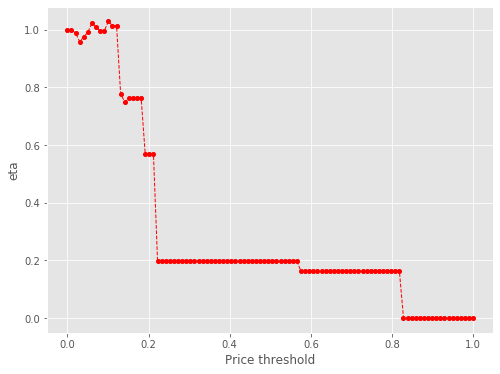

721 32
Number of cells with price above 46.0th percentile:  32


eta =  1.0
eta =  0.9698882586345262
eta =  0.986209818578861
eta =  1.003041834245788
eta =  1.035480453054676
eta =  1.0197066888020585
eta =  1.008681450481389
eta =  1.0071820145892034
eta =  1.0071820145892034
eta =  1.0259531255435184
eta =  1.0259531255435184
eta =  0.7861439480512379
eta =  0.758639719099056
eta =  0.7711049795917395
eta =  0.7711049795917395
eta =  0.7711049795917395
eta =  0.7711049795917395
eta =  0.5746708910374982
eta =  0.5746708910374982
eta =  0.5746708910374982
eta =  0.2006447532520059
eta =  0.2006447532520059
eta =  0.2006447532520059
eta =  0.2006447532520059
eta =  0.2006447532520059
eta =  0.2006447532520059
eta =  0.2006447532520059
eta =  0.2006447532520059
eta =  0.2006447532520059
eta =  0.2006447532520059
eta =  0.2006447532520059
eta =  0.2006447532520059
eta =  0.2006447532520059
eta =  0.2006447532520059
eta =  0.2006447532520059
eta =  0.2006447532520059
eta =  0.2006447532520059
eta =  0.2006447532520059
eta =  0.2006447532520059
eta = 

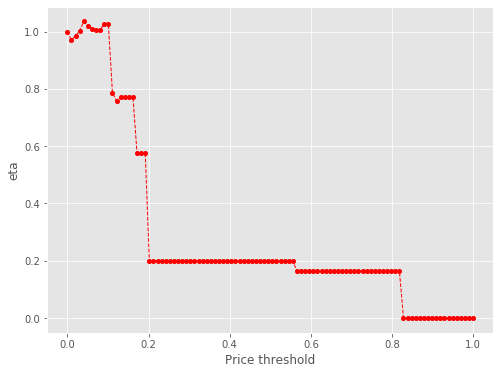

721 28
Number of cells with price above 47.0th percentile:  28


eta =  1.0
eta =  1.0341828817042675
eta =  1.0415082960751225
eta =  1.0513651234809978
eta =  1.039997588899033
eta =  1.0791287386280262
eta =  1.0384516006072513
eta =  1.072947970214642
eta =  1.057805490900492
eta =  0.9496416123295388
eta =  0.7588096621718842
eta =  0.782192909693659
eta =  0.795045174252705
eta =  0.795045174252705
eta =  0.795045174252705
eta =  0.795045174252705
eta =  0.5925124733920982
eta =  0.5925124733920982
eta =  0.20687409241811738
eta =  0.20687409241811738
eta =  0.20687409241811738
eta =  0.20687409241811738
eta =  0.20687409241811738
eta =  0.20687409241811738
eta =  0.20687409241811738
eta =  0.20687409241811738
eta =  0.20687409241811738
eta =  0.20687409241811738
eta =  0.20687409241811738
eta =  0.20687409241811738
eta =  0.20687409241811738
eta =  0.20687409241811738
eta =  0.20687409241811738
eta =  0.20687409241811738
eta =  0.20687409241811738
eta =  0.20687409241811738
eta =  0.20687409241811738
eta =  0.20687409241811738
eta =  0.206874

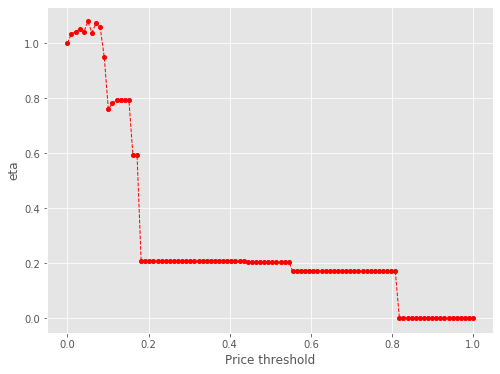

721 26
Number of cells with price above 48.00000000000001th percentile:  26


eta =  1.0
eta =  1.01661431655919
eta =  1.0056225134815453
eta =  1.01936438323531
eta =  1.0041276247929662
eta =  1.0374837847310838
eta =  1.0228418102969332
eta =  1.0228418102969332
eta =  0.7837598804065424
eta =  0.756339061041752
eta =  0.7687665192664196
eta =  0.7687665192664196
eta =  0.7687665192664196
eta =  0.7687665192664196
eta =  0.5729281386051135
eta =  0.5729281386051135
eta =  0.5729281386051135
eta =  0.20003627605709548
eta =  0.20003627605709548
eta =  0.20003627605709548
eta =  0.20003627605709548
eta =  0.20003627605709548
eta =  0.20003627605709548
eta =  0.20003627605709548
eta =  0.20003627605709548
eta =  0.20003627605709548
eta =  0.20003627605709548
eta =  0.20003627605709548
eta =  0.20003627605709548
eta =  0.20003627605709548
eta =  0.20003627605709548
eta =  0.20003627605709548
eta =  0.20003627605709548
eta =  0.20003627605709548
eta =  0.20003627605709548
eta =  0.20003627605709548
eta =  0.20003627605709548
eta =  0.20003627605709548
eta =  0.20

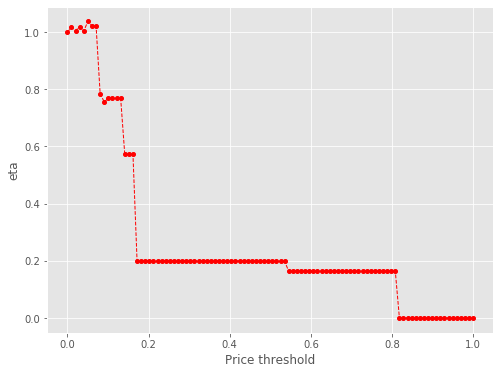

721 20
Number of cells with price above 49.0th percentile:  20


eta =  1.0
eta =  0.9891878336763469
eta =  0.9877173756430205
eta =  1.0205284027894945
eta =  1.006125719101439
eta =  1.006125719101439
eta =  0.9032462568145124
eta =  0.7439783689075323
eta =  0.7439783689075323
eta =  0.7562027277644184
eta =  0.7562027277644184
eta =  0.7562027277644184
eta =  0.7562027277644184
eta =  0.5635648930700023
eta =  0.5635648930700023
eta =  0.19676712475792565
eta =  0.19676712475792565
eta =  0.19676712475792565
eta =  0.19676712475792565
eta =  0.19676712475792565
eta =  0.19676712475792565
eta =  0.19676712475792565
eta =  0.19676712475792565
eta =  0.19676712475792565
eta =  0.19676712475792565
eta =  0.19676712475792565
eta =  0.19676712475792565
eta =  0.19676712475792565
eta =  0.19676712475792565
eta =  0.19676712475792565
eta =  0.19676712475792565
eta =  0.19676712475792565
eta =  0.19676712475792565
eta =  0.19676712475792565
eta =  0.19676712475792565
eta =  0.19676712475792565
eta =  0.19676712475792565
eta =  0.19676712475792565
eta = 

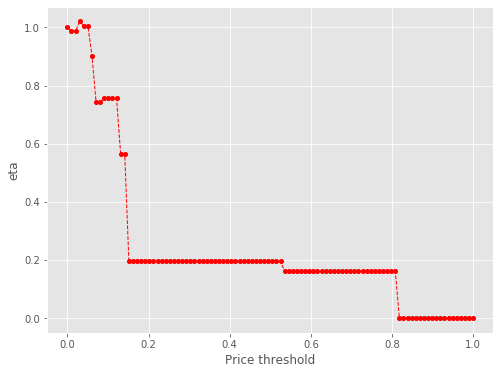

721 15
Number of cells with price above 50.0th percentile:  15


eta =  1.0
eta =  1.0186372578962017
eta =  1.0186372578962017
eta =  0.9144784521245098
eta =  0.7307125933728236
eta =  0.7532300101769395
eta =  0.7656063833767406
eta =  0.7656063833767406
eta =  0.7656063833767406
eta =  0.7656063833767406
eta =  0.5705730272317141
eta =  0.5705730272317141
eta =  0.5705730272317141
eta =  0.1992139954304509
eta =  0.1992139954304509
eta =  0.1992139954304509
eta =  0.1992139954304509
eta =  0.1992139954304509
eta =  0.1992139954304509
eta =  0.1992139954304509
eta =  0.1992139954304509
eta =  0.1992139954304509
eta =  0.1992139954304509
eta =  0.1992139954304509
eta =  0.1992139954304509
eta =  0.1992139954304509
eta =  0.1992139954304509
eta =  0.1992139954304509
eta =  0.1992139954304509
eta =  0.1992139954304509
eta =  0.1992139954304509
eta =  0.1992139954304509
eta =  0.1992139954304509
eta =  0.1992139954304509
eta =  0.1992139954304509
eta =  0.1992139954304509
eta =  0.1992139954304509
eta =  0.1992139954304509
eta =  0.1992139954304509
e

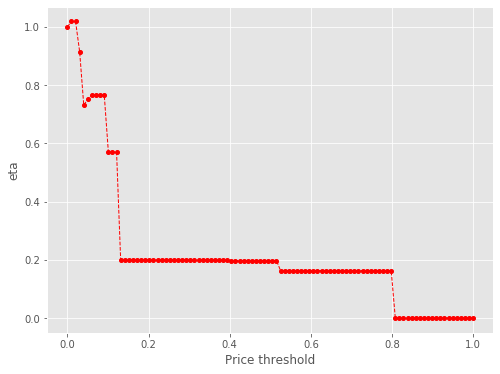

721 13
Number of cells with price above 51.0th percentile:  13


eta =  1.0
eta =  0.7662571792787932
eta =  0.7394487137968923
eta =  0.7515986455845455
eta =  0.7515986455845455
eta =  0.7515986455845455
eta =  0.7515986455845455
eta =  0.7515986455845455
eta =  0.5601336715388974
eta =  0.5601336715388974
eta =  0.5601336715388974
eta =  0.1955691232440181
eta =  0.1955691232440181
eta =  0.1955691232440181
eta =  0.1955691232440181
eta =  0.1955691232440181
eta =  0.1955691232440181
eta =  0.1955691232440181
eta =  0.1955691232440181
eta =  0.1955691232440181
eta =  0.1955691232440181
eta =  0.1955691232440181
eta =  0.1955691232440181
eta =  0.1955691232440181
eta =  0.1955691232440181
eta =  0.1955691232440181
eta =  0.1955691232440181
eta =  0.1955691232440181
eta =  0.1955691232440181
eta =  0.1955691232440181
eta =  0.1955691232440181
eta =  0.1955691232440181
eta =  0.1955691232440181
eta =  0.1955691232440181
eta =  0.1955691232440181
eta =  0.1955691232440181
eta =  0.1955691232440181
eta =  0.1955691232440181
eta =  0.19378822656468606


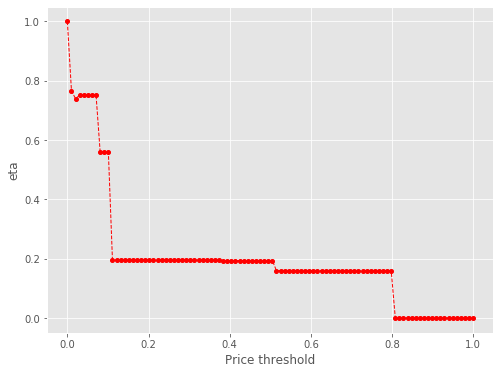

721 11
Number of cells with price above 52.0th percentile:  11


eta =  1.0
eta =  0.8236716878643132
eta =  0.8236716878643132
eta =  0.8372054930305786
eta =  0.8372054930305786
eta =  0.8372054930305786
eta =  0.8372054930305786
eta =  0.6239327191429858
eta =  0.6239327191429858
eta =  0.6239327191429858
eta =  0.21784438437848194
eta =  0.21784438437848194
eta =  0.21784438437848194
eta =  0.21784438437848194
eta =  0.21784438437848194
eta =  0.21784438437848194
eta =  0.21784438437848194
eta =  0.21784438437848194
eta =  0.21784438437848194
eta =  0.21784438437848194
eta =  0.21784438437848194
eta =  0.21784438437848194
eta =  0.21784438437848194
eta =  0.21784438437848194
eta =  0.21784438437848194
eta =  0.21784438437848194
eta =  0.21784438437848194
eta =  0.21784438437848194
eta =  0.21784438437848194
eta =  0.21784438437848194
eta =  0.21784438437848194
eta =  0.21784438437848194
eta =  0.21784438437848194
eta =  0.21784438437848194
eta =  0.21784438437848194
eta =  0.21784438437848194
eta =  0.21784438437848194
eta =  0.21784438437848194

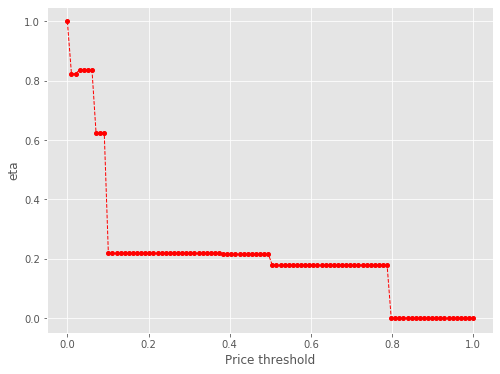

721 7
Number of cells with price above 53.0th percentile:  7


eta =  1.0
eta =  1.0164310675790702
eta =  1.0164310675790702
eta =  1.0164310675790702
eta =  1.0164310675790702
eta =  0.7575017186286592
eta =  0.7575017186286592
eta =  0.7575017186286592
eta =  0.26447963137269853
eta =  0.26447963137269853
eta =  0.26447963137269853
eta =  0.26447963137269853
eta =  0.26447963137269853
eta =  0.26447963137269853
eta =  0.26447963137269853
eta =  0.26447963137269853
eta =  0.26447963137269853
eta =  0.26447963137269853
eta =  0.26447963137269853
eta =  0.26447963137269853
eta =  0.26447963137269853
eta =  0.26447963137269853
eta =  0.26447963137269853
eta =  0.26447963137269853
eta =  0.26447963137269853
eta =  0.26447963137269853
eta =  0.26447963137269853
eta =  0.26447963137269853
eta =  0.26447963137269853
eta =  0.26447963137269853
eta =  0.26447963137269853
eta =  0.26447963137269853
eta =  0.26447963137269853
eta =  0.26447963137269853
eta =  0.26447963137269853
eta =  0.26447963137269853
eta =  0.26207122001690947
eta =  0.262071220016909

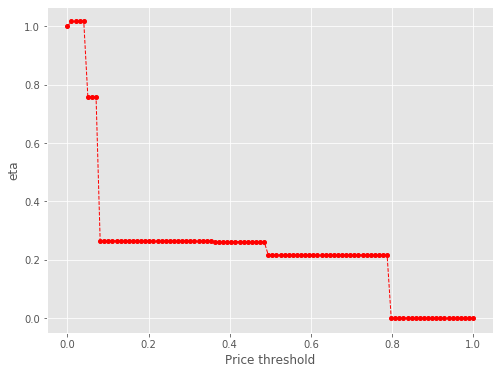

721 6
Number of cells with price above 54.0th percentile:  6


eta =  1.0
eta =  0.7452563609973792
eta =  0.7452563609973792
eta =  0.7452563609973792
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.25783472030337407
eta =  0.25783472030337407
eta =  0.25783472030337407
eta =  0.25783472030337407
eta =  0.25783472030337407
eta =  0.2578347203033

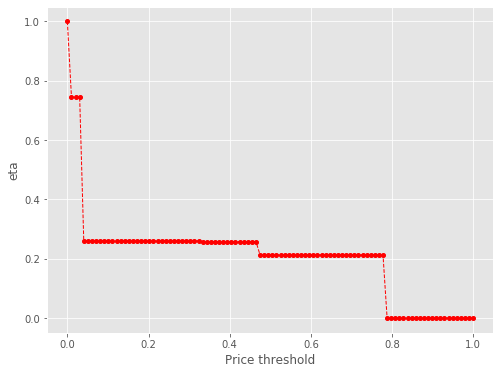

721 6
Number of cells with price above 55.00000000000001th percentile:  6


eta =  1.0
eta =  0.7452563609973792
eta =  0.7452563609973792
eta =  0.7452563609973792
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.2602041986011256
eta =  0.25783472030337407
eta =  0.25783472030337407
eta =  0.25783472030337407
eta =  0.25783472030337407
eta =  0.25783472030337407
eta =  0.2578347203033

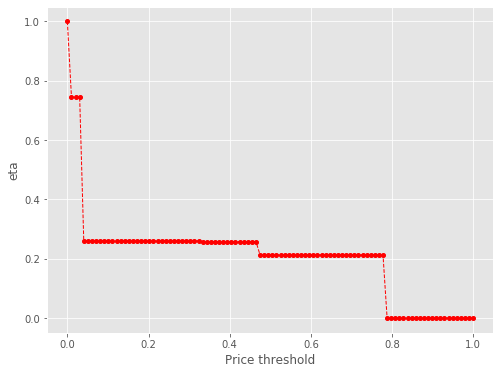

721 5
Number of cells with price above 56.00000000000001th percentile:  5


eta =  1.0
eta =  0.34914723606369946
eta =  0.34914723606369946
eta =  0.34914723606369946
eta =  0.34914723606369946
eta =  0.34914723606369946
eta =  0.34914723606369946
eta =  0.34914723606369946
eta =  0.34914723606369946
eta =  0.34914723606369946
eta =  0.34914723606369946
eta =  0.34914723606369946
eta =  0.34914723606369946
eta =  0.34914723606369946
eta =  0.34914723606369946
eta =  0.34914723606369946
eta =  0.34914723606369946
eta =  0.34914723606369946
eta =  0.34914723606369946
eta =  0.34914723606369946
eta =  0.34914723606369946
eta =  0.34914723606369946
eta =  0.34914723606369946
eta =  0.34914723606369946
eta =  0.34914723606369946
eta =  0.34914723606369946
eta =  0.34914723606369946
eta =  0.34914723606369946
eta =  0.34914723606369946
eta =  0.34914723606369946
eta =  0.34914723606369946
eta =  0.3459678223454717
eta =  0.3459678223454717
eta =  0.3459678223454717
eta =  0.3459678223454717
eta =  0.3459678223454717
eta =  0.3459678223454717
eta =  0.34596782234547

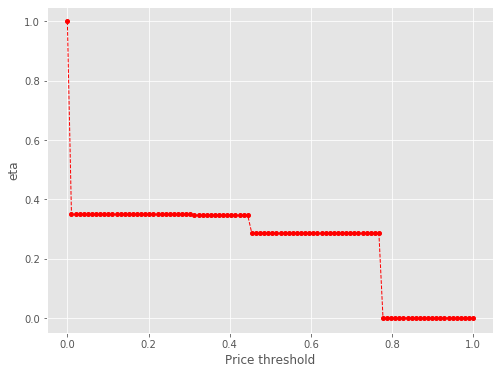

721 4
Number of cells with price above 57.00000000000001th percentile:  4


eta =  1.0
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
e

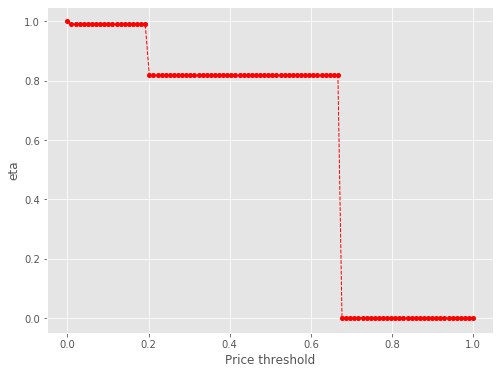

721 4
Number of cells with price above 58.00000000000001th percentile:  4


eta =  1.0
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
e

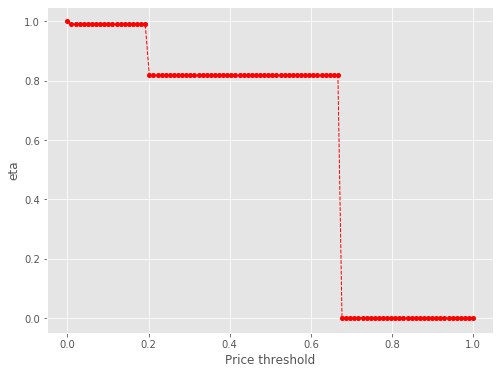

721 4
Number of cells with price above 59.0th percentile:  4


eta =  1.0
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
e

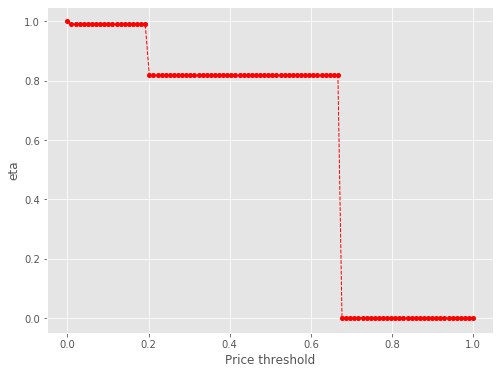

721 4
Number of cells with price above 60.0th percentile:  4


eta =  1.0
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
e

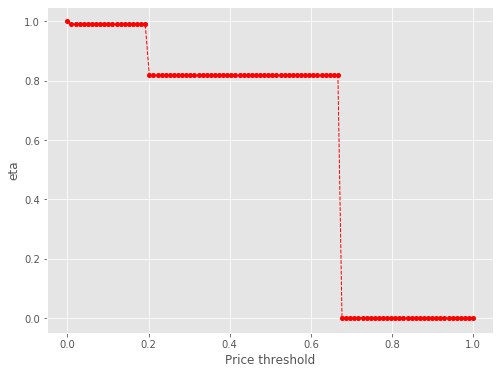

721 4
Number of cells with price above 61.0th percentile:  4


eta =  1.0
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
e

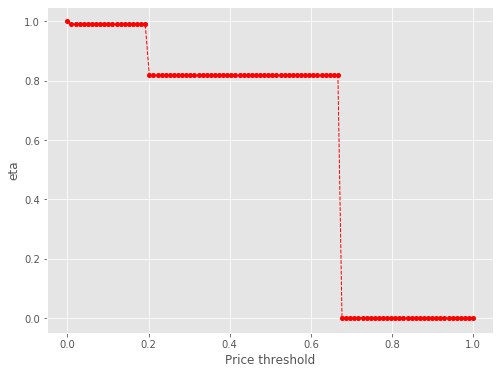

721 4
Number of cells with price above 62.0th percentile:  4


eta =  1.0
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
e

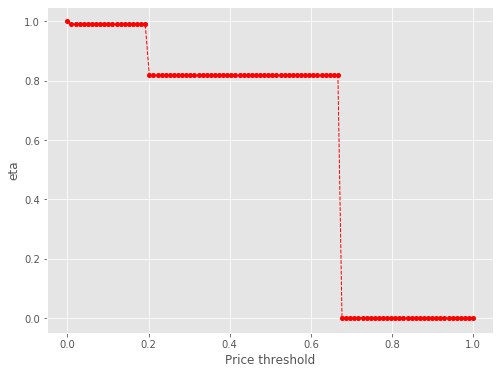

721 4
Number of cells with price above 63.0th percentile:  4


eta =  1.0
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
e

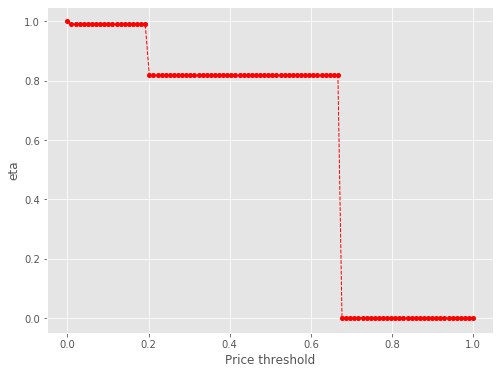

721 4
Number of cells with price above 64.0th percentile:  4


eta =  1.0
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
e

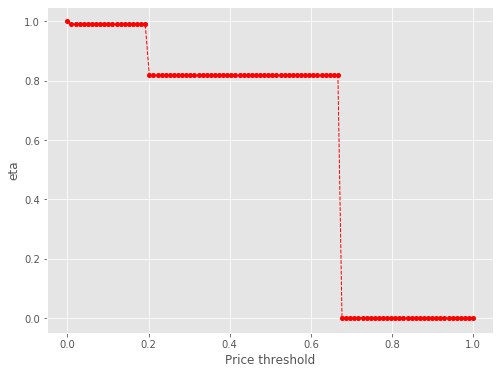

721 4
Number of cells with price above 65.0th percentile:  4


eta =  1.0
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
e

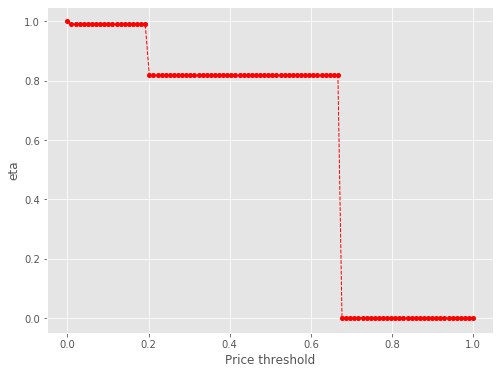

721 4
Number of cells with price above 66.0th percentile:  4


eta =  1.0
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
e

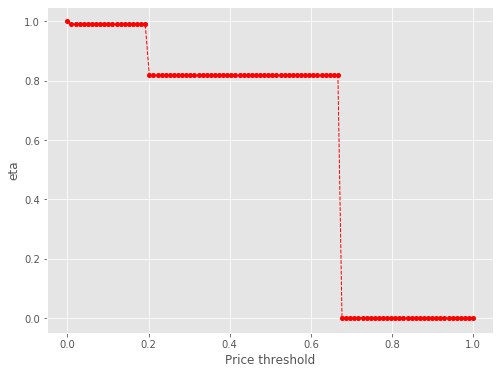

721 4
Number of cells with price above 67.0th percentile:  4


eta =  1.0
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
e

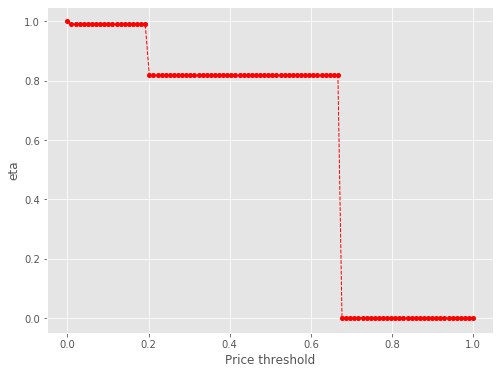

721 4
Number of cells with price above 68.0th percentile:  4


eta =  1.0
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
e

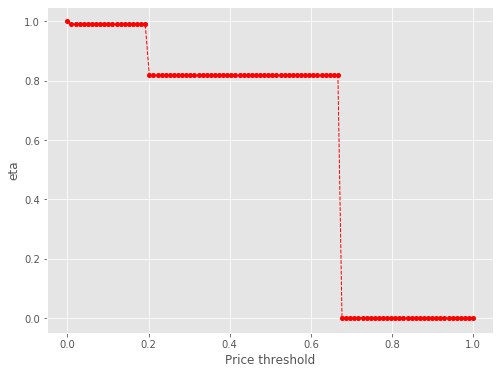

721 4
Number of cells with price above 69.0th percentile:  4


eta =  1.0
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
e

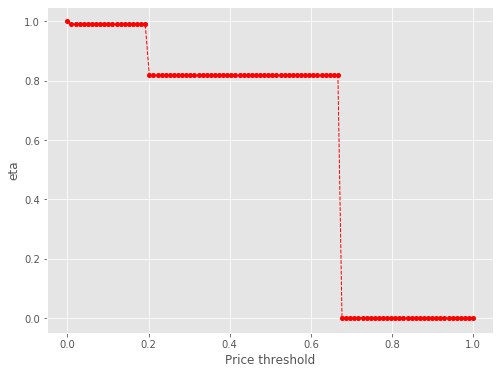

721 4
Number of cells with price above 70.0th percentile:  4


eta =  1.0
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.9908937737727138
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
eta =  0.8180219006804278
e

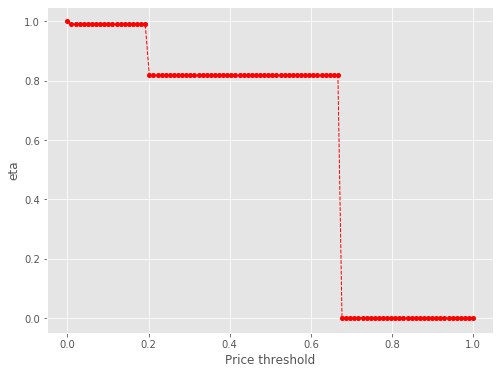

721 3
Number of cells with price above 71.00000000000001th percentile:  3


eta =  1.0
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =

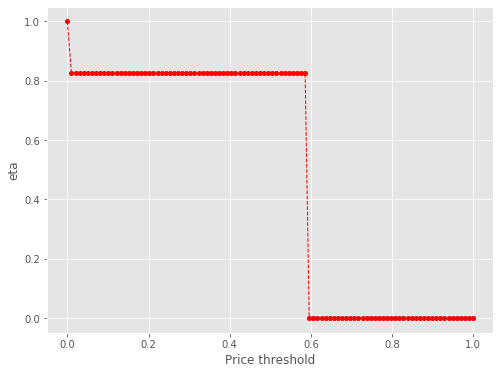

721 3
Number of cells with price above 72.0th percentile:  3


eta =  1.0
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =

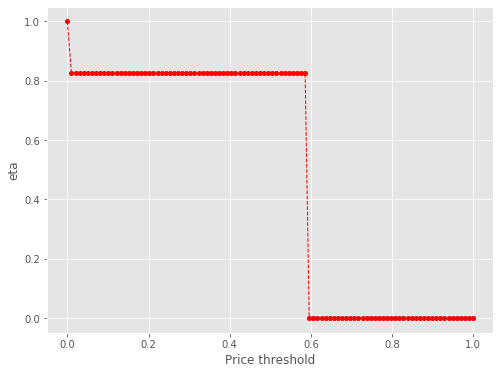

721 3
Number of cells with price above 73.0th percentile:  3


eta =  1.0
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =

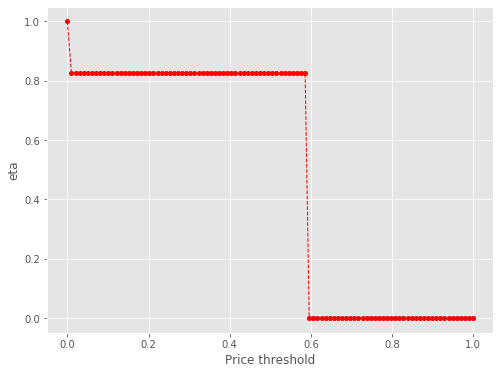

721 3
Number of cells with price above 74.0th percentile:  3


eta =  1.0
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =

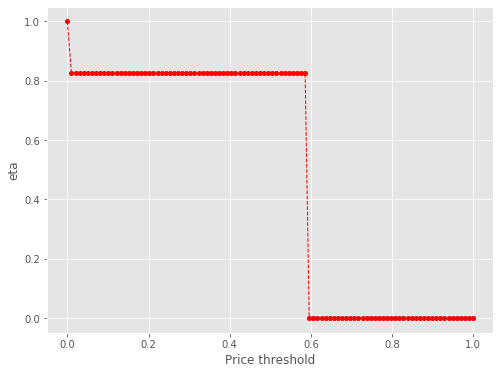

721 3
Number of cells with price above 75.0th percentile:  3


eta =  1.0
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =

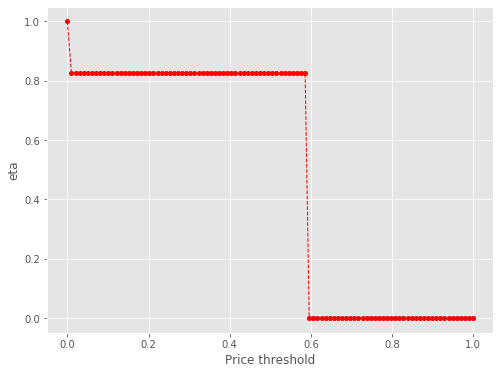

721 3
Number of cells with price above 76.0th percentile:  3


eta =  1.0
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =  0.82553944966866
eta =

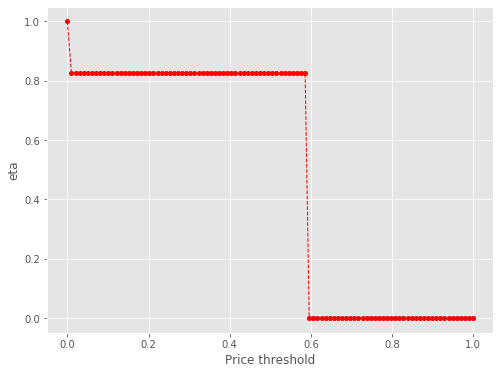

721 2
Number of cells with price above 77.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

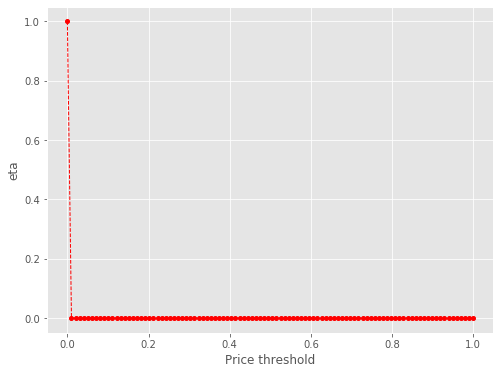

721 2
Number of cells with price above 78.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

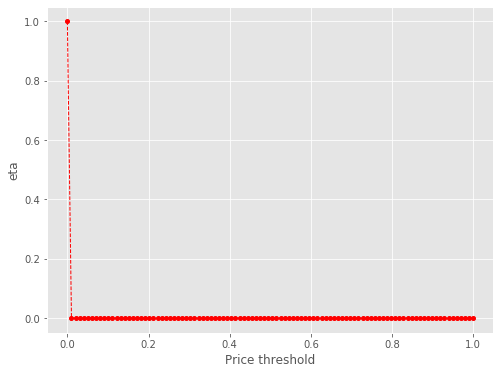

721 2
Number of cells with price above 79.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

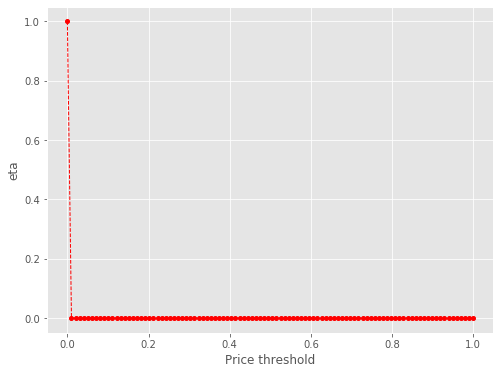

721 2
Number of cells with price above 80.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

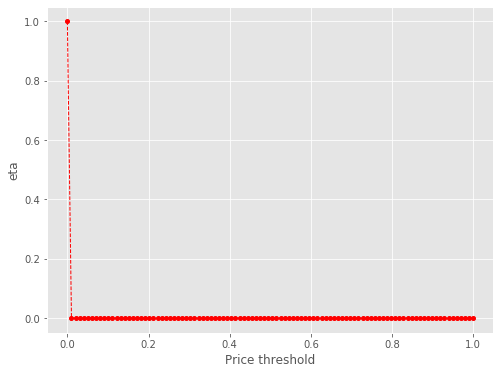

721 2
Number of cells with price above 81.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

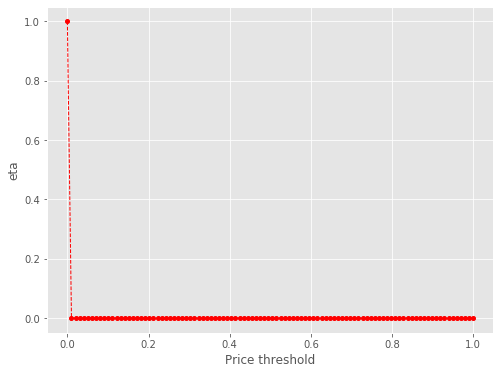

721 2
Number of cells with price above 82.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

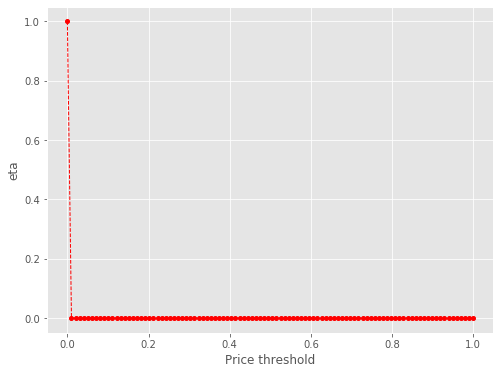

721 2
Number of cells with price above 83.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

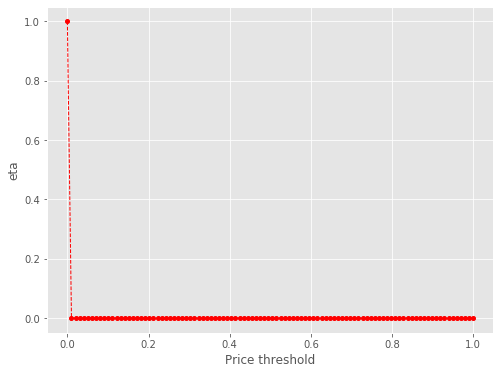

721 2
Number of cells with price above 84.00000000000001th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

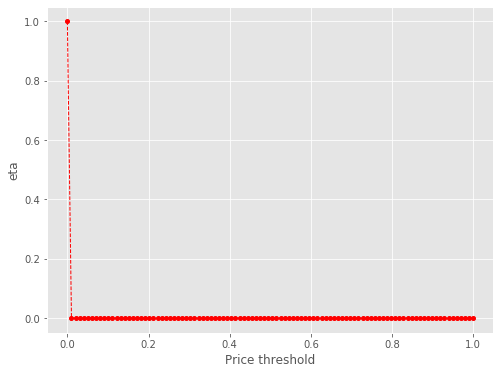

721 2
Number of cells with price above 85.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

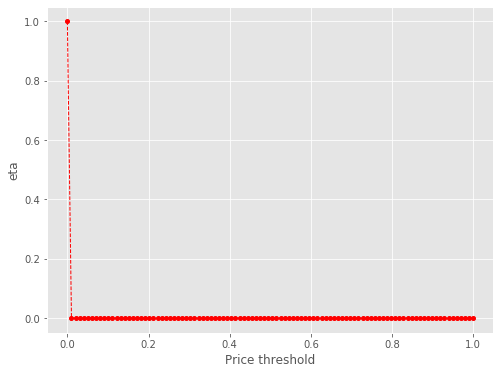

721 2
Number of cells with price above 86.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

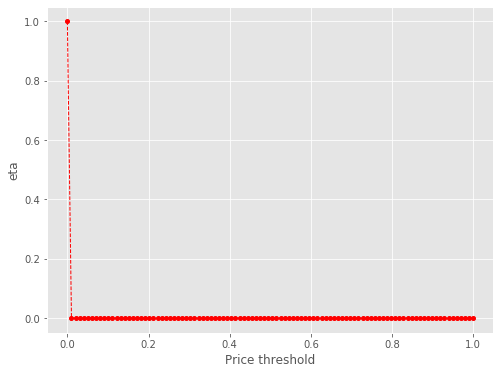

721 2
Number of cells with price above 87.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

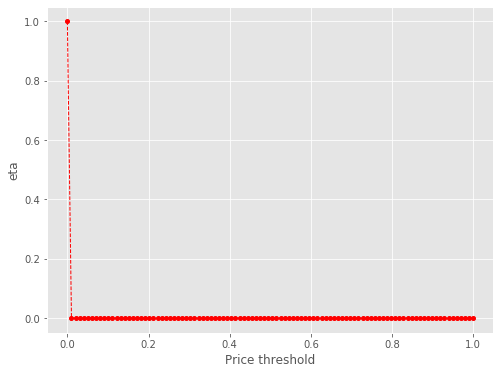

721 2
Number of cells with price above 88.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

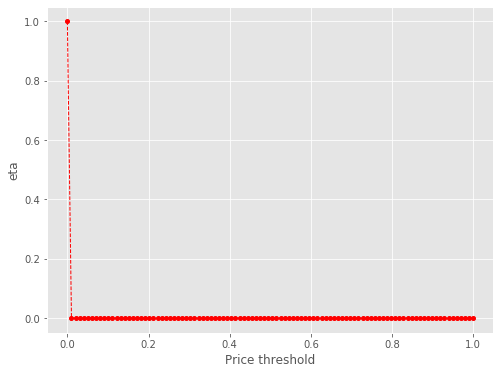

721 2
Number of cells with price above 89.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

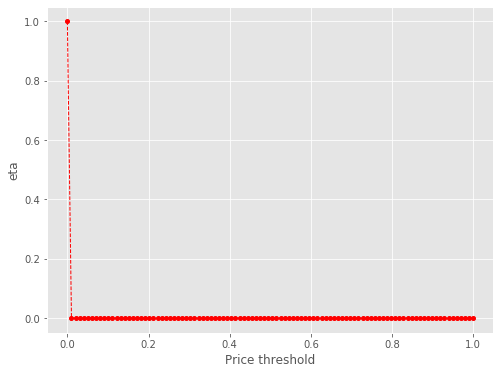

721 2
Number of cells with price above 90.0th percentile:  2


eta =  1.0
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

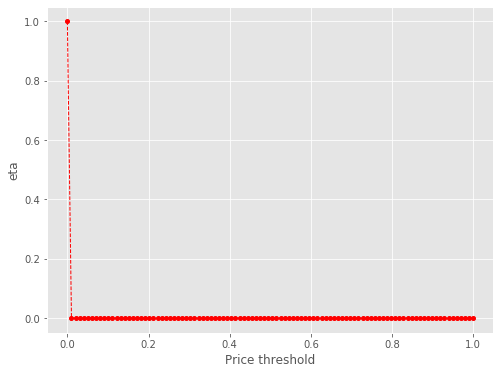

721 1
Number of cells with price above 91.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning:

invalid value encountered in true_divide



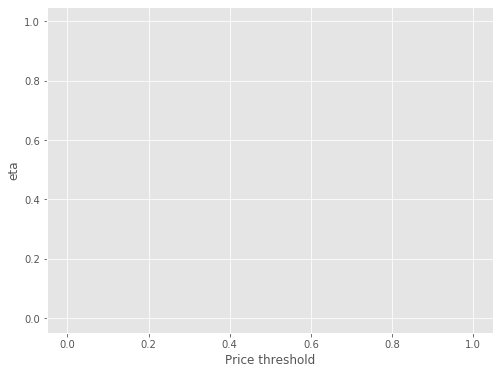

721 1
Number of cells with price above 92.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

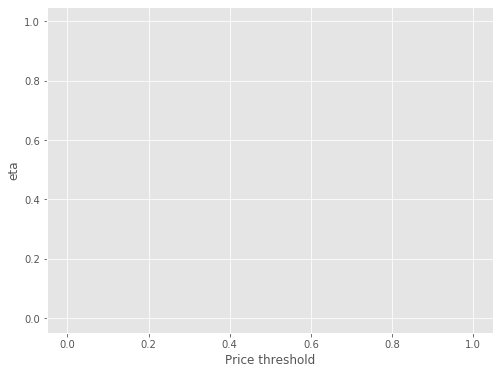

721 1
Number of cells with price above 93.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

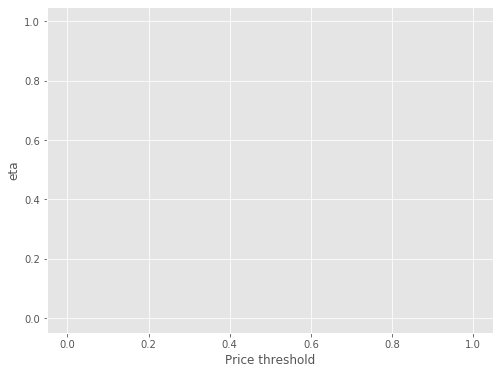

721 1
Number of cells with price above 94.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

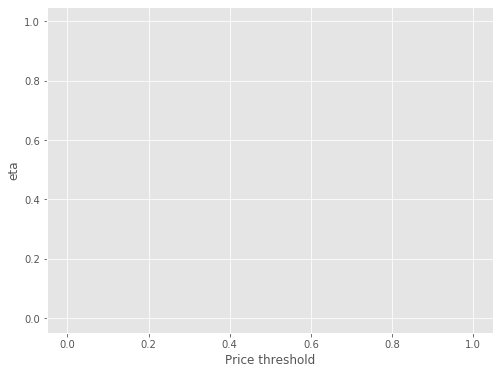

721 1
Number of cells with price above 95.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

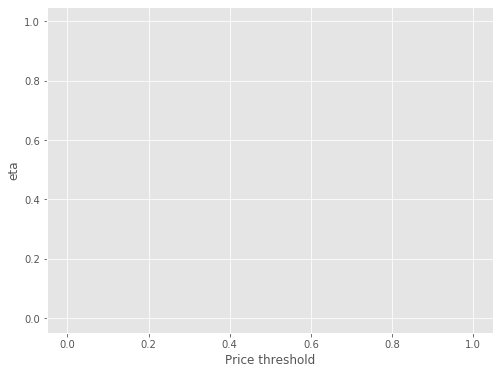

721 1
Number of cells with price above 96.00000000000001th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

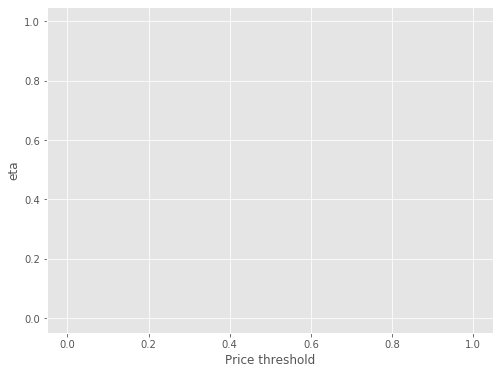

721 1
Number of cells with price above 97.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

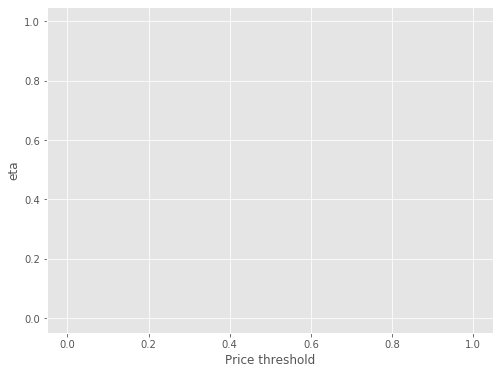

721 1
Number of cells with price above 98.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

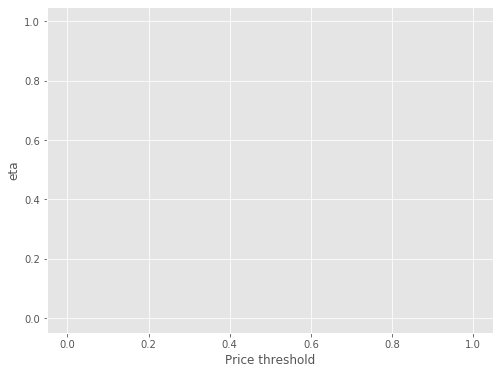

721 1
Number of cells with price above 99.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

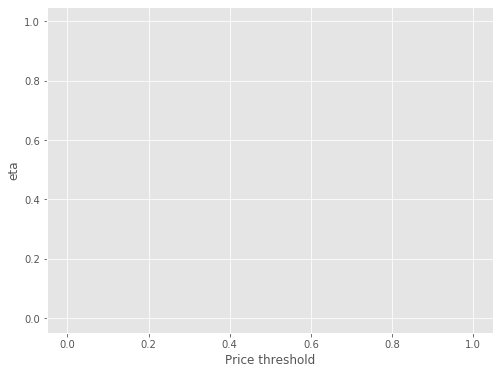

721 1
Number of cells with price above 100.0th percentile:  1


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan

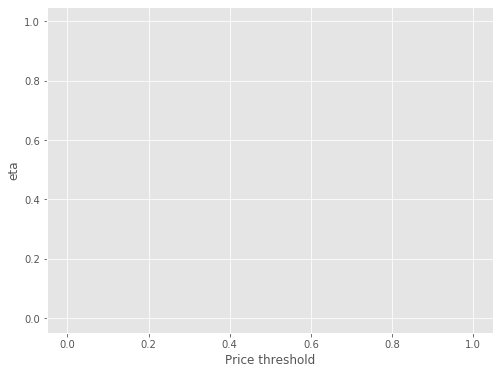


time: 1min 26s


In [32]:
lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
#keys = np.array(keys)
keys_initial = np.array(keys)


perc_vals = np.linspace(0.01, 1, 100)
etas_2d = []
for i in tqdm_notebook(perc_vals):
    keys = keys_initial
    vals_cut = vals[vals>=i*vals.max()]
    print(len(vals), len(vals_cut))

    L = np.cumsum(vals_cut)/np.sum(vals_cut)
    keys = keys[vals>=i*vals.max()]
    print('Number of cells with price above {}th percentile: '.format(i*100), len(keys))
    etas = []
    lval = np.linspace(min(vals_cut), max(vals_cut), 100)
    for k in tqdm_notebook(lval):
        loubar_keys = keys[vals_cut>=k]
        dist_mat = mat[keys.reshape(-1,1), keys]

        total_dist = dist_mat.sum()
        dist_corr = dist_mat[dist_mat>0]

        loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

        loubar_dist = loubar_dist_mat.sum()

        loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
        eta = loubar_dist_corr.mean()/dist_corr.mean()
        etas.append(eta)
        print('eta = ', eta)
    etas_array = np.array(etas)
    etas_array = np.where(np.isnan(etas_array), 0, etas_array)
    lval = (lval - lval.min())/(lval - lval.min()).max()
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(lval, etas_array, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
    plt.xlabel("Price threshold")
    plt.ylabel("eta")
    plt.show()
    etas_2d.append(etas)
etas_2d = np.array(etas_2d)
etas_2d = np.where(np.isnan(etas_2d), 0, etas_2d)
lval = lval/lval.max()

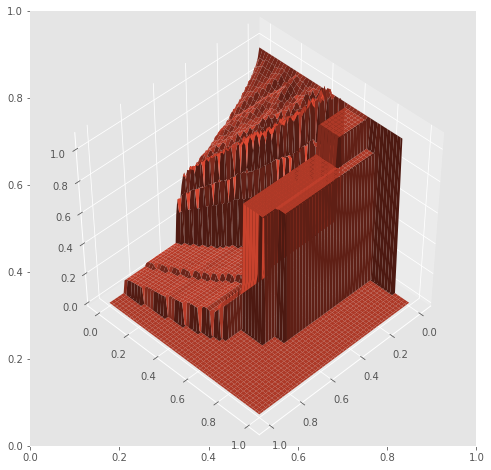

time: 998 ms


In [33]:
X,Y = np.meshgrid(np.linspace(0,1, 100),np.linspace(0,1, 100))
etas_surface = etas_2d
fig, ax = plt.subplots(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
# Plot a 3D surface
ax.plot_surface(X, Y, etas_surface)
ax.view_init(45, 45)
plt.show()

In [34]:
pickle_in = open("etas_surface_dict.pickle","rb")
etas_surface_dict = pickle.load(pickle_in)
#etas_surface_dict = {}
etas_surface_dict['Barcelona'] = etas_surface


pickle_out = open("etas_surface_dict.pickle","wb")
pickle.dump(etas_surface_dict, pickle_out)
pickle_out.close()

etas_surface_dict

{'NY': array([[1.        , 0.40697941, 0.38848337, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.95418349, 0.92471336, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.96911482, 0.94572765, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [1.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 'Boston': array([[1.        , 0.49308111, 0.46754658, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.94621367, 0.92299712, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.97340556, 0.95206791, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.       

time: 31 ms


721 254
Number of cells with price above 5th percentile:  254
total number of cells:  721
number of cells within urban airbnb territory:  254


Mean travel times in minutes:  10.974898827099738
Mean travel times in minutes:  15.739720226377953
Mean travel times in minutes:  22.924845759514433
Mean travel times in minutes:  31.780127788713905


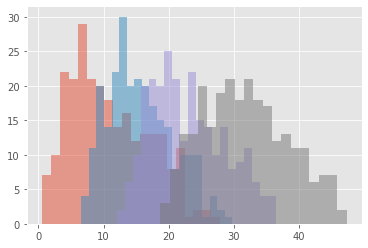

time: 2min 10s


In [36]:
from tqdm import tqdm_notebook

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)

vals_cut = vals[vals>0.1*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.1*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))

print('total number of cells: ', len(polylist))

times_names = ['times_{}'.format(c) for c in range(1, len(centers)+1)]
times_dict = {name:[] for name in times_names}

plist = poly_prices[poly_prices.index.isin(keys)].geometry.tolist()
print('number of cells within urban airbnb territory: ', len(plist))
for poly in tqdm_notebook(plist):
    origin = ox.get_nearest_node(G, poly.centroid.coords[0][::-1])
    dists_to_centers = []
    for node, target in centers.items():
        try:
            if origin!=target:
                path = nx.shortest_path(G, origin, target, weight='length')
                edges = [ tuple( path[i:i+2] ) for i in range( len(path) - 1 ) ]
                dist = np.sum([G.get_edge_data(*edge)[0]['length'] for edge in edges])
                dists_to_centers.append(dist)
        except:
            pass
    if len(dists_to_centers) != 0:
        dists_to_centers = sorted(dists_to_centers)
        #print('distance list length equal to # of centers: ', len(dists_to_centers)==len(centers))
        if len(dists_to_centers)==len(centers):
            for n, dist in enumerate(dists_to_centers):
                time = (dist/3.2)/60
                times_dict['times_{}'.format(n+1)].append(time)
                #print(times_dict['times_{}'.format(n+1)][-1])
        else:
            print('Distance list length NOT equal to # of centers')

#print(distances_dict)
for center in range(1, len(centers)+1):
    print("Mean travel times in minutes: ", np.mean(times_dict['times_{}'.format(center)]))
for center in range(1, len(centers)+1):
    plt.hist(times_dict['times_{}'.format(center)], bins=20, alpha=0.5)
plt.show()

Mean travel times in minutes:  10.974898827099738
Mean travel times in minutes:  15.739720226377953
Mean travel times in minutes:  22.924845759514433
Mean travel times in minutes:  31.780127788713905


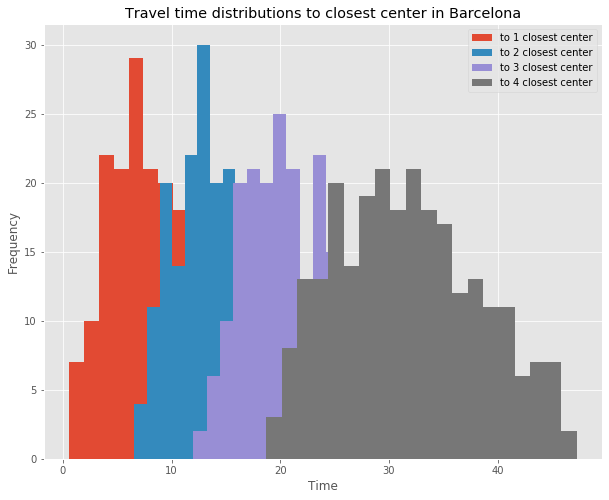

time: 513 ms


In [37]:
for center in range(1, len(centers)+1):
    times_dict['times_{}'.format(center)] = np.array(times_dict['times_{}'.format(center)])
    
for center in range(1, len(centers)+1):
    print("Mean travel times in minutes: ", np.mean(times_dict['times_{}'.format(center)]))

fig, ax = plt.subplots(figsize=(10,8))
for center in range(1, len(centers)+1):
    plt.hist(times_dict['times_{}'.format(center)], bins=20, alpha=1, label='to {} closest center'.format(center))
plt.title('Travel time distributions to closest center in Barcelona')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [38]:
pickle_in = open("City_Accessibility.pickle","rb")
access_dict = pickle.load(pickle_in)
#access_dict = {}
access_dict['Barcelona'] = times_dict


pickle_out = open("City_Accessibility.pickle","wb")
pickle.dump(access_dict, pickle_out)
pickle_out.close()

access_dict

{'Paris': {'times_1': array([ 4.73219737,  4.40047807,  7.81577632,  7.07926754,  6.7129386 ,
          7.48037281, 10.85755263,  8.41227193, 14.20045614, 15.15502193,
         16.00692982, 15.80582895, 14.35941228, 14.10681579, 12.26687281,
         13.89203947, 14.31310965, 15.99389474, 16.77728947, 17.82112281,
         20.19769737, 20.40849561, 21.93033333, 22.03087719, 20.6584386 ,
         20.62538596, 19.53197368, 20.61141228, 21.70609211, 23.22407018,
         21.70395614, 23.12607456, 22.79396053, 23.95434211, 21.49400439,
         21.55605702, 22.35374123, 22.36948246, 22.44162719, 21.54410965,
         21.93589912, 21.86757456, 21.86757456, 21.41060088, 21.92571491,
         22.93862281, 23.57200877, 25.13889474, 24.49192982, 26.04400877,
         26.815     , 38.90660088, 38.56507018, 37.89241228, 36.57546491,
         29.87379386, 27.54254825, 25.54755702, 26.98263158, 25.76562281,
         25.03485526, 25.37799123, 25.69687719, 26.07382018, 23.81846491,
         24.034649

time: 1.26 s


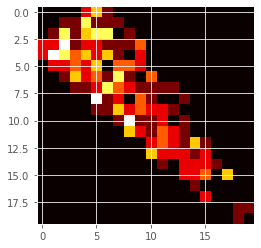

time: 322 ms


In [39]:
x = times_dict['times_{}'.format(1)]
y = times_dict['times_{}'.format(2)]
c_xy = np.histogram2d(x, y, 20)[0]
c_xx = np.histogram2d(x, x, 20)[0]
plt.imshow(c_xy, cmap='hot', interpolation='nearest')
plt.show()

In [40]:
from sklearn.metrics import mutual_info_score

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

mi_list = []
for center in range(1, len(centers)+1):
    mi_list.append(times_dict['times_{}'.format(center)])

mis = []
for pair in combinations_with_replacement(mi_list, 2):
    MI = calc_MI(pair[0], pair[1], 20)
    print(MI)
    mis.append(MI)
mis = np.array(mis)
avg_mi = np.mean(mis)
print('average mutual information = ', avg_mi)

2.7851369816650733
1.010908883728296
0.6718425426934524
0.608185617222976
2.777636115451543
0.8680240475131681
0.8709454631362843
2.847081640104005
1.1295751539335446
2.8806007850886823
average mutual information =  1.6449937230537024
time: 36 ms


In [41]:
pickle_in = open("Time_distribution_mutual_information.pickle","rb")
MI_dict = pickle.load(pickle_in)
#MI_dict = {}
MI_dict['Barcelona'] = avg_mi


pickle_out = open("Time_distribution_mutual_information.pickle","wb")
pickle.dump(MI_dict, pickle_out)
pickle_out.close()

MI_dict

{'Beijing': 1.6170682943522052,
 'Florence': 2.0836399429599792,
 'Palermo': 1.8596013030930105,
 'Los_Angeles': 1.5602500680599918,
 'Moscow': 1.5631970905638934,
 'Porto': 1.6277816420571996,
 'Prague': 2.176480497902222,
 'Reykjavik': 1.3730161847793374,
 'Riga': 2.240374487910287,
 'Rome': 1.6095563575725969,
 'Seoul': 1.2910685865906735,
 'Siena': 2.7660068415344448,
 'Sydney': 1.2791891753795948,
 'Tallin': 2.3884073435187867,
 'Treviso': 2.631909071373147,
 'Valencia': 2.1872520197930965,
 'Venezia': 2.719891808939249,
 'Verona': 2.7080241467515376,
 'Vicenza': 2.6192607829416756,
 'Vienna': 1.4481542925032476,
 'Wellington': 2.1855226822614866,
 'Zurich': 2.462051055806955,
 'Aarhus': 2.2910468431831847,
 'Milan': 1.6107461389394335,
 'Busan': 1.903641833377143,
 'Barcelona': 1.6449937230537024,
 'Bologna': 2.7317991260148045,
 'Bremen': 1.9447717965210316,
 'Brno': 2.4300669174144036,
 'Budapest': 2.219525897631017,
 'Dublin': 1.830502368836079,
 'Boston': 1.1451275682586615,


time: 18 ms
